In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams.update({'font.size': 8})

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
from textwrap import wrap

import pandas as pd
import statsmodels.api as sm 

# sns.set(style="whitegrid", palette="Set2", context="notebook", rc={'axes.formatter.limits': (-3, 3), "grid.color": ".9"}, )
sns.set(style="ticks", palette="Set2", context="paper", rc={'axes.formatter.limits': (-3, 3)}, )
warnings.filterwarnings(action='ignore')


element_display_dict = {"FE": "Fe", "ZN": "Zn", "MN": "Mn", "CU": "Cu", "MO": "Mo", "NI": "Ni", "CO": "Co", "V": "V", "CR": "Cr"}

In [2]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

In [3]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")


complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")
total_counts_big_min = read_matrix("data/minimal_counts_big.csv")
total_vol_rich = read_matrix("data/rich_vol_big.csv")
total_vol_min = read_matrix("data/minimal_vol_big.csv")

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

lineage_df = pl.read_csv("data/lineage_timeseries.csv")
lineage_df_min = pl.read_csv("data/lineage_min_timeseries.csv")

# get example data
example_counts = pl.read_csv("data/example_counts.csv")

In [4]:
total_counts.shape

(1289, 5527)

# Summary statistics

In [5]:
# number of interactions
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

cofactor_matrix = (P @ E)[:, element_indices]

print(cofactor_matrix.sum())

elements = ["ZN",]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

cofactor_matrix = (P @ E)[:, element_indices]
print(cofactor_matrix.sum())

elements = ["MO",]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

cofactor_matrix = (P @ E)[:, element_indices]
print(cofactor_matrix.sum())

1188
201
18


# Lineage timeseries

In [6]:
# concat lineage_df and lineage_df_min
lineage_upd_df = lineage_df.with_columns(pl.lit("Rich").alias("Condition"))
lineage_upd_df_min = lineage_df_min.with_columns(pl.lit("Minimal").alias("Condition"))

# update mete_counts in rich
lineage_upd_df = lineage_upd_df.with_columns(pl.when(pl.col("variable") == "mete_counts").then(pl.col("value") * 0.25).otherwise(pl.col("value")).alias("value"))
lineage_upd_df_min = lineage_upd_df_min.with_columns(pl.when(pl.col("variable") == "rpme_counts").then(pl.col("value") * 0.5).otherwise(pl.col("value")).alias("value"))


metal_lineage_df = lineage_upd_df.filter(pl.col("variable") == 'protein_counts').with_columns(pl.col("value") * 4)

# set variable to pl lit metal_counts
metal_lineage_df = metal_lineage_df.with_columns(pl.lit("metal_counts").alias("variable"))

# do rolling mean for uptake
uptake_df = lineage_upd_df.filter(pl.col("variable") == "total_zn_counts").with_columns(pl.col("value").diff(n=1).rolling_mean(5)).filter(pl.col("value") > 0)

# change variable to uptake
uptake_df = uptake_df.with_columns(pl.lit("total_zn_uptake").alias("variable"))

# concatenate with lineage_df
lineage_upd_df = pl.concat([lineage_upd_df, metal_lineage_df, uptake_df])

# rename timestep to Timestep (s)
lineage_upd_df = lineage_upd_df.with_columns(pl.col("timestep").alias("Time (s)"))
lineage_upd_df_min = lineage_upd_df_min.with_columns(pl.col("timestep").alias("Time (s)"))

In [7]:
lineage_upd_df.unique("variable")

shape: (9, 5)
┌──────────┬─────────────────┬─────────────┬───────────┬──────────┐
│ timestep ┆ variable        ┆ value       ┆ Condition ┆ Time (s) │
│ ---      ┆ ---             ┆ ---         ┆ ---       ┆ ---      │
│ i64      ┆ str             ┆ f64         ┆ str       ┆ i64      │
╞══════════╪═════════════════╪═════════════╪═══════════╪══════════╡
│ 0        ┆ mass            ┆ 2764.823501 ┆ Rich      ┆ 0        │
│ 0        ┆ metal_counts    ┆ 28684.0     ┆ Rich      ┆ 0        │
│ 0        ┆ total_zn_counts ┆ 292723.0    ┆ Rich      ┆ 0        │
│ 5        ┆ total_zn_uptake ┆ 98.4        ┆ Rich      ┆ 5        │
│ 0        ┆ rpme_counts     ┆ 46566.0     ┆ Rich      ┆ 0        │
│ 0        ┆ gene_counts     ┆ 2.0         ┆ Rich      ┆ 0        │
│ 0        ┆ rna_counts      ┆ 10.0        ┆ Rich      ┆ 0        │
│ 0        ┆ protein_counts  ┆ 7171.0      ┆ Rich      ┆ 0        │
│ 0        ┆ mete_counts     ┆ 1518.75     ┆ Rich      ┆ 0        │
└──────────┴─────────────────┴─────────────┴───────────┴──────────┘

# Sim example traces

<Figure size 1200x600 with 0 Axes>

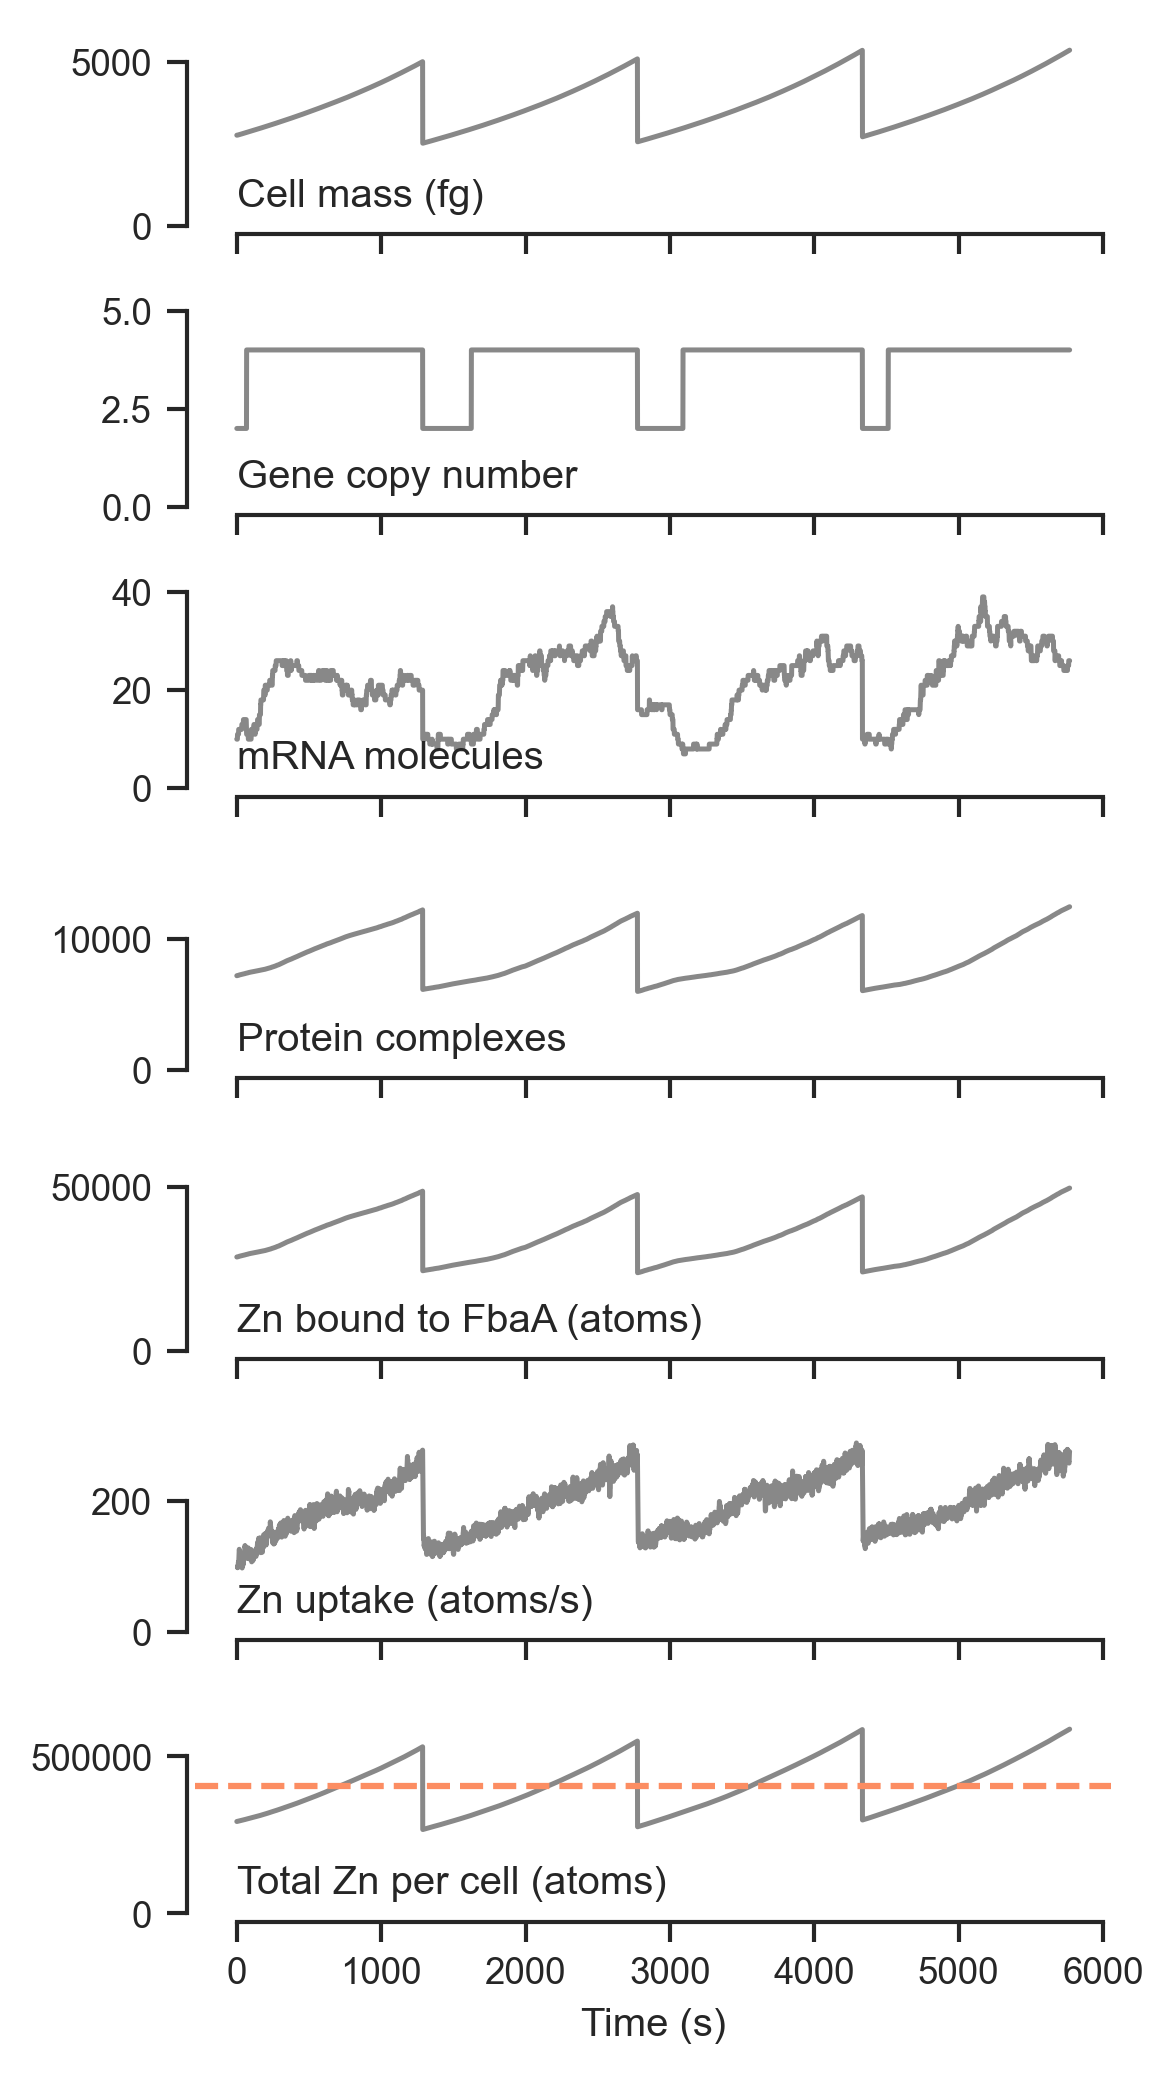

In [8]:
plt.figure(figsize=[4,2])

row_order = ['mass', 'gene_counts', 'rna_counts', 'protein_counts', 'metal_counts', 'total_zn_uptake', 'total_zn_counts']

color = '#888888'

# get mean of total_zn_counts
mean_zn = lineage_upd_df.filter(pl.col("variable") == "total_zn_counts").group_by("variable").agg(pl.mean("value").alias("value")).select("value").to_numpy()[0][0]

g = sns.relplot(data=lineage_upd_df.filter(pl.col("variable").is_in(row_order)), x='Time (s)', y='value', row='variable', kind='line', # hue="Condition",
                height=1, aspect=4, color=color,
                row_order = row_order,
                facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True, 'despine': False}, )



# remove titles
g.set_titles(row_template="")

# set only terminal tick marks
g.axes.flat[0].set_ylim(0, 6000)
g.axes.flat[1].set_ylim(0, 5)
g.axes.flat[2].set_ylim(0, 40)
g.axes.flat[3].set_ylim(0, 15000)
g.axes.flat[4].set_ylim(0, 60000)
g.axes.flat[5].set_ylim(0, 300)
g.axes.flat[6].set_ylim(0, 625000)

# temporarily set axis formatter limits to not show scientific
for i in range(len(g.axes.flat)):
    g.axes.flat[i].yaxis.get_major_formatter().set_scientific(False)
    g.axes.flat[i].set_ylabel("")

g.axes.flat[-1].xaxis.get_major_formatter().set_scientific(False)

# on last plot, plot mean zn as horizontal line
g.axes.flat[-1].axhline(mean_zn, linestyle='--', linewidth=1.5, label='Mean Zn counts',  color=sns.color_palette('Set2')[1])

# write text on last plot
g.axes.flat[0].text(x=0, y=6000/10, s='Cell mass (fg)')
g.axes.flat[1].text(x=0, y=5/10, s='Gene copy number')
g.axes.flat[2].text(x=0, y=40/10, s='mRNA molecules')
g.axes.flat[3].text(x=0, y=15000/10, s='Protein complexes')
g.axes.flat[4].text(x=0, y=60000/10, s='Zn bound to FbaA (atoms)')
g.axes.flat[5].text(x=0, y=300/10, s='Zn uptake (atoms/s)')
g.axes.flat[6].text(x=0, y=625000/10, s='Total Zn per cell (atoms)')

sns.despine(offset=2, trim=True)

plt.tight_layout()

# save as svg
plt.savefig("figures/lineage_timeseries.svg", transparent=True)


# MetE rib traces

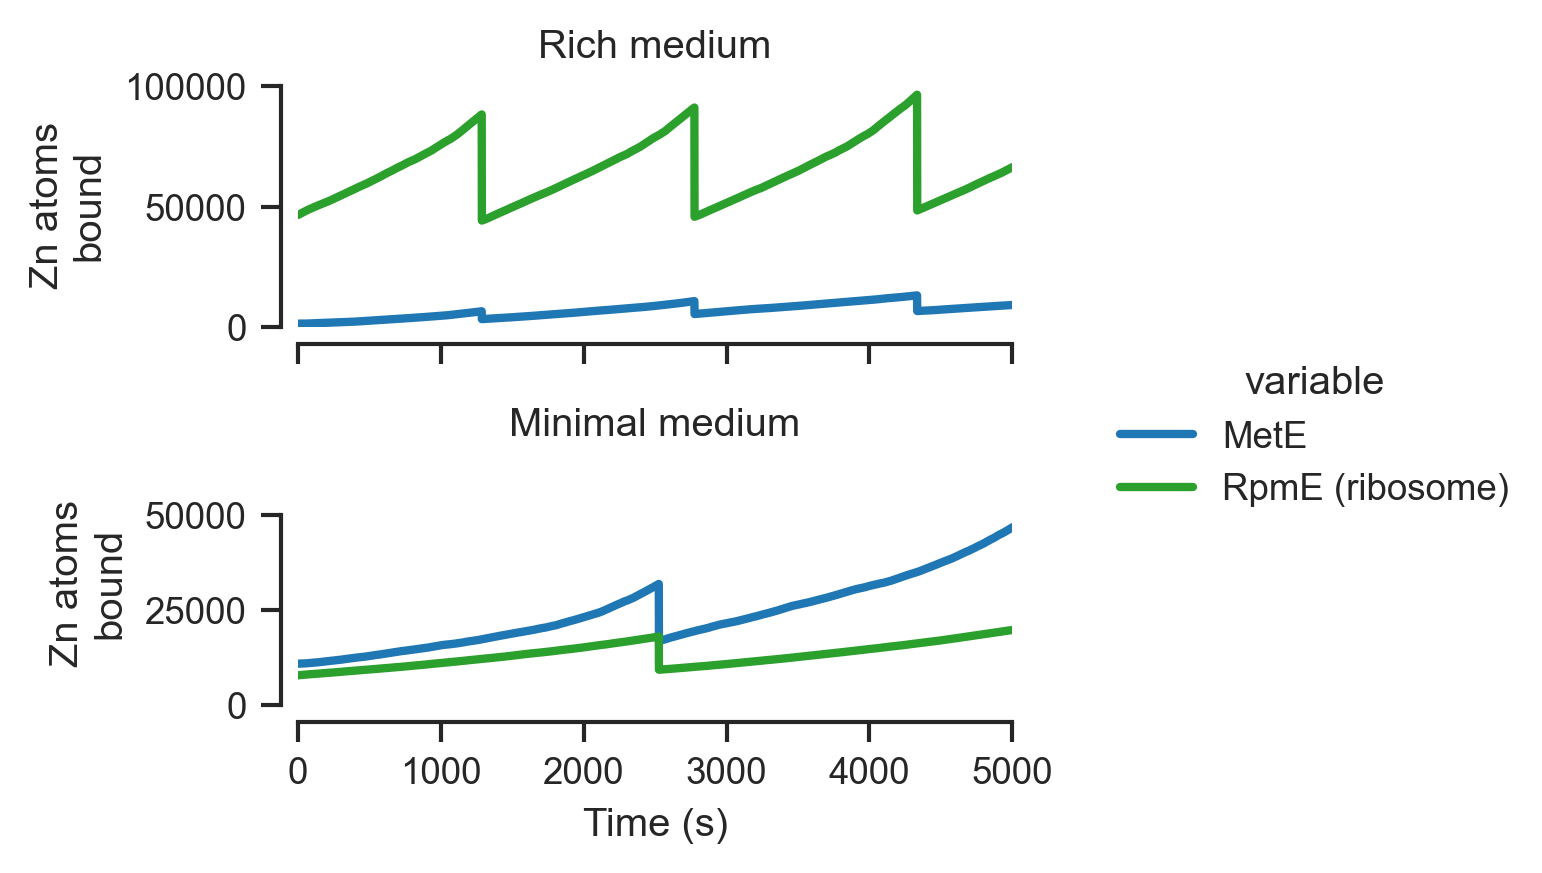

In [9]:
total_lineage_df = pl.concat([lineage_upd_df, lineage_upd_df_min])

# filter variable to be in ["metE_counts", "ribosome_counts"]
total_lineage_df = total_lineage_df.filter(pl.col("variable").is_in(["mete_counts", "rpme_counts"]))

# using mapping dict to rename variable values
mapping_dict = {
    "mete_counts": "MetE",
    "rpme_counts": "RpmE (ribosome)"
}

total_lineage_plot_df = total_lineage_df.with_columns(
    pl.col("variable").replace(mapping_dict).alias("variable")
)

hue_order = ["MetE", "RpmE (ribosome)"]

# make hue palette, first blue then green
palette = ['#1f77b4', '#2ca02c']  # blue and green

# do a facet plot
g = sns.relplot(data=total_lineage_plot_df, x='Time (s)', y='value', hue='variable', hue_order=hue_order, palette=palette,
                row='Condition', kind='line', height=1.5,aspect=2.5, linewidth=2,
                facet_kws={'sharey': False, 'sharex': True})


for i in range(len(g.axes.flat)):
    g.axes.flat[i].yaxis.get_major_formatter().set_scientific(False)
    g.axes.flat[i].xaxis.get_major_formatter().set_scientific(False)
    g.axes.flat[i].set_ylabel("Zn atoms\nbound")
    g.axes.flat[i].set_xlim(0, 5000)
    g.axes.flat[i].set_ylim(0, None)


# format row titles
g.set_titles(row_template="{row_name} medium")

sns.despine(offset=4, trim=True)

g.tight_layout()


# save as svg
plt.savefig("figures/metE_ribosome_timeseries.svg", transparent=True)

# Validation against 2001 ICP-MS data

## minimal media

In [10]:
# add volume array[:, 1] as new column to big_element_df 
min_vol_df = pl.DataFrame(total_vol_min, schema=["Timestep", "Volume", "Cell index"])

# cast columns to int float int
min_vol_df = min_vol_df.with_columns( (min_vol_df["Timestep"].cast(pl.Int64)).alias("Timestep"))
min_vol_df = min_vol_df.with_columns( (min_vol_df["Cell index"].cast(pl.Int64)).alias("Cell index"))


In [11]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
big_element_timeseries = total_counts_big_min[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big_min[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# join with big_element df
big_element_df = big_element_df.join(min_vol_df, on=["Timestep", "Cell index"])

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction", "Volume"], value_name="Atoms/cell", variable_name="Element")

# Get the weighted average per element
big_element_df = big_element_df.with_columns( (big_element_df["Atoms/cell"] * big_element_df["Density correction"]).alias("Weighted atoms/cell"))

# copy to new df
big_element_df_min = big_element_df

# divide sum of weighted atoms/cell by sum of density correction
bulk_element_sum = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Weighted atoms/cell").alias("Sum weighted atoms/cell"))
bulk_element_count = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

# join the two dataframes and divide
bulk_element_df = bulk_element_sum.join(bulk_element_count, on=["Element", "Cell index"])
bulk_element_df = bulk_element_df.with_columns( (bulk_element_df["Sum weighted atoms/cell"] / bulk_element_df["Sum density correction"]).alias("Bulk atoms/cell"))

# remove other cols
bulk_element_df = bulk_element_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# save to csv
bulk_element_df.write_csv("data/sim_rich_bulk_element_df.csv", include_header=True)

# calculate avg and std dev over all cells
bulk_element_avg_min = bulk_element_df.group_by("Element").agg(pl.mean("Bulk atoms/cell").alias("Avg atoms/cell"), pl.std("Bulk atoms/cell").alias("Std atoms/cell"))

# add two rows: V and CR with 0 atoms/cell. Concat them to bulk_element_avg
bulk_element_avg_min = pl.concat([bulk_element_avg_min, pl.DataFrame([["V", 0., 0.], ["CR", 0., 0.]], schema=["Element", "Avg atoms/cell", "Std atoms/cell"])])

# set "CO" to 0
bulk_element_avg_min = bulk_element_avg_min.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Avg atoms/cell")).alias("Avg atoms/cell"))
bulk_element_avg_min = bulk_element_avg_min.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Std atoms/cell")).alias("Std atoms/cell"))

bulk_element_avg_min

shape: (9, 3)
┌─────────┬────────────────┬────────────────┐
│ Element ┆ Avg atoms/cell ┆ Std atoms/cell │
│ ---     ┆ ---            ┆ ---            │
│ str     ┆ f64            ┆ f64            │
╞═════════╪════════════════╪════════════════╡
│ MO      ┆ 2190.045015    ┆ 274.20151      │
│ CU      ┆ 8494.231262    ┆ 862.443333     │
│ ZN      ┆ 215018.559173  ┆ 14304.788166   │
│ CO      ┆ 0.0            ┆ 0.0            │
│ NI      ┆ 684.082189     ┆ 125.737464     │
│ MN      ┆ 36049.755197   ┆ 2324.314223    │
│ FE      ┆ 267598.232091  ┆ 16974.659764   │
│ V       ┆ 0.0            ┆ 0.0            │
│ CR      ┆ 0.0            ┆ 0.0            │
└─────────┴────────────────┴────────────────┘

## rich media

In [12]:
# add volume array[:, 1] as new column to big_element_df 
rich_vol_df = pl.DataFrame(total_vol_rich, schema=["Timestep", "Volume", "Cell index"])

# cast columns to int float int
rich_vol_df = rich_vol_df.with_columns( (rich_vol_df["Timestep"].cast(pl.Int64)).alias("Timestep"))
rich_vol_df = rich_vol_df.with_columns( (rich_vol_df["Cell index"].cast(pl.Int64)).alias("Cell index"))


In [13]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# join with big_element df
big_element_df = big_element_df.join(rich_vol_df, on=["Timestep", "Cell index"])

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction", "Volume"], value_name="Atoms/cell", variable_name="Element")

# Get the weighted average per element
big_element_df = big_element_df.with_columns( (big_element_df["Atoms/cell"] * big_element_df["Density correction"]).alias("Weighted atoms/cell"))

# copy to new df
big_element_df_rich = big_element_df

# divide sum of weighted atoms/cell by sum of density correction
bulk_element_sum = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Weighted atoms/cell").alias("Sum weighted atoms/cell"))
bulk_element_count = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

# join the two dataframes and divide
bulk_element_df = bulk_element_sum.join(bulk_element_count, on=["Element", "Cell index"])
bulk_element_df = bulk_element_df.with_columns( (bulk_element_df["Sum weighted atoms/cell"] / bulk_element_df["Sum density correction"]).alias("Bulk atoms/cell"))

# remove other cols
bulk_element_df = bulk_element_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# save to csv
bulk_element_df.write_csv("data/sim_rich_bulk_element_df.csv", include_header=True)

# calculate avg and std dev over all cells
bulk_element_avg = bulk_element_df.group_by("Element").agg(pl.mean("Bulk atoms/cell").alias("Avg atoms/cell"), pl.std("Bulk atoms/cell").alias("Std atoms/cell"))

# add two rows: V and CR with 0 atoms/cell. Concat them to bulk_element_avg
bulk_element_avg = pl.concat([bulk_element_avg, pl.DataFrame([["V", 0., 0.], ["CR", 0., 0.]], schema=["Element", "Avg atoms/cell", "Std atoms/cell"])])

# set "CO" to 0
bulk_element_avg = bulk_element_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Avg atoms/cell")).alias("Avg atoms/cell"))
bulk_element_avg = bulk_element_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Std atoms/cell")).alias("Std atoms/cell"))

bulk_element_avg

shape: (9, 3)
┌─────────┬────────────────┬────────────────┐
│ Element ┆ Avg atoms/cell ┆ Std atoms/cell │
│ ---     ┆ ---            ┆ ---            │
│ str     ┆ f64            ┆ f64            │
╞═════════╪════════════════╪════════════════╡
│ NI      ┆ 1284.841822    ┆ 176.78077      │
│ FE      ┆ 494684.179294  ┆ 34074.181705   │
│ CO      ┆ 0.0            ┆ 0.0            │
│ ZN      ┆ 357249.636639  ┆ 22782.838522   │
│ CU      ┆ 15211.081627   ┆ 1051.768662    │
│ MO      ┆ 3444.940736    ┆ 394.060051     │
│ MN      ┆ 69398.444095   ┆ 3754.98889     │
│ V       ┆ 0.0            ┆ 0.0            │
│ CR      ┆ 0.0            ┆ 0.0            │
└─────────┴────────────────┴────────────────┘

## Reweigh volumes to get average volume per condition

In [14]:
rich_vol_df = pl.DataFrame(total_vol_rich, schema=["Timestep", "Volume", "Cell index"])

max_timestep = rich_vol_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))
rich_vol_df = rich_vol_df.join(max_timestep, on="Cell index")
rich_vol_df = rich_vol_df.with_columns( (2 ** ((rich_vol_df["Max timestep"] - rich_vol_df["Timestep"]) 
                                                     / rich_vol_df["Max timestep"])).alias("Density correction"))
rich_vol_df = rich_vol_df.drop(["Timestep", "Max timestep"])

rich_vol_df = rich_vol_df.melt(id_vars=["Cell index", "Density correction"], value_name="Volume (fL)", variable_name="Type")
rich_vol_df = rich_vol_df.with_columns( (rich_vol_df["Volume (fL)"] * rich_vol_df["Density correction"]).alias("Weighted volume"))

bulk_vol_sum = rich_vol_df.group_by(["Cell index"]).agg(pl.sum("Weighted volume").alias("Sum volume/cell"))
bulk_vol_count = rich_vol_df.group_by(["Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

bulk_vol_df = bulk_vol_sum.join(bulk_vol_count, on=["Cell index"])
bulk_vol_df = bulk_vol_df.with_columns( (bulk_vol_df["Sum volume/cell"] / bulk_vol_df["Sum density correction"]).alias("Volume/cell (fL)"))
bulk_vol_df = bulk_vol_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# calculate avg volume
bulk_vol_avg_rich = bulk_vol_df.mean()

# add condition
bulk_vol_avg_rich = bulk_vol_avg_rich.with_columns(pl.lit("Rich").alias("Condition"))

bulk_vol_avg_rich

shape: (1, 4)
┌────────────┬─────────────────┬──────────────────┬───────────┐
│ Cell index ┆ Sum volume/cell ┆ Volume/cell (fL) ┆ Condition │
│ ---        ┆ ---             ┆ ---              ┆ ---       │
│ f64        ┆ f64             ┆ f64              ┆ str       │
╞════════════╪═════════════════╪══════════════════╪═══════════╡
│ 9.0        ┆ 6113.11135      ┆ 3.073264         ┆ Rich      │
└────────────┴─────────────────┴──────────────────┴───────────┘

In [15]:
min_vol_df = pl.DataFrame(total_vol_min, schema=["Timestep", "Volume", "Cell index"])

max_timestep = min_vol_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))
min_vol_df = min_vol_df.join(max_timestep, on="Cell index")
min_vol_df = min_vol_df.with_columns( (2 ** ((min_vol_df["Max timestep"] - min_vol_df["Timestep"]) 
                                                     / min_vol_df["Max timestep"])).alias("Density correction"))
min_vol_df = min_vol_df.drop(["Timestep", "Max timestep"])

min_vol_df = min_vol_df.melt(id_vars=["Cell index", "Density correction"], value_name="Volume (fL)", variable_name="Type")
min_vol_df = min_vol_df.with_columns( (min_vol_df["Volume (fL)"] * min_vol_df["Density correction"]).alias("Weighted volume"))

bulk_vol_sum = min_vol_df.group_by(["Cell index"]).agg(pl.sum("Weighted volume").alias("Sum volume/cell"))
bulk_vol_count = min_vol_df.group_by(["Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

bulk_vol_df = bulk_vol_sum.join(bulk_vol_count, on=["Cell index"])
bulk_vol_df = bulk_vol_df.with_columns( (bulk_vol_df["Sum volume/cell"] / bulk_vol_df["Sum density correction"]).alias("Volume/cell (fL)"))
bulk_vol_df = bulk_vol_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# calculate avg volume
bulk_vol_avg_min = bulk_vol_df.mean()

# add condition colume with value "minimal"
bulk_vol_avg_min = bulk_vol_avg_min.with_columns(pl.lit("Minimal").alias("Condition"))

bulk_vol_avg_min

shape: (1, 4)
┌────────────┬─────────────────┬──────────────────┬───────────┐
│ Cell index ┆ Sum volume/cell ┆ Volume/cell (fL) ┆ Condition │
│ ---        ┆ ---             ┆ ---              ┆ ---       │
│ f64        ┆ f64             ┆ f64              ┆ str       │
╞════════════╪═════════════════╪══════════════════╪═══════════╡
│ 4.0        ┆ 5534.152344     ┆ 1.44983          ┆ Minimal   │
└────────────┴─────────────────┴──────────────────┴───────────┘

## Create concat volume df

In [16]:
# create concat volume df 
bulk_vol_avg = pl.concat([bulk_vol_avg_rich, bulk_vol_avg_min])

# drop cell index and sum volume
bulk_vol_avg = bulk_vol_avg.drop(["Cell index", "Sum volume/cell"])

bulk_vol_avg

shape: (2, 2)
┌──────────────────┬───────────┐
│ Volume/cell (fL) ┆ Condition │
│ ---              ┆ ---       │
│ f64              ┆ str       │
╞══════════════════╪═══════════╡
│ 3.073264         ┆ Rich      │
│ 1.44983          ┆ Minimal   │
└──────────────────┴───────────┘

# Expor table of interactions for Mia for overlaying on protein count comparison

In [17]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
interaction_matrix = C @ P @ E[:, element_indices]

# create dataframe 
interaction_df = pl.DataFrame(interaction_matrix.toarray(), schema=elements)

# add protein ids as a column
interaction_df = interaction_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein ID"]))

# save to csv
interaction_df.write_csv("data/interaction_df.csv", include_header=True)

interaction_df

shape: (5_527, 8)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────────────────────────────────┐
│ FE  ┆ ZN  ┆ MN  ┆ CU  ┆ MO  ┆ NI  ┆ CO  ┆ Protein ID                      │
│ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---                             │
│ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ str                             │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════════════════════════════════╡
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 1-PFK                           │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 2OXOGLUTARATEDEH-CPLX           │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 3-ISOPROPYLMALDEHYDROG-CPLX     │
│ 4   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 3-ISOPROPYLMALISOM-CPLX         │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 3-METHYL-2-OXOBUT-OHCH3XFER-CP… │
│ …   ┆ …   ┆ …   ┆ …   ┆ …   ┆ …   ┆ …   ┆ …                               │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ YTFR-MONOMER                    │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ YTFT-MONOMER                    │
│ 0   ┆ 1   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ ZNUA-MONOMER                    │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ ZNUB-MONOMER                    │
│ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ 0   ┆ ZNUC-MONOMER                    │
└─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────────────────────────────────┘

## Retrieve validation data

In [18]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO", "V", "CR"]

val_orig_df = pl.read_csv('external_data/distances.csv')

val_orig_df = val_orig_df.with_columns((   (-9* ( 1 - pl.col("Distance") / pl.col("ScaleDist")))  ).alias("Log concentration"))
val_orig_df = val_orig_df.with_columns(   (10**(pl.col("Log concentration"))).alias("Concentration (M)")  )
val_orig_df = val_orig_df.with_columns( (pl.col("Concentration (M)") *  (10**pl.col("ScaleCounts")) ).alias("Atoms/cell"))
val_orig_df

# filter out the elements
val_df = val_orig_df.filter(pl.col("Element").is_in(elements) & pl.col("Cell") == True)

# val_df = val_df.filter(pl.col("Condition") == "Rich")

val_df.write_csv("data/val_df.csv", include_header=True)

## Estimate upper limit of atoms/cell available in media

In [19]:
media_lim_df = val_orig_df.filter(pl.col("Cell") == False).drop(["Error", "Distance", "ScaleDist", "ScaleCounts"])
# media_lim_df = media_lim_df.filter(pl.col("Condition") == "Rich")

# to convert from atoms/cell in media, take the concentration in the media, convert to atoms by mult w avo, then divide by 3e11 cells per L
media_lim_df = media_lim_df.with_columns( (pl.col("Concentration (M)") * 6.022e23 / 3.5e11).alias("Atoms/cell"))

media_lim_df.to_pandas()

Condition  BelowLOD  Cell Element  Log concentration  Concentration (M)  \
0    Minimal         0     0      MO          -7.730374       1.860483e-08   
1    Minimal         0     0      SE          -7.548822       2.826037e-08   
2    Minimal         0     0      ZN          -6.903050       1.250115e-07   
3    Minimal         0     0      CU          -7.208921       6.181290e-08   
4    Minimal         0     0      NI          -7.707702       1.960187e-08   
5    Minimal         1     0      CO          -8.342515       4.544486e-09   
6    Minimal         1     0      FE          -6.460629       3.462353e-07   
7    Minimal         0     0      MN          -7.685031       2.065235e-08   
8    Minimal         0     0      CR          -6.687467       2.053679e-07   
9    Minimal         0     0       V          -7.707504       1.961085e-08   
10   Minimal         0     0      CA          -5.440514       3.626489e-06   
11   Minimal         0     0       K          -0.815417       1.529617e-01   
12   Minimal         0     0      MG          -3.037294       9.177120e-04   
13      Rich         0     0      MO          -6.522642       3.001637e-07   
14      Rich         0     0      SE          -7.318041       4.807939e-08   
15      Rich         0     0      ZN          -4.931786       1.170077e-05   
16      Rich         0     0      CU          -6.840925       1.442363e-07   
17      Rich         0     0      NI          -6.954561       1.110297e-07   
18      Rich         0     0      CO          -6.818080       1.520267e-07   
19      Rich         0     0      FE          -5.272686       5.337203e-06   
20      Rich         0     0      MN          -6.795354       1.601939e-07   
21      Rich         0     0      CR          -5.499953       3.162621e-06   
22      Rich         0     0       V          -5.840933       1.442338e-06   
23      Rich         0     0      CA          -3.795494       1.601423e-04   
24      Rich         0     0       K          -1.818236       1.519720e-02   
25      Rich         0     0      MG          -3.909079       1.232881e-04   

      Atoms/cell  
0   3.201094e+04  
1   4.862399e+04  
2   2.150911e+05  
3   1.063535e+05  
4   3.372642e+04  
5   7.819112e+03  
6   5.957225e+05  
7   3.553384e+04  
8   3.533501e+05  
9   3.374187e+04  
10  6.239633e+06  
11  2.631816e+11  
12  1.578989e+09  
13  5.164531e+05  
14  8.272403e+04  
15  2.013201e+07  
16  2.481688e+05  
17  1.910345e+05  
18  2.615729e+05  
19  9.183039e+06  
20  2.756250e+05  
21  5.441516e+06  
22  2.481645e+06  
23  2.755362e+08  
24  2.614787e+10  
25  2.121260e+08

## Import EZ rich composition

In [20]:
ez_df = pl.read_csv('external_data/ez_media_concentrations.csv')

# convert µM to molar
ez_df = ez_df.with_columns( (ez_df["Concentration (µM)"] * 1e-6).alias("Concentration (M)")  )

# convert to atoms/cell assuming 8.0 * 10^8 cells per L
ez_df = ez_df.with_columns( (ez_df["Concentration (M)"] * 6.022e23 / 2e11).alias("Atoms/cell")  )

# Set Zn to 0 since it's unreliable due to contamination
# ez_df = ez_df.with_columns(pl.when(pl.col("Element") == "ZN").then(-500000).otherwise(pl.col("Atoms/cell")).alias("Atoms/cell"))

ez_df

shape: (14, 6)
┌───────────┬─────────┬─────────────────────┬────────────────────┬───────────────────┬────────────┐
│ Condition ┆ Element ┆ Concentration (raw) ┆ Concentration (µM) ┆ Concentration (M) ┆ Atoms/cell │
│ ---       ┆ ---     ┆ ---                 ┆ ---                ┆ ---               ┆ ---        │
│ str       ┆ str     ┆ str                 ┆ f64                ┆ f64               ┆ f64        │
╞═══════════╪═════════╪═════════════════════╪════════════════════╪═══════════════════╪════════════╡
│ Minimal   ┆ FE      ┆ 10 µM               ┆ 10.0               ┆ 0.00001           ┆ 3.011e7    │
│ Minimal   ┆ MN      ┆ 80 nM               ┆ 0.08               ┆ 8.0000e-8         ┆ 240880.0   │
│ Minimal   ┆ CO      ┆ 30.0 nM             ┆ 0.03               ┆ 3.0000e-8         ┆ 90330.0    │
│ Minimal   ┆ ZN      ┆ 10 nM               ┆ 0.01               ┆ 1.0000e-8         ┆ 30110.0    │
│ Minimal   ┆ CU      ┆ 10 nM               ┆ 0.01               ┆ 1.0000e-8         ┆ 30110.0    │
│ …         ┆ …       ┆ …                   ┆ …                  ┆ …                 ┆ …          │
│ Rich      ┆ CO      ┆ 30.0 nM             ┆ 0.03               ┆ 3.0000e-8         ┆ 90330.0    │
│ Rich      ┆ ZN      ┆ 10 nM               ┆ 0.01               ┆ 1.0000e-8         ┆ 30110.0    │
│ Rich      ┆ CU      ┆ 10 nM               ┆ 0.01               ┆ 1.0000e-8         ┆ 30110.0    │
│ Rich      ┆ MO      ┆ 3 nM                ┆ 0.003              ┆ 3.0000e-9         ┆ 9033.0     │
│ Rich      ┆ NI      ┆ 0 nM                ┆ 0.0                ┆ 0.0               ┆ 0.0        │
└───────────┴─────────┴─────────────────────┴────────────────────┴───────────────────┴────────────┘

## Final rich plot

In [21]:
rich_exp_caption = "Experiment, LB rich media"
rich_sim_caption = "Simulation, EZ rich media"
minimal_exp_caption = "Experiment, M9 minimal media"
minimal_sim_caption = "Simulation, MOPS minimal media"

figure_height = 3

In [22]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO", "V", "CR"]

val_comparison = val_df.filter((pl.col("Condition") == "Rich") & pl.col("Element").is_in(elements))

# Get Element and Atoms/cell columns
val_comparison = val_comparison.select(["Element", "Atoms/cell", "Error"])

# rename Error to Std dev
val_comparison = val_comparison.rename({"Error": "Atoms/cell (experiment), stddev", "Atoms/cell": "Atoms/cell (experiment)"})
bulk_element_avg = bulk_element_avg.rename({"Avg atoms/cell": "Atoms/cell (simulation)", "Std atoms/cell": "Atoms/cell (simulation), stddev"})

# add a column with the source of the data
# val_comparison = val_comparison.with_columns(pl.lit("Experiment").alias("Source"))
# bulk_element_avg = bulk_element_avg.with_columns(pl.lit("Simulation").alias("Source"))

# join two dataframes on element. left name is (Simulation) right name is (Experiment)
final_df = val_comparison.join(bulk_element_avg, on="Element")

final_df


shape: (9, 5)
┌─────────┬───────────────┬────────────────────────────┬───────────────┬───────────────────────────┐
│ Element ┆ Atoms/cell    ┆ Atoms/cell (experiment),   ┆ Atoms/cell    ┆ Atoms/cell (simulation),  │
│ ---     ┆ (experiment)  ┆ stdde…                     ┆ (simulation)  ┆ stdde…                    │
│ str     ┆ ---           ┆ ---                        ┆ ---           ┆ ---                       │
│         ┆ f64           ┆ f64                        ┆ f64           ┆ f64                       │
╞═════════╪═══════════════╪════════════════════════════╪═══════════════╪═══════════════════════════╡
│ NI      ┆ 3240.269333   ┆ 1000.0                     ┆ 1284.841822   ┆ 176.78077                 │
│ FE      ┆ 607143.184501 ┆ 128046.989721              ┆ 494684.179294 ┆ 34074.181705              │
│ CO      ┆ 443.558908    ┆ 100.0                      ┆ 0.0           ┆ 0.0                       │
│ ZN      ┆ 399640.415582 ┆ 88105.726872               ┆ 357249.636639 ┆ 22782.838522              │
│ CU      ┆ 87576.66829   ┆ 29368.575624               ┆ 15211.081627  ┆ 1051.768662               │
│ MO      ┆ 10797.032626  ┆ 1000.0                     ┆ 3444.940736   ┆ 394.060051                │
│ MN      ┆ 46743.626407  ┆ 12922.173275               ┆ 69398.444095  ┆ 3754.98889                │
│ V       ┆ 249.432594    ┆ 1000.0                     ┆ 0.0           ┆ 0.0                       │
│ CR      ┆ 3414.351358   ┆ 1000.0                     ┆ 0.0           ┆ 0.0                       │
└─────────┴───────────────┴────────────────────────────┴───────────────┴───────────────────────────┘

In [23]:
# repeat for minimal media
minimal_val_comparison = val_df.filter((pl.col("Condition") == "Minimal") & pl.col("Element").is_in(elements))

# Get Element and Atoms/cell columns
minimal_val_comparison = minimal_val_comparison.select(["Element", "Atoms/cell", "Error"])

minimal_val_comparison = minimal_val_comparison.rename({"Error": "Atoms/cell (experiment), stddev", "Atoms/cell": "Atoms/cell (experiment)"})
bulk_element_avg_min = bulk_element_avg_min.rename({"Avg atoms/cell": "Atoms/cell (simulation)", "Std atoms/cell": "Atoms/cell (simulation), stddev"})

# join two dataframes on element. left name is (Simulation) right name is (Experiment)
final_df_min = minimal_val_comparison.join(bulk_element_avg_min, on="Element")

final_df_min

shape: (9, 5)
┌─────────┬───────────────┬────────────────────────────┬───────────────┬───────────────────────────┐
│ Element ┆ Atoms/cell    ┆ Atoms/cell (experiment),   ┆ Atoms/cell    ┆ Atoms/cell (simulation),  │
│ ---     ┆ (experiment)  ┆ stdde…                     ┆ (simulation)  ┆ stdde…                    │
│ str     ┆ ---           ┆ ---                        ┆ ---           ┆ ---                       │
│         ┆ f64           ┆ f64                        ┆ f64           ┆ f64                       │
╞═════════╪═══════════════╪════════════════════════════╪═══════════════╪═══════════════════════════╡
│ MO      ┆ 3983.324414   ┆ 1000.0                     ┆ 2190.045015   ┆ 274.20151                 │
│ CU      ┆ 7850.676467   ┆ 1000.0                     ┆ 8494.231262   ┆ 862.443333                │
│ ZN      ┆ 199808.236064 ┆ 55212.922173               ┆ 215018.559173 ┆ 14304.788166              │
│ CO      ┆ 520.075813    ┆ 1000.0                     ┆ 0.0           ┆ 0.0                       │
│ NI      ┆ 3780.077086   ┆ 1000.0                     ┆ 684.082189    ┆ 125.737464                │
│ MN      ┆ 3315.067378   ┆ 1000.0                     ┆ 36049.755197  ┆ 2324.314223               │
│ FE      ┆ 179978.374255 ┆ 24669.603524               ┆ 267598.232091 ┆ 16974.659764              │
│ V       ┆ 923.335846    ┆ 1000.0                     ┆ 0.0           ┆ 0.0                       │
│ CR      ┆ 1556.247155   ┆ 1000.0                     ┆ 0.0           ┆ 0.0                       │
└─────────┴───────────────┴────────────────────────────┴───────────────┴───────────────────────────┘

In [24]:
# concatenate the two dataframes
# add "Condition" column to each df, "Minimal" for minimal media, "Rich" for rich media
final_df = final_df.with_columns(pl.lit("Rich").alias("Condition"))
final_df_min = final_df_min.with_columns(pl.lit("Minimal").alias("Condition"))

final_df_all = pl.concat([final_df, final_df_min])

# filter out minimal Mn because it's mass limited by the medium.
final_df_min = final_df_min.filter(pl.col("Element") != "MN")

final_df_both = pl.concat([final_df, final_df_min])

# change name of condition column to "Media"
final_df_both = final_df_both.rename({"Condition": "Medium"})

final_df_both

shape: (17, 6)
┌─────────┬───────────────┬───────────────┬───────────────┬──────────────────────────┬─────────┐
│ Element ┆ Atoms/cell    ┆ Atoms/cell    ┆ Atoms/cell    ┆ Atoms/cell (simulation), ┆ Medium  │
│ ---     ┆ (experiment)  ┆ (experiment), ┆ (simulation)  ┆ stdde…                   ┆ ---     │
│ str     ┆ ---           ┆ stdde…        ┆ ---           ┆ ---                      ┆ str     │
│         ┆ f64           ┆ ---           ┆ f64           ┆ f64                      ┆         │
│         ┆               ┆ f64           ┆               ┆                          ┆         │
╞═════════╪═══════════════╪═══════════════╪═══════════════╪══════════════════════════╪═════════╡
│ NI      ┆ 3240.269333   ┆ 1000.0        ┆ 1284.841822   ┆ 176.78077                ┆ Rich    │
│ FE      ┆ 607143.184501 ┆ 128046.989721 ┆ 494684.179294 ┆ 34074.181705             ┆ Rich    │
│ CO      ┆ 443.558908    ┆ 100.0         ┆ 0.0           ┆ 0.0                      ┆ Rich    │
│ ZN      ┆ 399640.415582 ┆ 88105.726872  ┆ 357249.636639 ┆ 22782.838522             ┆ Rich    │
│ CU      ┆ 87576.66829   ┆ 29368.575624  ┆ 15211.081627  ┆ 1051.768662              ┆ Rich    │
│ …       ┆ …             ┆ …             ┆ …             ┆ …                        ┆ …       │
│ CO      ┆ 520.075813    ┆ 1000.0        ┆ 0.0           ┆ 0.0                      ┆ Minimal │
│ NI      ┆ 3780.077086   ┆ 1000.0        ┆ 684.082189    ┆ 125.737464               ┆ Minimal │
│ FE      ┆ 179978.374255 ┆ 24669.603524  ┆ 267598.232091 ┆ 16974.659764             ┆ Minimal │
│ V       ┆ 923.335846    ┆ 1000.0        ┆ 0.0           ┆ 0.0                      ┆ Minimal │
│ CR      ┆ 1556.247155   ┆ 1000.0        ┆ 0.0           ┆ 0.0                      ┆ Minimal │
└─────────┴───────────────┴───────────────┴───────────────┴──────────────────────────┴─────────┘

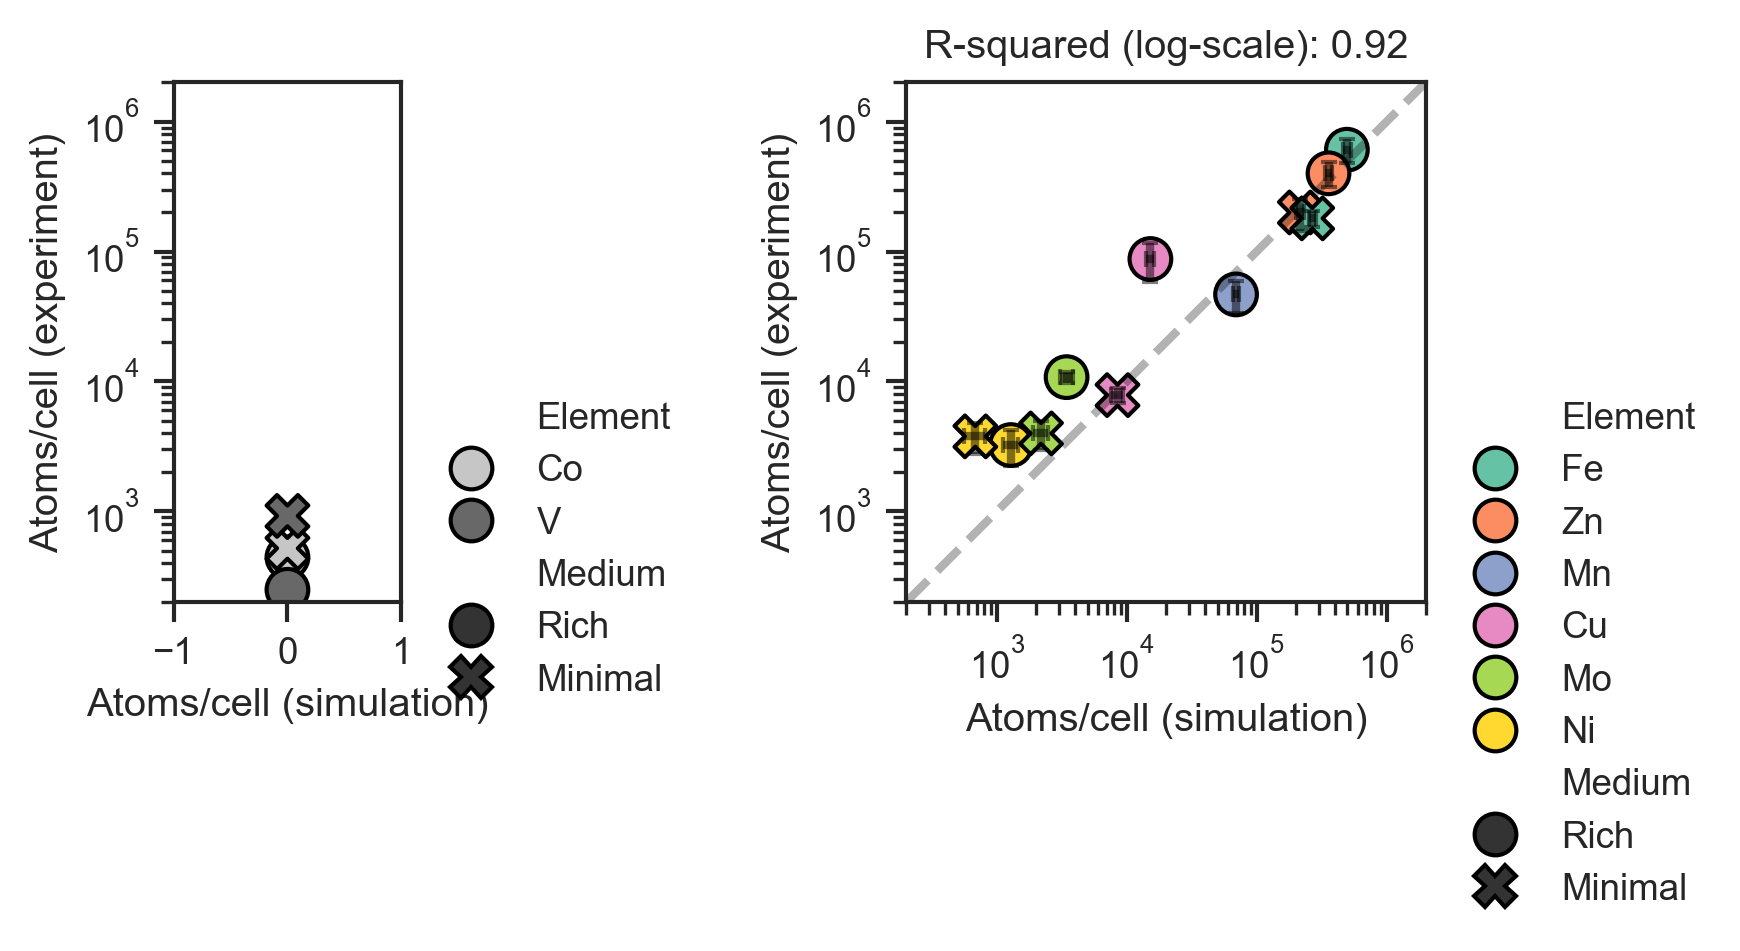

In [26]:
filter_df = final_df_both

# replace element names with properly capitalized names

filter_df = filter_df.with_columns(pl.col("Element").replace(element_display_dict).alias("Element"))

# create pointplot with error bars
f, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=[6,3] )


elements = ["V", "Co"]
g1 = sns.scatterplot(data=filter_df.filter(pl.col("Element").is_in(elements)).to_pandas(), x="Atoms/cell (simulation)", y="Atoms/cell (experiment)",
                 s=100, ax=ax[0], hue= "Element", style="Medium", palette="Greys", edgecolor='black', linewidth=1)

ax[0].set_yscale("log")
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(200, 2*10**6)


elements = ["Fe", "Zn", "Mn", "Cu", "Mo", "Ni"]



g2 = sns.scatterplot(data=filter_df.filter(pl.col("Element").is_in(elements)).to_pandas(), x="Atoms/cell (simulation)", y="Atoms/cell (experiment)", hue="Element", style="Medium", hue_order=elements, s=100, ax=ax[1], edgecolor='black', linewidth=1)

sns.move_legend(g1, "upper left", bbox_to_anchor=(1., .45), frameon=False)
sns.move_legend(g2, "upper left", bbox_to_anchor=(1., .45), frameon=False)
    

# add error bars
for i in range(filter_df.shape[0]):
    ax[1].errorbar(filter_df["Atoms/cell (simulation)"][i], 
                   filter_df["Atoms/cell (experiment)"][i], 
                 xerr=filter_df["Atoms/cell (simulation), stddev"][i], yerr=filter_df["Atoms/cell (experiment), stddev"][i], 
                 color='black', alpha=0.5, capsize=2, capthick=1, elinewidth=2)


filter_df = filter_df.filter(pl.col("Element").is_in(elements))

# log scale
ax[1].set_xscale("log")
ax[1].set_yscale("log")

# axis range from 100 to 10^6
ax[1].set_xlim(200, 2*10**6)
ax[1].set_ylim(200, 2*10**6)

# make both axes equal
plt.gca().set_aspect('equal', adjustable='box')

# create a x=y line 
ax[1].plot([200, 2*10**6], [200, 2*10**6], color='black', linestyle='--', alpha=0.3, linewidth=2)

# add r-squared for the log-log plot
x = filter_df["Atoms/cell (simulation)"].to_numpy()
y = filter_df["Atoms/cell (experiment)"].to_numpy()
params = stats.linregress(np.log10(x), np.log10(y))

# write rsquared in title
ax[1].set_title(f"R-squared (log-scale): {(params.rvalue)**2:.2f}")

# sns.despine(offset=2, trim=False)
f.tight_layout()

# save as png and svg
plt.savefig("figures/atoms_per_cell_comparison.svg", transparent=True)

# Volumetric concentration constant across conditions

# Calculate ranges

In [26]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]

# filter big_element_df_rich to only include volume, element, atoms/cell
big_element_df_rich_f = big_element_df_rich.filter(pl.col("Element").is_in(elements)).select(["Volume", "Element", "Atoms/cell"])
big_element_df_min_f = big_element_df_min.filter(pl.col("Element").is_in(elements)).select(["Volume", "Element", "Atoms/cell"])

# calculate atoms/cell volume
big_element_df_rich_f = big_element_df_rich_f.with_columns( (big_element_df_rich_f["Atoms/cell"] / big_element_df_rich_f["Volume"]).alias("Atoms/cell volume (1/fL)"))
big_element_df_min_f = big_element_df_min_f.with_columns( (big_element_df_min_f["Atoms/cell"] / big_element_df_min_f["Volume"]).alias("Atoms/cell volume (1/fL)"))

# add condition column
big_element_df_rich_f = big_element_df_rich_f.with_columns(pl.lit("Rich").alias("Condition"))
big_element_df_min_f = big_element_df_min_f.with_columns(pl.lit("Minimal").alias("Condition"))

# concatenate the two dataframes
big_element_df_f = pl.concat([big_element_df_rich_f, big_element_df_min_f])

# groupby condition and element, and calculate the min and max
range_df = big_element_df_f.group_by(["Condition", "Element"]).agg(pl.min("Atoms/cell volume (1/fL)").alias("Min atoms/cell volume (1/fL)"), pl.max("Atoms/cell volume (1/fL)").alias("Max atoms/cell volume (1/fL)"))

# pivot the dataframe
range_df_min = range_df.pivot("Min atoms/cell volume (1/fL)",  "Element", "Condition")
range_df_max = range_df.pivot("Max atoms/cell volume (1/fL)",  "Element", "Condition")

# sort by counts in minimal
range_df_min = range_df_min.sort("Minimal", descending=True)
range_df_max = range_df_max.sort("Minimal", descending=True)

range_df_min

shape: (6, 3)
┌─────────┬───────────────┬───────────────┐
│ Element ┆ Minimal       ┆ Rich          │
│ ---     ┆ ---           ┆ ---           │
│ str     ┆ f64           ┆ f64           │
╞═════════╪═══════════════╪═══════════════╡
│ FE      ┆ 170500.58269  ┆ 151872.804669 │
│ ZN      ┆ 140370.420832 ┆ 111910.519641 │
│ MN      ┆ 22636.644884  ┆ 20631.221232  │
│ CU      ┆ 5029.061089   ┆ 4373.203694   │
│ MO      ┆ 1205.933846   ┆ 795.924046    │
│ NI      ┆ 256.470851    ┆ 299.003659    │
└─────────┴───────────────┴───────────────┘

In [27]:
# join filter_df and bulk_vol_avg on Condition column
conc_compare_df = final_df_all.join(bulk_vol_avg, on="Condition")

# filter out V, CR
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
conc_compare_df = conc_compare_df.filter(pl.col("Element").is_in(elements))

# drop experimental colums
conc_compare_df = conc_compare_df.drop(["Atoms/cell (experiment)", "Atoms/cell (experiment), stddev"])

# make a new column, "Atoms/cell volume (1/fL)"
conc_compare_df = conc_compare_df.with_columns( (conc_compare_df["Atoms/cell (simulation)"] / conc_compare_df["Volume/cell (fL)"]).alias("Atoms/cell volume (1/fL)"))
conc_compare_df = conc_compare_df.with_columns( (conc_compare_df["Atoms/cell (simulation), stddev"] / conc_compare_df["Volume/cell (fL)"]).alias("Atoms/cell volume error (1/fL)"))


conc_compare_df

shape: (12, 7)
┌─────────┬───────────────┬───────────────┬───────────┬──────────────┬──────────────┬──────────────┐
│ Element ┆ Atoms/cell    ┆ Atoms/cell    ┆ Condition ┆ Volume/cell  ┆ Atoms/cell   ┆ Atoms/cell   │
│ ---     ┆ (simulation)  ┆ (simulation), ┆ ---       ┆ (fL)         ┆ volume       ┆ volume error │
│ str     ┆ ---           ┆ stdde…        ┆ str       ┆ ---          ┆ (1/fL)       ┆ (1/fL)       │
│         ┆ f64           ┆ ---           ┆           ┆ f64          ┆ ---          ┆ ---          │
│         ┆               ┆ f64           ┆           ┆              ┆ f64          ┆ f64          │
╞═════════╪═══════════════╪═══════════════╪═══════════╪══════════════╪══════════════╪══════════════╡
│ ZN      ┆ 357249.636639 ┆ 22782.838522  ┆ Rich      ┆ 3.073264     ┆ 116244.35862 ┆ 7413.237636  │
│         ┆               ┆               ┆           ┆              ┆ 4            ┆              │
│ NI      ┆ 1284.841822   ┆ 176.78077     ┆ Rich      ┆ 3.073264     ┆ 418.070722   ┆ 57.52215     │
│ FE      ┆ 494684.179294 ┆ 34074.181705  ┆ Rich      ┆ 3.073264     ┆ 160963.76104 ┆ 11087.293007 │
│ MO      ┆ 3444.940736   ┆ 394.060051    ┆ Rich      ┆ 3.073264     ┆ 1120.938653  ┆ 128.221986   │
│ MN      ┆ 69398.444095  ┆ 3754.98889    ┆ Rich      ┆ 3.073264     ┆ 22581.345916 ┆ 1221.824266  │
│ …       ┆ …             ┆ …             ┆ …         ┆ …            ┆ …            ┆ …            │
│ CU      ┆ 8494.231262   ┆ 862.443333    ┆ Minimal   ┆ 1.44983      ┆ 5858.777429  ┆ 594.858249   │
│ NI      ┆ 684.082189    ┆ 125.737464    ┆ Minimal   ┆ 1.44983      ┆ 471.83614    ┆ 86.72566     │
│ FE      ┆ 267598.232091 ┆ 16974.659764  ┆ Minimal   ┆ 1.44983      ┆ 184572.14478 ┆ 11708.034598 │
│         ┆               ┆               ┆           ┆              ┆ 1            ┆              │
│ MO      ┆ 2190.045015   ┆ 274.20151     ┆ Minimal   ┆ 1.44983      ┆ 1510.552975  ┆ 189.126663   │
│ MN      ┆ 36049.755197  ┆ 2324.314223   ┆ Minimal   ┆ 1.44983      ┆ 24864.815375 ┆ 1603.163287  │
└─────────┴───────────────┴───────────────┴───────────┴──────────────┴──────────────┴──────────────┘

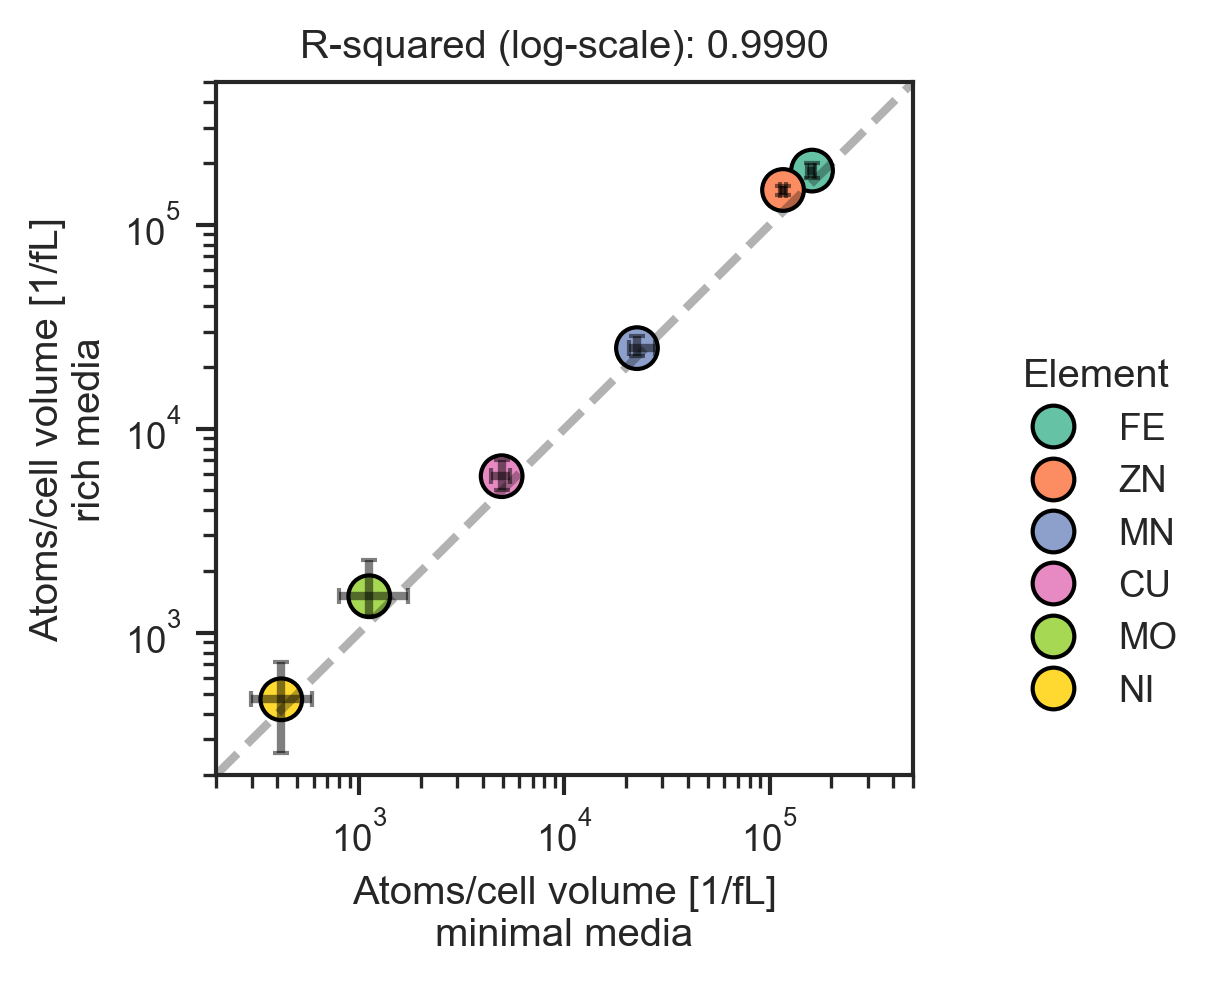

In [28]:
# scatterplot of atoms/cell volume for rich and minimal
plt.figure(figsize=(3, 3))

# use polars pivot to get separate columns for rich and minimal 
conc_compare_df_pivot = conc_compare_df.pivot( "Atoms/cell volume (1/fL)",  "Element", "Condition")

# sort by counts in minimal
conc_compare_df_pivot = conc_compare_df_pivot.sort("Minimal", descending=True)

# same for error
conc_compare_df_pivot_error = conc_compare_df.pivot( "Atoms/cell volume error (1/fL)",  "Element", "Condition")

# plot pivot df as scatter
g = sns.scatterplot(data=conc_compare_df_pivot.to_pandas(), x="Rich", y="Minimal", hue="Element",  s=100, edgecolor='black', linewidth=1, hue_order=elements)

sns.move_legend(g, "upper left", bbox_to_anchor=(1.1, .65), frameon=False)

# use range_df_min and range_df_max to plot error bars
for i in range(conc_compare_df_pivot.shape[0]):
    g.errorbar(conc_compare_df_pivot["Rich"][i], conc_compare_df_pivot["Minimal"][i], 
                 xerr=[[conc_compare_df_pivot["Rich"][i] - range_df_min["Rich"][i]], [range_df_max["Rich"][i]-conc_compare_df_pivot["Rich"][i]]], 
                 yerr=[[conc_compare_df_pivot["Minimal"][i]-range_df_min["Minimal"][i]], [range_df_max["Minimal"][i] -conc_compare_df_pivot["Minimal"][i]]], 
                 color='black', alpha=0.5, capsize=2, capthick=1, elinewidth=2)


# add r-squared for the log-log plot
x = conc_compare_df_pivot["Rich"].to_numpy()
y = conc_compare_df_pivot["Minimal"].to_numpy()
params = stats.linregress(np.log10(x), np.log10(y))

# write rsquared in title
plt.title(f"R-squared (log-scale): {(params.rvalue)**2:.4f}")


# create a x=y line 
plt.plot([200, 2*10**6], [200, 2*10**6], color='black', linestyle='--', alpha=0.3, linewidth=2)

plt.xlim(200, 5*10**5)
plt.ylim(200, 5*10**5)

plt.yscale("log")
plt.xscale("log")

# change x and y label
plt.xlabel("Atoms/cell volume [1/fL]\nminimal media")
plt.ylabel("Atoms/cell volume [1/fL]\nrich media")

# save as png and svg
plt.savefig("figures/volume_per_cell_comparison.png", transparent=True)
plt.savefig("figures/volume_per_cell_comparison.svg", transparent=True)

## show that composition is markedly different

In [29]:
element = "ZN"
element_indices = [np.where(element_ids == element)[0][0]]

# get average protein counts / cell for rich and minimal
avg_counts_rich = total_counts_big[:, 1:-1].mean(axis=0) / total_vol_rich.mean(axis=0)[1]
avg_counts_min = total_counts_big_min[:, 1:-1].mean(axis=0) / total_vol_min.mean(axis=0)[1]

# get protein - element mapping by diagonalizing and multiplying
protein_element_rich = (np.diag(avg_counts_rich) @ C @ P @ E[:, element_indices]).flatten()
protein_element_min = (np.diag(avg_counts_min) @ C @ P @ E[:, element_indices]).flatten()

# create a dataframe with protein ids and protein counts
element_df = pl.DataFrame(np.array([protein_ids, protein_element_rich, protein_element_min]), schema=["Protein ID", "Rich", "Minimal"])

# convert rich and minimal to float
element_df = element_df.with_columns( (element_df["Rich"].cast(pl.Float64)).alias("Rich"))
element_df = element_df.with_columns( (element_df["Minimal"].cast(pl.Float64)).alias("Minimal"))

# if both rich and minimal are zero, remove them.
element_df = element_df.filter((pl.col("Rich") != 0) | (pl.col("Minimal") != 0))

# argsort by rich
element_df = element_df.sort("Minimal")
sorted_names = element_df["Protein ID"].to_list()

# melt rich and minimal
element_df = element_df.melt(id_vars=["Protein ID"], value_name="Count/volume", variable_name="Condition")

element_df

shape: (478, 3)
┌────────────────────┬───────────┬──────────────┐
│ Protein ID         ┆ Condition ┆ Count/volume │
│ ---                ┆ ---       ┆ ---          │
│ str                ┆ str       ┆ f64          │
╞════════════════════╪═══════════╪══════════════╡
│ PD01896            ┆ Rich      ┆ 0.017662     │
│ TDK-MONOMER        ┆ Rich      ┆ 0.079094     │
│ EG10484-MONOMER    ┆ Rich      ┆ 0.044812     │
│ EG11312-MONOMER    ┆ Rich      ┆ 0.172607     │
│ NANK-MONOMER       ┆ Rich      ┆ 0.12953      │
│ …                  ┆ …         ┆ …            │
│ FOLE-CPLX          ┆ Minimal   ┆ 6936.289246  │
│ CPLX0-7521         ┆ Minimal   ┆ 7802.793469  │
│ FRUCBISALD-CLASSII ┆ Minimal   ┆ 12227.880422 │
│ CPLX0-3962         ┆ Minimal   ┆ 14827.741054 │
│ HOMOCYSMET-MONOMER ┆ Minimal   ┆ 28765.463235 │
└────────────────────┴───────────┴──────────────┘

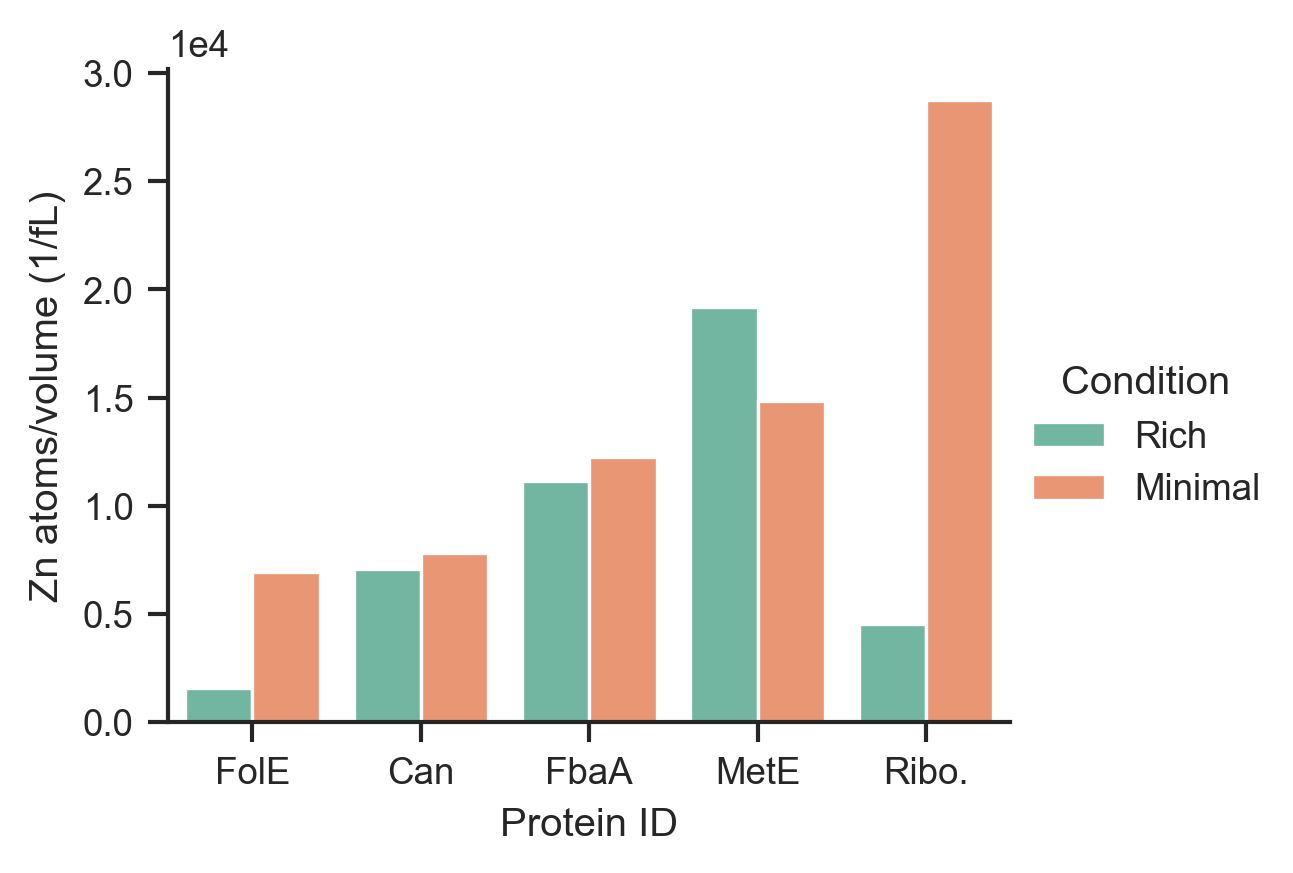

In [30]:
changed_xticks = [#"PyrC", "RNA Pol.",
                  "FolE", "Can", "FbaA", "MetE", "Ribo."]

# filter to only include last 30 proteins in sorted_names
element_df = element_df.filter(pl.col("Protein ID").is_in(sorted_names[-5:]))

# catplot
sns.catplot(data=element_df.to_pandas(), x="Protein ID", y="Count/volume", kind="bar", hue="Condition",   height=3, aspect=1.2,
             order = sorted_names[-5:], alpha=1)

# change xticks
plt.xticks(ticks=range(5), labels=changed_xticks)

# change ylabel to "Zn atoms/volume (1/fL)"
plt.ylabel("Zn atoms/volume (1/fL)")

# title
#plt.title("Zinc atoms/volume for last 7 proteins")

# rotate by 45 and have right side of word align
plt.xticks(rotation=0, ha="center")

# save as png and svg
plt.savefig("figures/zinc_protein_comparison.png")
plt.savefig("figures/zinc_protein_comparison.svg")

In [31]:
element = "ZN"
element_indices = [np.where(element_ids == element)[0][0]]

# get average protein counts / cell for rich and minimal
avg_counts_rich = total_counts_big[:, 1:-1].mean(axis=0)
avg_counts_min = total_counts_big_min[:, 1:-1].mean(axis=0)

# get protein - element mapping by diagonalizing and multiplying
protein_element_rich = (np.diag(avg_counts_rich) @ C @ P @ E[:, element_indices]).flatten()
protein_element_min = (np.diag(avg_counts_min) @ C @ P @ E[:, element_indices]).flatten()

# divide by sum
protein_element_rich = protein_element_rich / protein_element_rich.sum()
protein_element_min = protein_element_min / protein_element_min.sum()

# create a dataframe with protein ids and protein counts
element_df = pl.DataFrame(np.array([protein_ids, protein_element_rich, protein_element_min]), schema=["Protein ID", "Rich", "Minimal"])

# convert rich and minimal to float
element_df = element_df.with_columns( (element_df["Rich"].cast(pl.Float64)).alias("Rich"))
element_df = element_df.with_columns( (element_df["Minimal"].cast(pl.Float64)).alias("Minimal"))

# if both rich and minimal are zero, remove them.
element_df = element_df.filter((pl.col("Rich") != 0) | (pl.col("Minimal") != 0))

# argsort by rich
element_df = element_df.sort("Minimal")
sorted_names = element_df["Protein ID"].to_list()

# melt rich and minimal
element_df = element_df.melt(id_vars=["Protein ID"], value_name="Zn mass fraction", variable_name="Condition")

element_df

shape: (478, 3)
┌────────────────────┬───────────┬──────────────────┐
│ Protein ID         ┆ Condition ┆ Zn mass fraction │
│ ---                ┆ ---       ┆ ---              │
│ str                ┆ str       ┆ f64              │
╞════════════════════╪═══════════╪══════════════════╡
│ PD01896            ┆ Rich      ┆ 1.5178e-7        │
│ TDK-MONOMER        ┆ Rich      ┆ 6.7971e-7        │
│ EG10484-MONOMER    ┆ Rich      ┆ 3.8510e-7        │
│ EG11312-MONOMER    ┆ Rich      ┆ 0.000001         │
│ NANK-MONOMER       ┆ Rich      ┆ 0.000001         │
│ …                  ┆ …         ┆ …                │
│ FOLE-CPLX          ┆ Minimal   ┆ 0.046924         │
│ CPLX0-7521         ┆ Minimal   ┆ 0.052786         │
│ FRUCBISALD-CLASSII ┆ Minimal   ┆ 0.082722         │
│ CPLX0-3962         ┆ Minimal   ┆ 0.10031          │
│ HOMOCYSMET-MONOMER ┆ Minimal   ┆ 0.1946           │
└────────────────────┴───────────┴──────────────────┘

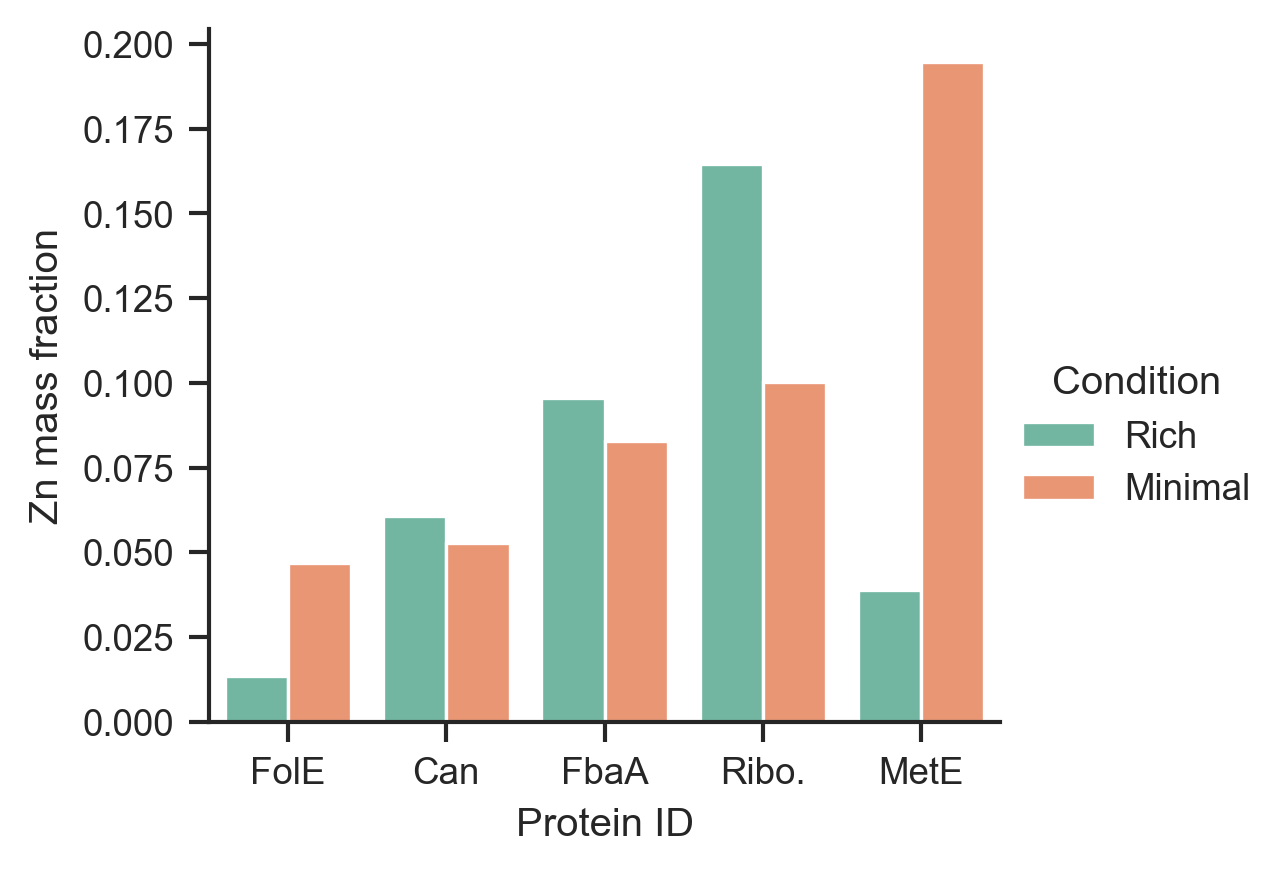

In [32]:
changed_xticks = [#"PyrC", "RNA Pol.", 
                  "FolE", "Can", "FbaA", "Ribo.", "MetE"]

# filter to only include last 30 proteins in sorted_names
element_df = element_df.filter(pl.col("Protein ID").is_in(sorted_names[-5:]))

# catplot 
sns.catplot(data=element_df.to_pandas(), x="Protein ID", y="Zn mass fraction", kind="bar", hue="Condition",   height=3, aspect=1.2,
             order = sorted_names[-5:], alpha=1)

# change xticks
plt.xticks(ticks=range(5), labels=changed_xticks)

# change ylabel to "Zn atoms/volume (1/fL)"
plt.ylabel("Zn mass fraction")

# title
#plt.title("Zinc atoms/volume for last 7 proteins")

# rotate by 45 and have right side of word align
plt.xticks(rotation=0, ha="center")

# save as png and svg
plt.savefig("figures/zinc_protein_comparison.png", transparent=True)
plt.savefig("figures/zinc_protein_comparison.svg", transparent=True)

# Single-cell data

In [33]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sc_df = pl.read_csv('external_data/single_cell_fe.csv')

# remove the first row
# sc_df = sc_df.filter((pl.col("Bin") > 16) & (pl.col("Bin") < 60))

# create 1d list of all bins with comprehension
bins = sc_df["Bin"].to_numpy()
counts = sc_df["Count"].to_numpy()

# create a list with bin value repeated counts times
real_hist_data = np.repeat(bins, counts)

In [34]:
# compute the timeseries for the elements
big_element_timeseries = total_counts_big[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_big[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

## Calculate wasserstein metric for display on plot

In [35]:
# filter FE 
big_fe_df = big_element_df.filter(pl.col("Element") == "FE")

# convert atoms/cell to float
big_fe_df = big_fe_df.with_columns( (big_fe_df["Atoms/cell"] * 55.85 * 10**18 * 0.92 / (6.023*10**23)).alias("Fe-56 (ag)"))

In [36]:
from scipy.stats import wasserstein_distance

# real_hist_data_atoms 

# calculate between big_fe_df and real_hist_df
wasserstein_distance(big_fe_df["Fe-56 (ag)"].to_numpy(), real_hist_data)

10.096105524356812

In [37]:
big_fe_df

shape: (26_256, 5)
┌────────────┬────────────────────┬─────────┬────────────┬────────────┐
│ Cell index ┆ Density correction ┆ Element ┆ Atoms/cell ┆ Fe-56 (ag) │
│ ---        ┆ ---                ┆ ---     ┆ ---        ┆ ---        │
│ i64        ┆ f64                ┆ str     ┆ i64        ┆ f64        │
╞════════════╪════════════════════╪═════════╪════════════╪════════════╡
│ 0          ┆ 2.0                ┆ FE      ┆ 412713     ┆ 35.2084    │
│ 0          ┆ 1.998924           ┆ FE      ┆ 412888     ┆ 35.223329  │
│ 0          ┆ 1.997849           ┆ FE      ┆ 413032     ┆ 35.235614  │
│ 0          ┆ 1.996774           ┆ FE      ┆ 413217     ┆ 35.251396  │
│ 0          ┆ 1.995699           ┆ FE      ┆ 413337     ┆ 35.261633  │
│ …          ┆ …                  ┆ …       ┆ …          ┆ …          │
│ 18         ┆ 1.001982           ┆ FE      ┆ 683842     ┆ 58.338319  │
│ 18         ┆ 1.001486           ┆ FE      ┆ 684169     ┆ 58.366215  │
│ 18         ┆ 1.000991           ┆ FE      ┆ 684559     ┆ 58.399486  │
│ 18         ┆ 1.000495           ┆ FE      ┆ 684879     ┆ 58.426785  │
│ 18         ┆ 1.0                ┆ FE      ┆ 685191     ┆ 58.453402  │
└────────────┴────────────────────┴─────────┴────────────┴────────────┘

# Calculate means and stdev for sim, ohalloran and single cell to show differences

In [38]:
# calculate weighted mean after grouping by cell
big_fe_df = big_fe_df.with_columns( (big_fe_df["Fe-56 (ag)"] * big_fe_df["Density correction"]).alias("Weighted Fe-56 (ag)"))
big_fe_mean_df = big_fe_df.group_by("Cell index").agg(pl.sum("Weighted Fe-56 (ag)").alias("Fe-56 (ag)"), pl.sum("Density correction").alias("Density correction"))

# divide by density correction
big_fe_mean_df = big_fe_mean_df.with_columns( (big_fe_mean_df["Fe-56 (ag)"] / big_fe_mean_df["Density correction"]).alias("Fe-56 (ag)")).drop(["Density correction"])

# calculate mean and stdev for Fe-56 (ag)
big_fe_sample_df = big_fe_df.to_pandas().sample(weights="Density correction", n=1000)



bulk_fe_measurement = (final_df_all.filter((pl.col("Element") == "FE") & (pl.col("Condition") == "Rich")).select(["Atoms/cell (experiment)", "Atoms/cell (experiment), stddev"]).to_numpy().flatten() * 55.85 * 10**18 * 0.92 / (6.023*10**23) ).tolist()

sc_bulk_comparison = [ 
    [np.mean(big_fe_sample_df["Fe-56 (ag)"].to_numpy()), np.std(big_fe_sample_df["Fe-56 (ag)"].to_numpy()), "Simulation", 1],
    [bulk_fe_measurement[0], bulk_fe_measurement[1], "Bulk experiment", 0],
    [np.mean(real_hist_data), np.std(real_hist_data)
     # / np.sqrt(len(real_hist_data))
        , 
     "Single-cell experiment", 2],
]

# make dataframe
sc_bulk_comparison_df = pl.DataFrame(sc_bulk_comparison, schema=["Mean Fe-56 (ag)", "Stdev (ag)", "Source", "Index"])

# create a column that's atoms/cell
sc_bulk_comparison_df = sc_bulk_comparison_df.with_columns( (sc_bulk_comparison_df["Mean Fe-56 (ag)"] / (55.85 * 10**18) * (6.023*10**23)).alias("Fe-56 atoms/cell"))

# do the same for stdev
sc_bulk_comparison_df = sc_bulk_comparison_df.with_columns( (sc_bulk_comparison_df["Stdev (ag)"] / (55.85 * 10**18) * (6.023*10**23)).alias("Stdev atoms/cell"))


# same for real_hist_data
real_hist_data_atoms = real_hist_data / (55.85 * 10**18) * (6.023*10**23)

# make sampling df
sampling_df = big_fe_df.group_by("Cell index").agg(pl.col(['Fe-56 (ag)', 'Density correction']).shuffle().head(3)).explode(["Fe-56 (ag)", "Density correction"])
sc_bulk_comparison_df



# for big_fe_df rename Atoms/cell to Fe-56 atoms/cell
big_fe_df = big_fe_df.rename({"Atoms/cell": "Fe-56 atoms/cell"})


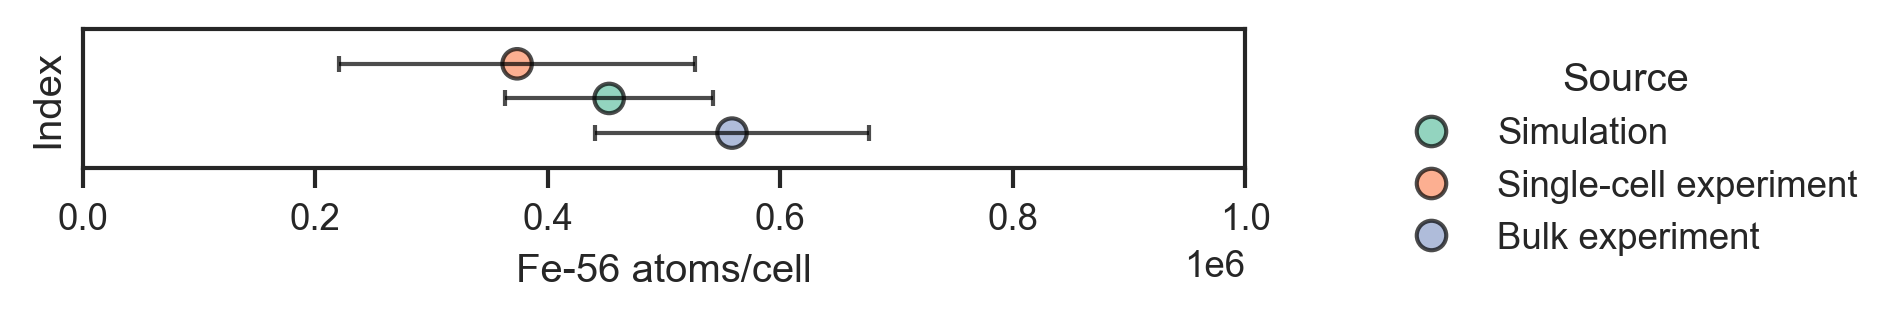

In [39]:
# plot the means and stdevs as 1d scatter with error bars
plt.figure(figsize=(5, 0.6))
g = sns.scatterplot(data=sc_bulk_comparison_df.to_pandas(), x="Fe-56 atoms/cell", y="Index", hue="Source", palette="Set2", alpha=0.7, s=50, hue_order = ["Simulation",   "Single-cell experiment","Bulk experiment",], edgecolor='black', linewidth=1)
# sns.scatterplot(data=sampling_df.to_pandas(), x="Fe-56 (ag)", y=0, color='gray', alpha=0.3)

# legend outside
sns.move_legend(g, "upper left", bbox_to_anchor=(1.1, 1), frameon=False)

# add error bars
for i in range(sc_bulk_comparison_df.shape[0]):
    g.errorbar(sc_bulk_comparison_df["Fe-56 atoms/cell"][i], 
                 sc_bulk_comparison_df["Index"][i], 
                 xerr=sc_bulk_comparison_df["Stdev atoms/cell"][i], 
                 color='black', alpha=0.7, capsize=2, capthick=1, elinewidth=1)
    
# set xlim
plt.xlim(0, 1e6)
plt.ylim(-1, 3)

# ygrid off
plt.yticks([])

# save as svg
plt.savefig("figures/fe_single_cell_comparison_means.svg", transparent=True)

In [40]:
sc_bulk_comparison_df

shape: (3, 6)
┌─────────────────┬────────────┬─────────────────┬───────┬──────────────────┬──────────────────┐
│ Mean Fe-56 (ag) ┆ Stdev (ag) ┆ Source          ┆ Index ┆ Fe-56 atoms/cell ┆ Stdev atoms/cell │
│ ---             ┆ ---        ┆ ---             ┆ ---   ┆ ---              ┆ ---              │
│ f64             ┆ f64        ┆ str             ┆ i64   ┆ f64              ┆ f64              │
╞═════════════════╪════════════╪═════════════════╪═══════╪══════════════════╪══════════════════╡
│ 41.994999       ┆ 8.287007   ┆ Simulation      ┆ 1     ┆ 452884.29404     ┆ 89369.102577     │
│ 51.79517        ┆ 10.923643  ┆ Bulk experiment ┆ 0     ┆ 558571.729741    ┆ 117803.230543    │
│ 34.654428       ┆ 14.183669  ┆ Single-cell     ┆ 2     ┆ 373721.786411    ┆ 152960.144069    │
│                 ┆            ┆ experiment      ┆       ┆                  ┆                  │
└─────────────────┴────────────┴─────────────────┴───────┴──────────────────┴──────────────────┘

# Scope of interactions

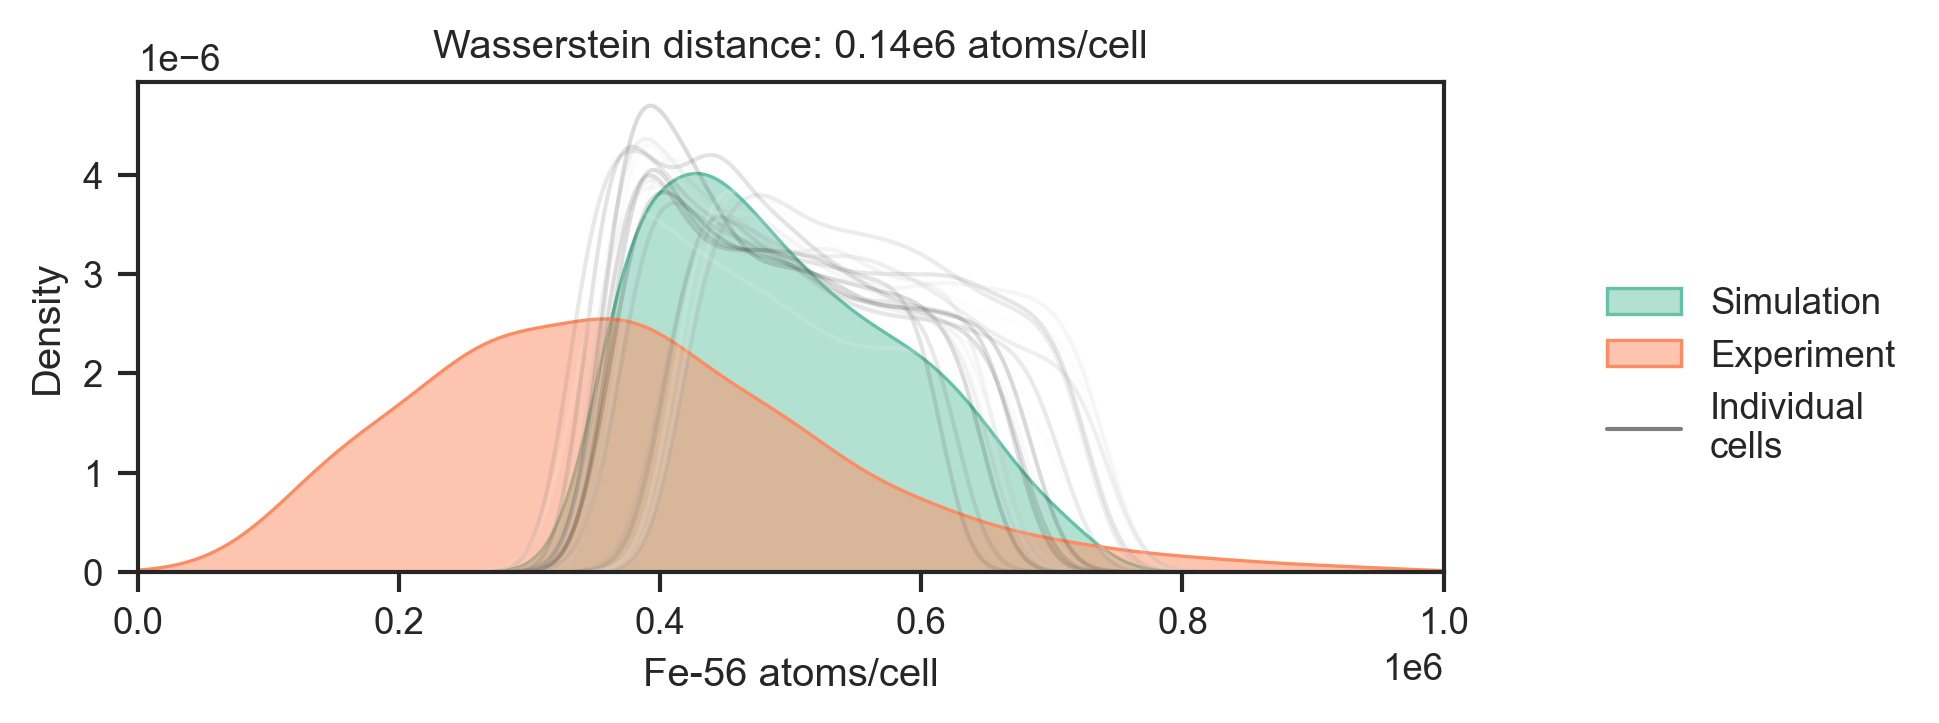

In [41]:

# create fig
plt.figure(figsize=(5, 2.5))


# plot individual cell traces
g =   sns.kdeplot(data=big_fe_df.to_pandas(), x="Fe-56 atoms/cell", hue="Cell index", fill=False,  
            alpha=0.15, color='gray', linewidth=1, legend=False, common_norm=False, palette="Grays")

# create a weighted KDE plot 
sns.kdeplot(data=big_fe_df.to_pandas(), x="Fe-56 atoms/cell", weights="Density correction", fill=True, bw_adjust=2, label="Simulation", alpha=0.5)
# sns.histplot(data=big_fe_df.to_pandas(), x="Fe-56 (ag)", weights="Density correction",stat="density", binwidth=10, alpha=0.5, label="Aggregate sim")


# plot histogram data in sc_df, as lineplot with fill
sns.kdeplot(data=real_hist_data_atoms, fill=True, bw_adjust=1.3, label="Experiment", alpha=0.5)

# add title with wasserstein distance
# plt.title(f"Wasserstein distance: {wasserstein_distance(big_fe_df['Fe-56 atoms/cell'].to_numpy(), real_hist_data_atoms):.2f} atoms/cell")
plt.title("Wasserstein distance: 0.14e6 atoms/cell")

# add legend entry for individual traces
plt.plot([], [], color='gray', alpha=1, label="Individual\ncells", linewidth=1)

plt.legend()

plt.tight_layout()


sns.move_legend(g, "upper left", bbox_to_anchor=(1.1, .65), frameon=False)

# set xlim
plt.xlim(0, 1e6)

# save as png and svg
plt.savefig("figures/fe_scdist.svg", transparent=True)

In [42]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

nonzero_cplx = np.array(((C @ P @ E)[:, element_indices].sum(axis=1) > 0)).flatten()

interaction_matrix = (C @ P @ E)[nonzero_cplx, :][:, element_indices].toarray()

interaction_matrix.sum(axis=1)

real_data = []

# for each row in the interaction matrix, add new list to real data. 
# for each column j in the row, add j to the list (value) times
for i, row in enumerate(interaction_matrix):
    cur_list = []
    for j, value in enumerate(row):
        cur_list.extend([j] * value)
        
    real_data.append(cur_list)

real_data = real_data[:150]

# count subitems for each item
subitem_counts = np.array([len(subitems) for subitems in real_data])

# get maximum length
max_subitems_per_item = max(subitem_counts)

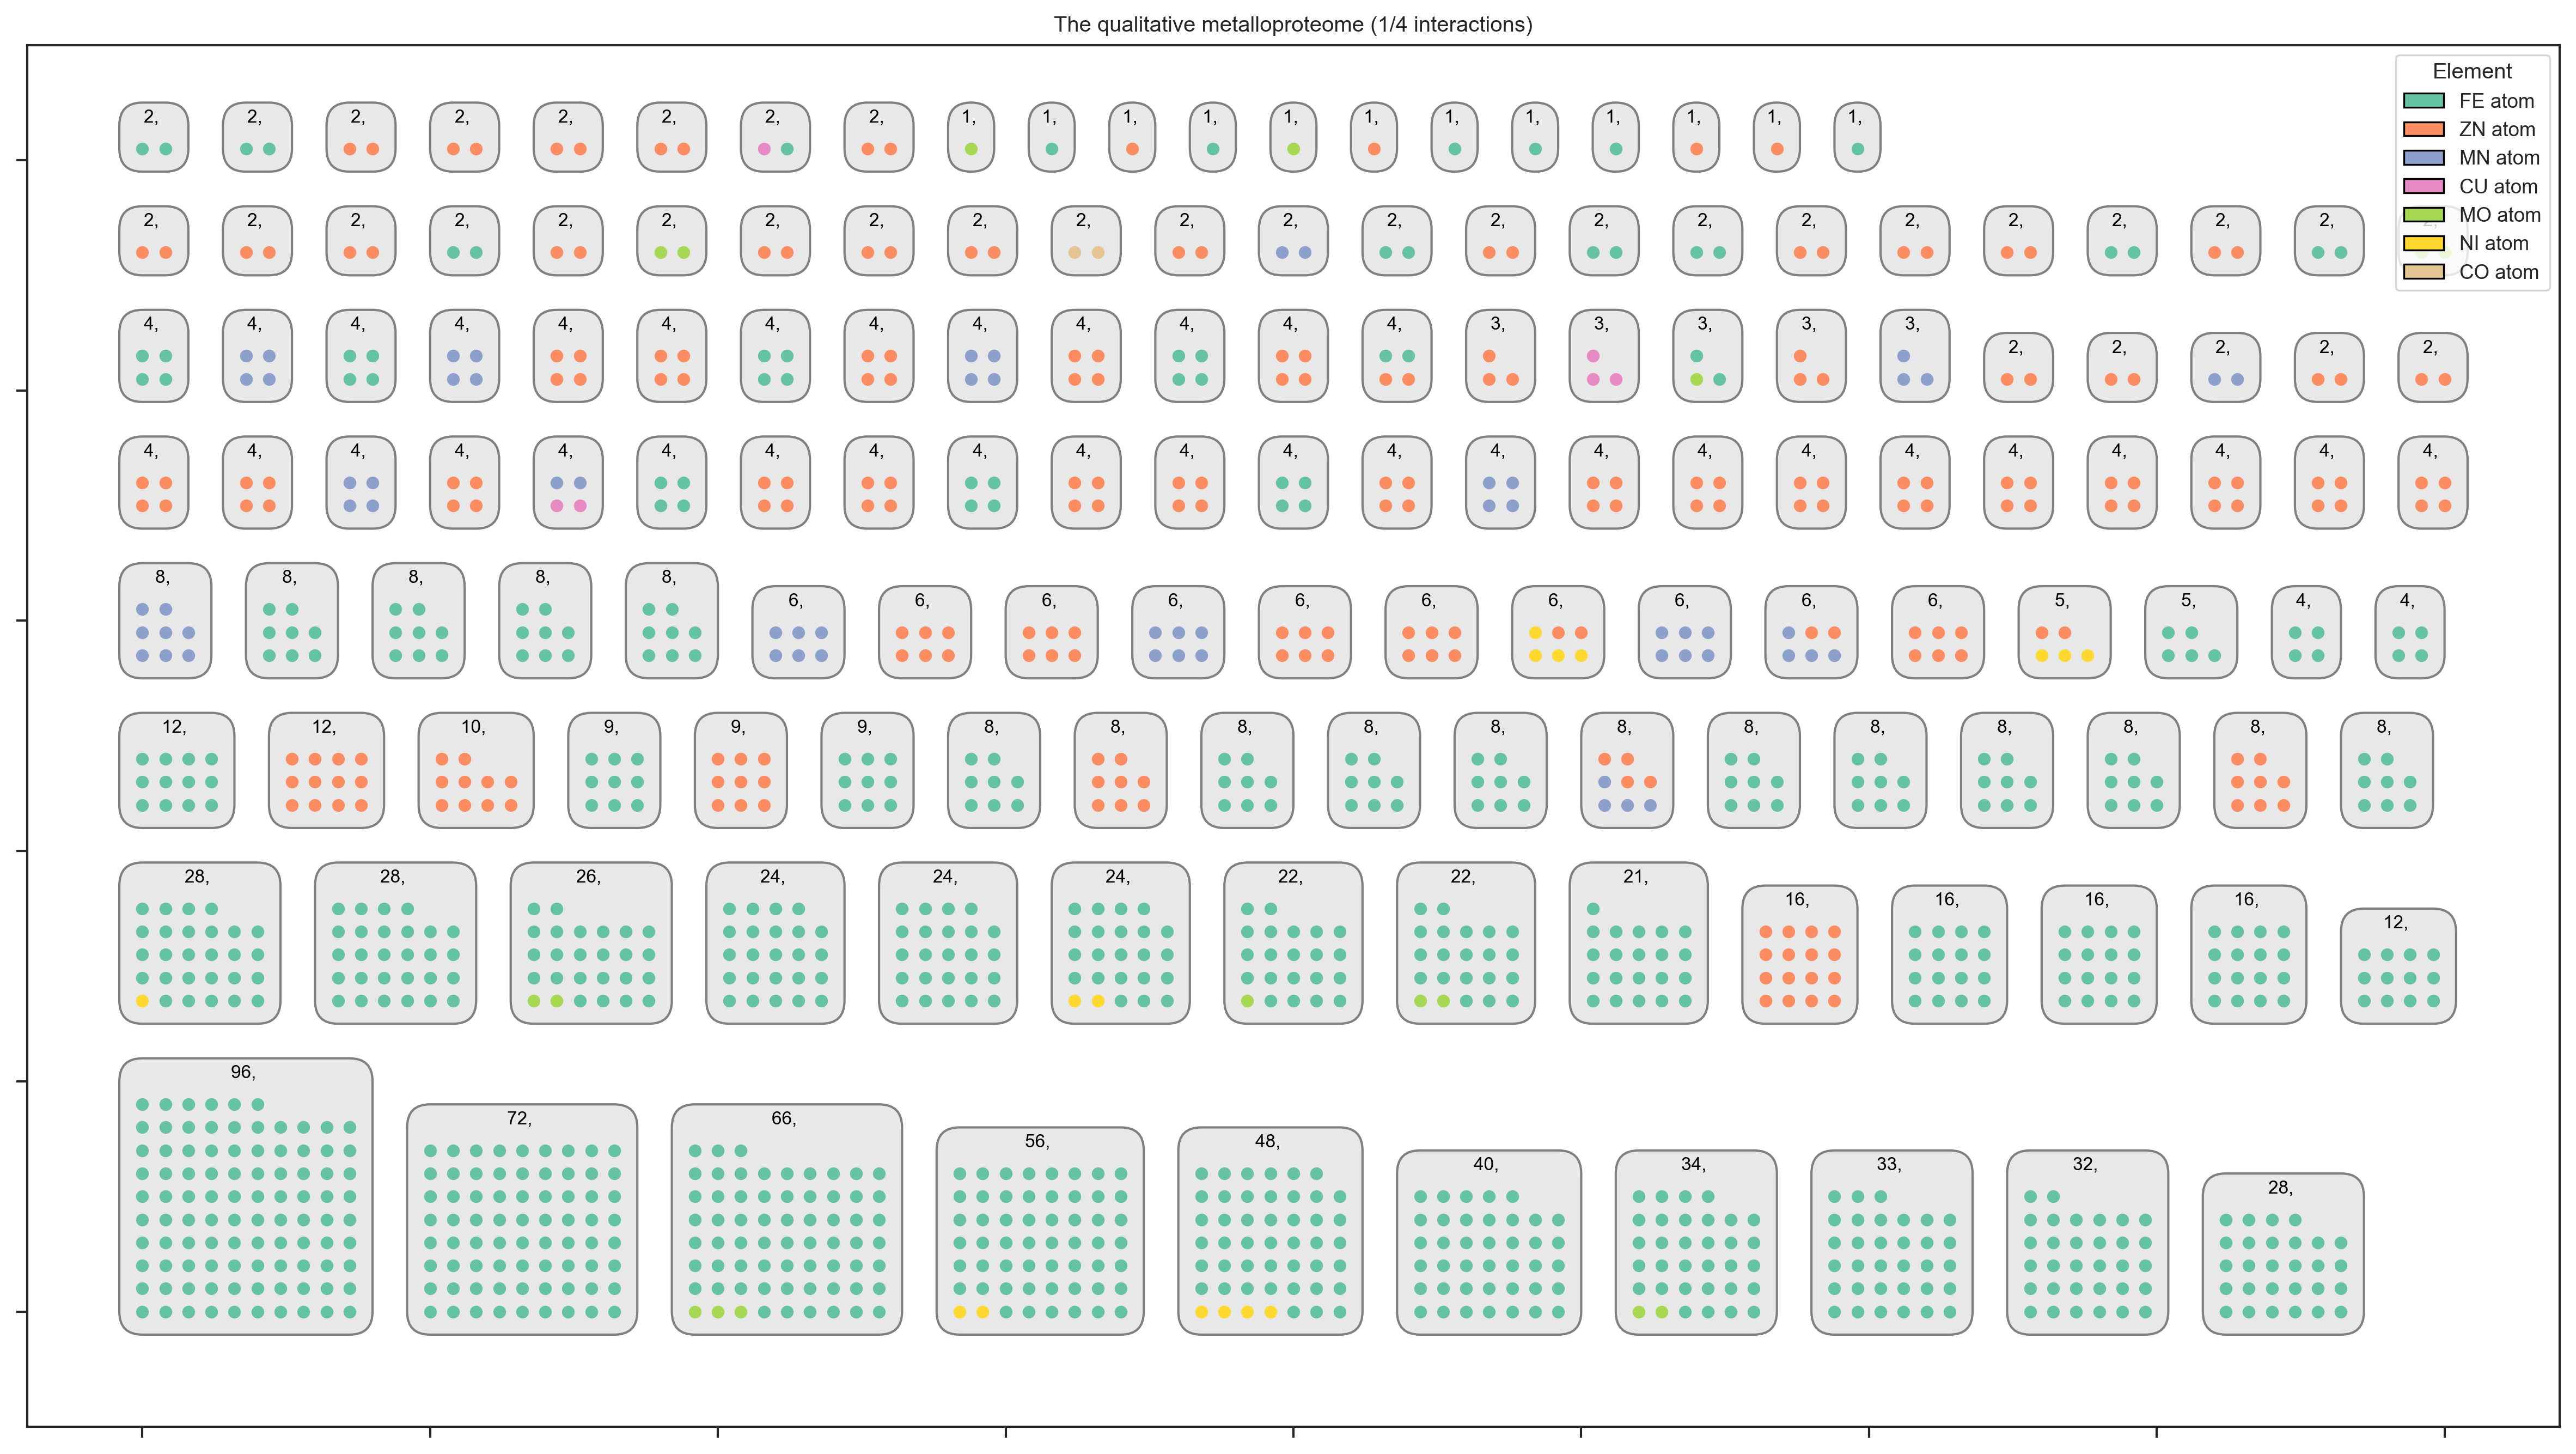

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns


# Plotting
fig, ax = plt.subplots(figsize=(20, 20))

# Parameters
num_items = 150
max_subitems_per_item = 30
base_horizontal_spacing = 0.7  # Base spacing between items horizontally
base_vertical_spacing = 0.7  # Base vertical space between items
subitem_horizontal_spacing = 0.2  # Spacing between subitems horizontally
subitem_vertical_spacing = 0.2  # Spacing between subitems vertically
padding = 0.  # Padding around the bounding box

# Define color palette
palette = sns.color_palette("Set2", 7)

# Generating random number of subitems for each item
#subitem_counts = np.random.randint(1, max_subitems_per_item + 1, size=num_items)  # Each item has between 1 and 30 subitems

# Generating presence data for subitems with 4 possible values (0 to 3)
# data = [np.random.randint(0, 4, size=subitem_counts[i]) for i in range(num_items)]
data = real_data

# Sort the items first by the total number of subitems, then by the number of blue subitems (assuming 1 is blue)
sorted_indices = sorted(range(num_items), key=lambda i: (subitem_counts[i], np.sum(data[i] == 1)), reverse=True)
sorted_data = [data[i] for i in sorted_indices]
sorted_subitem_counts = subitem_counts[sorted_indices]

# Ensure subitems within each item are sorted by presence (in this case, value from 3 to 0)
sorted_data = [sorted(subitems, reverse=True) for subitems in sorted_data]


# Set equal scaling
ax.set_aspect('equal')

# Calculate required horizontal space for each item and subitems_per_line
item_widths = []
subitems_per_lines = []

for subitems in sorted_data:
    num_subitems = len(subitems)
    n = int(np.ceil(np.sqrt(num_subitems)))
    subitems_per_lines.append(n)
    item_widths.append(n * subitem_horizontal_spacing + padding * 2 - subitem_horizontal_spacing)

# Determine items per row dynamically based on their size
current_y_position = 0  # Track the current y position to space items vertically
current_x_position = 0  # Track the current x position to space items horizontally
row_height = 0  # Track the height of the current row

for item_idx, (subitems, num_subitems, item_width, subitems_per_line) in enumerate(zip(sorted_data, sorted_subitem_counts, item_widths, subitems_per_lines)):
    num_lines = (num_subitems + subitems_per_line - 1) // subitems_per_line  # Calculate the number of lines needed
    
    if current_x_position + item_width > 20:  # If adding this item exceeds the row width, move to the next row
        current_x_position = 0
        current_y_position += row_height + base_vertical_spacing
        row_height = 0  # Reset row height for the new row
    
    x_position = current_x_position
    y_position = current_y_position
    
    # Update row height if this item's height is greater
    row_height = max(row_height, num_lines * subitem_vertical_spacing + padding * 2)

    # Add text with the number of subitems above the subitems
    ax.text(x_position + item_width / 2, y_position + num_lines * subitem_vertical_spacing + padding * 1.5, f'{num_subitems}, ', va='bottom', ha='center', fontsize=8, color='black')
    
    # Draw rounded grey box with light grey background
    rect = patches.FancyBboxPatch(
        (x_position, y_position), item_width, num_lines * subitem_vertical_spacing + padding * 2, boxstyle="round,pad=0.2", linewidth=1, edgecolor='grey', facecolor=to_rgba('lightgrey', 0.5)
    )
    ax.add_patch(rect)

    # Plot each subitem in sorted order with wrapping
    for subitem_idx, presence in enumerate(subitems):
        line = subitem_idx // subitems_per_line
        position_in_line = subitem_idx % subitems_per_line
        color = palette[presence]
        ax.scatter(x_position + position_in_line * subitem_horizontal_spacing + padding, y_position + line * subitem_vertical_spacing + padding, color=color)
    


    # Update x position for the next item
    current_x_position += item_width + base_horizontal_spacing

# Labeling the plot
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('The qualitative metalloproteome (1/4 interactions)')

# Adjust the plot limits
ax.set_xlim(-1, 21)
ax.set_ylim(-1, current_y_position + row_height + base_vertical_spacing)

# remove xticklabels, yticklabels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)

# make a legend. Each of the Set2 colors is a colored dot.
legend_elements = [patches.Patch(facecolor=palette[i], edgecolor='black', label=f'{elements[i]} atom') for i in range(7)]
ax.legend(handles=legend_elements, loc='upper right', title='Element')

plt.show()


In [44]:
fig.savefig("figures/visual_metalloproteome.png")

## Generate table for Heena

In [45]:
# metal counts per protein

elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]

element_indices = [np.where(element_ids == element)[0][0] for element in elements]

count_vec = total_counts[int(total_counts.shape[0]/2), :]

metalloprotein_matrix = np.diag(count_vec @ C) @ P @ E[:, element_indices]

# convert to dataframe
metalloprotein_df = pl.DataFrame(metalloprotein_matrix, schema=elements)

# add protein id column
metalloprotein_df = metalloprotein_df.with_columns(pl.DataFrame(monomer_ids, schema=["Protein ID"]))

# save to csv
metalloprotein_df.write_csv("data/metalloprotein_df.csv", include_header=True)

# Figure 2, general insights

## Resource comparison

In [46]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

aa = ["TRP", "GLY"]
aa_indices = [np.where(aa_ids == aa)[0][0] for aa in aa]

In [47]:
median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

pe_counts = median_count @ C @ P @ E[:, element_indices]
paa_counts = (median_count @ C @ A[:, aa_indices])
pm_mass = median_count @ C * monomer_masses
resources = csr_matrix(np.stack([pe_counts[:, 0].toarray().flatten(), pe_counts[:, 1].toarray().flatten(), 
                                 paa_counts[:, 0].flatten(), paa_counts[:, 1].flatten(), pm_mass], axis=0))

# need to assign here to pathways
Pw = (C @ W @ W2) / (C @ W @ W2).sum(axis=1)

# multiply resources by Pw
Rp = resources @ Pw

In [48]:
wrapped_names = ["\n".join(wrap(text, 14)) for text in unwrapped_pathway_names]

# put in one array and convert to dataframe
resource_df = pl.DataFrame(Rp.toarray(), schema=elements + aa + ["Protein mass"])

# add protein ID column
resource_df = resource_df.with_columns(pl.DataFrame(wrapped_names, schema=["Pathway"]))

# melt df 
resource_df = resource_df.melt(value_name="Value", variable_name="Resource", id_vars="Pathway")

# groupby resource and get the sum
sum_df = resource_df.group_by("Resource").agg(pl.sum("Value").alias("Total"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_df, on="Resource")
resource_df = resource_df.with_columns( (resource_df["Value"] / resource_df["Total"]).alias("Fraction"))

# drop zero value rows
resource_df = resource_df.filter(pl.col("Value") > 0)

# groupby pathway and get the sum of fraction
sum_f_df = resource_df.group_by("Pathway").agg(pl.sum("Fraction").alias("Sum of resource fractions"))

# join with resource_df to get the percentage
resource_df = resource_df.join(sum_f_df, on="Pathway")

# drop rows with Sum of resource fractions < 0.1
resource_df_f = resource_df.filter(pl.col("Sum of resource fractions") > 0.05)

# only include the following categories:
cats = ["Translation", "Cofactor,\nCarrier, and\nVitamin\nBiosynthesis", "Electron\nTransfer\nChains", "Porin"]
resource_df_f = resource_df_f.filter(pl.col("Pathway").is_in(cats))

# only include FE, ZN, protein mass
res_cats = ["FE", "ZN", "Protein mass"]
resource_df_f = resource_df_f.filter(pl.col("Resource").is_in(res_cats))

resource_df_f

shape: (9, 6)
┌──────────────┬──────────────┬──────────────┬───────────┬──────────┬───────────────────────────┐
│ Pathway      ┆ Resource     ┆ Value        ┆ Total     ┆ Fraction ┆ Sum of resource fractions │
│ ---          ┆ ---          ┆ ---          ┆ ---       ┆ ---      ┆ ---                       │
│ str          ┆ str          ┆ f64          ┆ f64       ┆ f64      ┆ f64                       │
╞══════════════╪══════════════╪══════════════╪═══════════╪══════════╪═══════════════════════════╡
│ Electron     ┆ FE           ┆ 58305.011905 ┆ 295511.0  ┆ 0.197302 ┆ 0.248421                  │
│ Transfer     ┆              ┆              ┆           ┆          ┆                           │
│ Chains       ┆              ┆              ┆           ┆          ┆                           │
│ Cofactor,    ┆ FE           ┆ 42629.321429 ┆ 295511.0  ┆ 0.144256 ┆ 0.489193                  │
│ Carrier, and ┆              ┆              ┆           ┆          ┆                           │
│ Vitamin…     ┆              ┆              ┆           ┆          ┆                           │
│ Translation  ┆ FE           ┆ 1299.0       ┆ 295511.0  ┆ 0.004396 ┆ 0.752981                  │
│ Cofactor,    ┆ ZN           ┆ 40124.0      ┆ 234293.5  ┆ 0.171255 ┆ 0.489193                  │
│ Carrier, and ┆              ┆              ┆           ┆          ┆                           │
│ Vitamin…     ┆              ┆              ┆           ┆          ┆                           │
│ Translation  ┆ ZN           ┆ 31666.0      ┆ 234293.5  ┆ 0.135155 ┆ 0.752981                  │
│ Electron     ┆ Protein mass ┆ 1.6206e9     ┆ 1.4470e11 ┆ 0.0112   ┆ 0.248421                  │
│ Transfer     ┆              ┆              ┆           ┆          ┆                           │
│ Chains       ┆              ┆              ┆           ┆          ┆                           │
│ Cofactor,    ┆ Protein mass ┆ 7.0242e9     ┆ 1.4470e11 ┆ 0.048545 ┆ 0.489193                  │
│ Carrier, and ┆              ┆              ┆           ┆          ┆                           │
│ Vitamin…     ┆              ┆              ┆           ┆          ┆                           │
│ Translation  ┆ Protein mass ┆ 3.5119e10    ┆ 1.4470e11 ┆ 0.242713 ┆ 0.752981                  │
│ Porin        ┆ Protein mass ┆ 6.9079e9     ┆ 1.4470e11 ┆ 0.047741 ┆ 0.172824                  │
└──────────────┴──────────────┴──────────────┴───────────┴──────────┴───────────────────────────┘

([0, 1, 2, 3],
 [Text(0, 0, 'Electron\nTransfer\nChains'),
  Text(1, 0, 'Cofactor,\nCarrier, and\nVitamin\nBiosynthesis'),
  Text(2, 0, 'Translation'),
  Text(3, 0, 'Porin')])

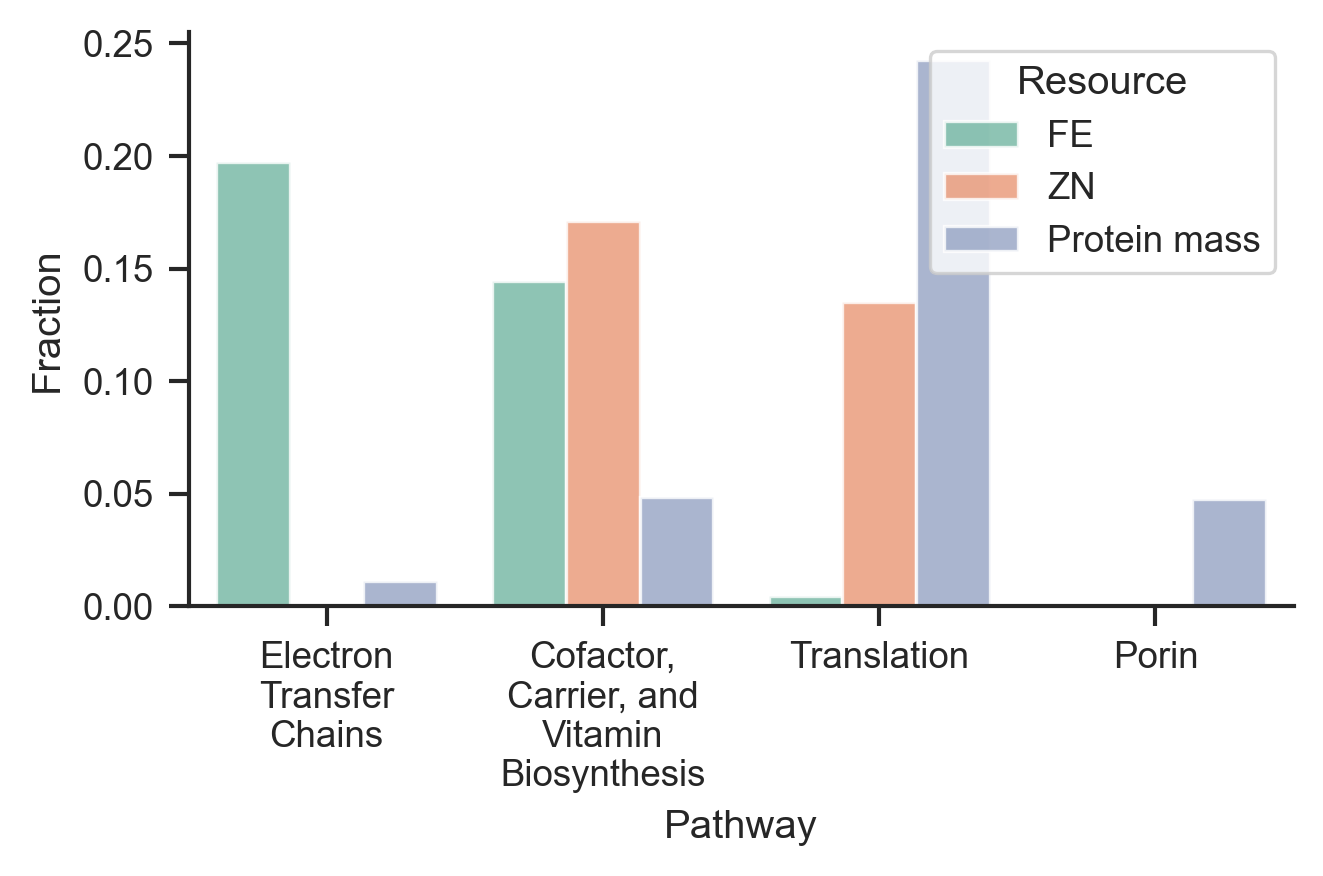

In [49]:
pw_order = resource_df_f.filter(pl.col("Resource") == "FE").sort("Sum of resource fractions", descending=True).select("Pathway").to_series().to_list()

sns.catplot(x="Pathway", y="Fraction", hue="Resource", data=resource_df_f.to_pandas(), kind="bar", aspect=1.5, height=3,  legend_out=False, alpha=0.8)

# rotate labels
plt.xticks(rotation=0)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'FLAGELLAR-MOTOR-COMPLEX'),
  Text(1, 0, 'G6763-MONOMER'),
  Text(2, 0, 'CPLX0-7747'),
  Text(3, 0, 'CPLX0-7938'),
  Text(4, 0, 'EG10308-MONOMER'),
  Text(5, 0, 'CPLX0-8585'),
  Text(6, 0, 'CPLX0-7521'),
  Text(7, 0, 'CPLX0-7452'),
  Text(8, 0, 'G7087-MONOMER'),
  Text(9, 0, 'G7128-MONOMER'),
  Text(10, 0, 'EG10321-MONOMER'),
  Text(11, 0, 'CPLX0-8103'),
  Text(12, 0, 'CPLX0-2441'),
  Text(13, 0, 'PTSH-MONOMER'),
  Text(14, 0, 'EG11545-MONOMER'),
  Text(15, 0, 'G6968-MONOMER'),
  Text(16, 0, 'CPLX0-8102'),
  Text(17, 0, 'MONOMER0-4539'),
  Text(18, 0, 'G6881-MONOMER'),
  Text(19, 0, 'G6623-MONOMER')])

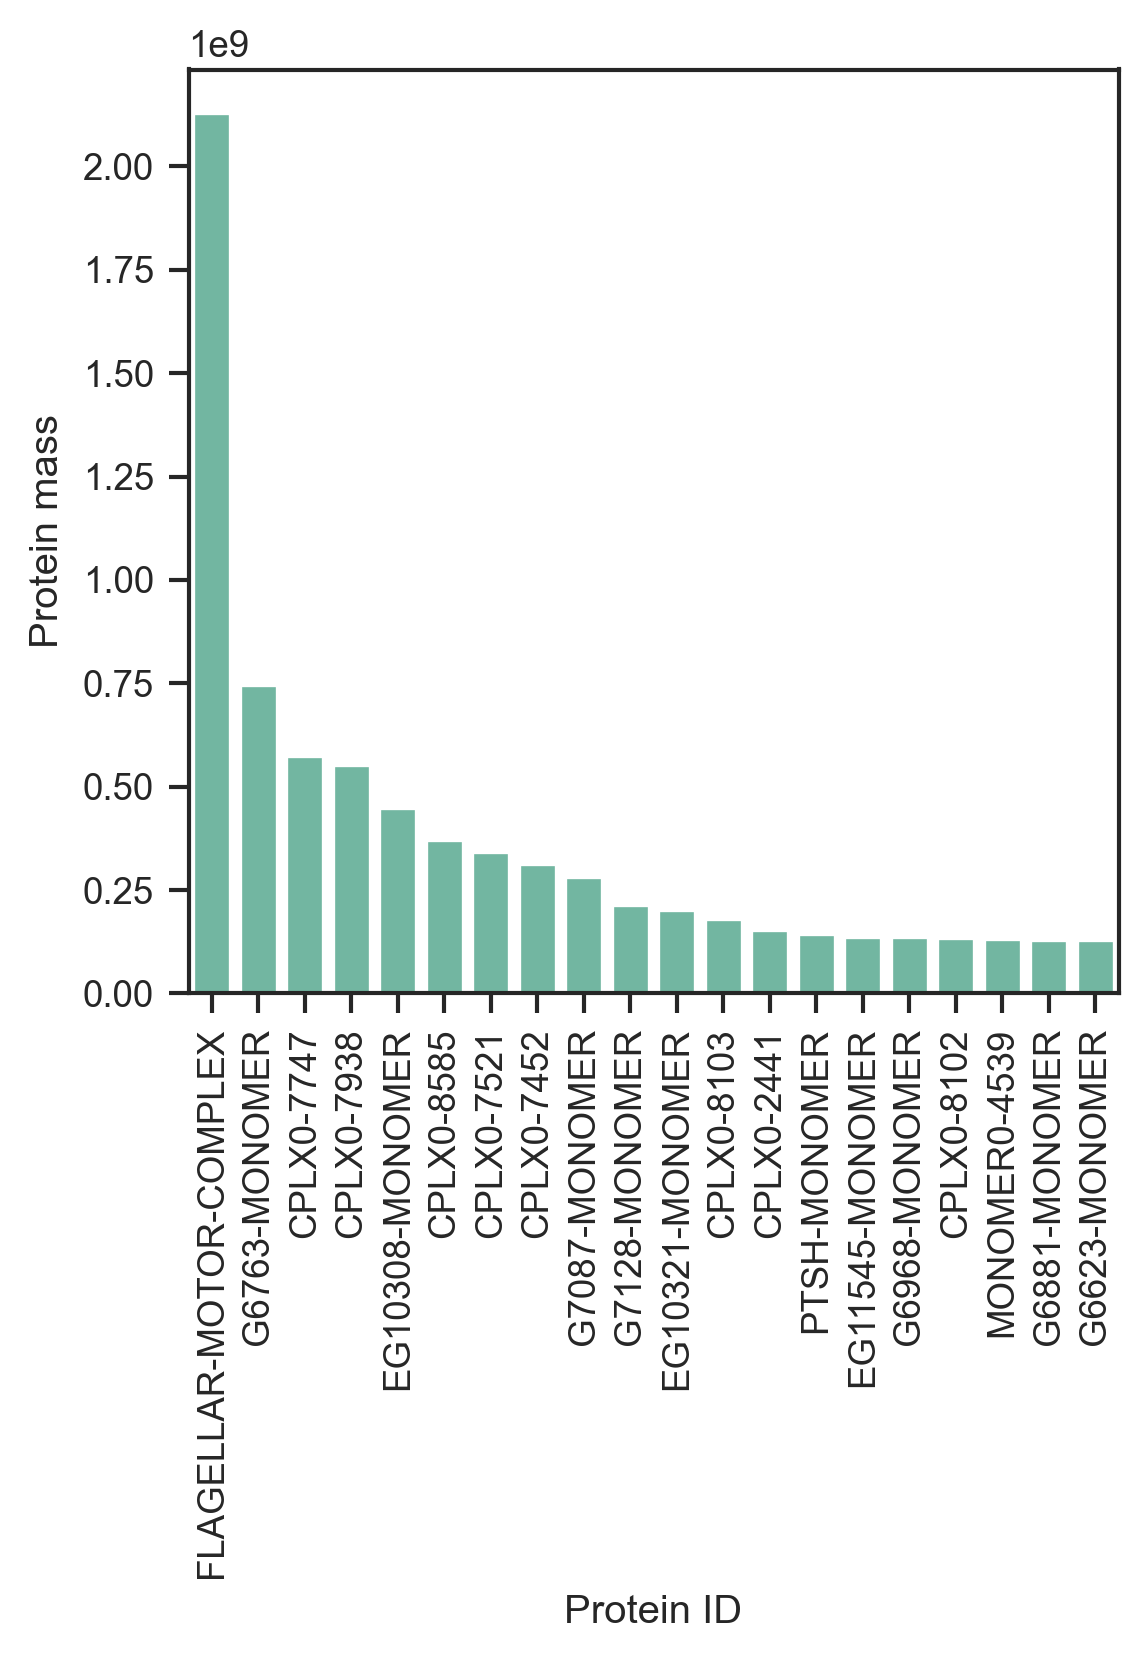

In [50]:
uncategorized_vec = (csr_matrix(np.diag(resources[-1, :].toarray().flatten())) @ Pw)[:, list(pathway_ids).index("Uncategorized (II)")]


# convert to dataframe
uncategorized_df = pl.DataFrame(uncategorized_vec.toarray(), schema=["Protein mass"])

# add protein ID column
uncategorized_df = uncategorized_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein ID"]))

# sort and get top 20, then plot
uncategorized_df = uncategorized_df.sort("Protein mass", descending=True).head(20)

plt.figure(figsize=(4, 4))
sns.barplot(data=uncategorized_df.to_pandas(), x="Protein ID", y="Protein mass", color=sns.color_palette("Set2")[0])

plt.xticks(rotation=90)

## Fe/Zn generalist vs specialist

In [51]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

median_count = csr_matrix(np.diag(np.median(total_counts_min, axis=0)))

ep_counts = median_count @ C @ P @ E[:, element_indices]

# convert to dataframe
ep_df = pl.DataFrame(ep_counts.toarray(), schema=elements)

# add protein_ids as a column
ep_df = ep_df.with_columns(pl.DataFrame(protein_ids, schema=["Protein"]))

# melt to long form
ep_df = ep_df.melt(id_vars="Protein", value_name="Metal atoms allocated to protein", variable_name="Element")

# remove all rows with 0 atoms/cell
ep_df = ep_df.filter(pl.col("Metal atoms allocated to protein") > 0)

# Get the sum per element
sum_df = ep_df.group_by("Element").agg(pl.sum("Metal atoms allocated to protein").alias("Total atoms"))

# Join with ep_df to get the percentage
ep_df = ep_df.join(sum_df, on="Element")

# calculate the percentage
ep_df = ep_df.with_columns( (ep_df["Metal atoms allocated to protein"] / ep_df["Total atoms"]).alias("Fraction of metal"))

# sort by element, then by fraction of metal
ep_df = ep_df.sort(["Element", "Fraction of metal"], descending=[False, True])

# get the index per row
ep_df = ep_df.with_columns(pl.DataFrame(np.arange(1, ep_df.shape[0]+1), schema=["Index"]))

# groupby element and get minimum index
min_index = ep_df.group_by("Element").agg(pl.min("Index").alias("Min index"))

# join with ep_df, then subtract min index from index
ep_df = ep_df.join(min_index, on="Element")
ep_df = ep_df.with_columns( (ep_df["Index"] - ep_df["Min index"] + 1).alias("Rank"))
ep_df = ep_df.drop(["Min index", "Index"])

# Create cumulative sum of fraction of metal
cumsum_col = ep_df.select(pl.col('Fraction of metal').cumsum().over('Element'))

# add column to ep_df
ep_df = ep_df.with_columns(cumsum_col)

# rename fraction of metal to cumulative fraction of metal
ep_df = ep_df.rename({"Fraction of metal": "Cumulative fraction of metal"})

# only include FE, ZN, MN
ep_df = ep_df.filter(pl.col("Element").is_in(["FE", "ZN", "MN"]))

ep_df

shape: (476, 6)
┌──────────────────────┬─────────┬──────────────────────┬─────────────┬─────────────────────┬──────┐
│ Protein              ┆ Element ┆ Metal atoms          ┆ Total atoms ┆ Cumulative fraction ┆ Rank │
│ ---                  ┆ ---     ┆ allocated to prote…  ┆ ---         ┆ of metal            ┆ ---  │
│ str                  ┆ str     ┆ ---                  ┆ f64         ┆ ---                 ┆ i64  │
│                      ┆         ┆ f64                  ┆             ┆ f64                 ┆      │
╞══════════════════════╪═════════╪══════════════════════╪═════════════╪═════════════════════╪══════╡
│ SUPEROX-DISMUTFE-CPL ┆ FE      ┆ 21036.0              ┆ 299753.5    ┆ 0.070178            ┆ 1    │
│ X                    ┆         ┆                      ┆             ┆                     ┆      │
│ NADH-DHI-CPLX        ┆ FE      ┆ 20288.0              ┆ 299753.5    ┆ 0.13786             ┆ 2    │
│ GLUTAMATESYN-CPLX    ┆ FE      ┆ 14644.0              ┆ 299753.5    ┆ 0.186713            ┆ 3    │
│ 3-ISOPROPYLMALISOM-C ┆ FE      ┆ 13510.0              ┆ 299753.5    ┆ 0.231784            ┆ 4    │
│ PLX                  ┆         ┆                      ┆             ┆                     ┆      │
│ ACONITATEDEHYDRB-MON ┆ FE      ┆ 11824.0              ┆ 299753.5    ┆ 0.27123             ┆ 5    │
│ OMER                 ┆         ┆                      ┆             ┆                     ┆      │
│ …                    ┆ …       ┆ …                    ┆ …           ┆ …                   ┆ …    │
│ HISTDEHYD-MONOMER    ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999983            ┆ 209  │
│ GTP-CYCLOHYDRO-II-MO ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999987            ┆ 210  │
│ NOMER                ┆         ┆                      ┆             ┆                     ┆      │
│ ALAS-MONOMER         ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999991            ┆ 211  │
│ G6662-MONOMER        ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999996            ┆ 212  │
│ G7842-MONOMER        ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 1.0                 ┆ 213  │
└──────────────────────┴─────────┴──────────────────────┴─────────────┴─────────────────────┴──────┘

In [52]:
ep_df

shape: (476, 6)
┌──────────────────────┬─────────┬──────────────────────┬─────────────┬─────────────────────┬──────┐
│ Protein              ┆ Element ┆ Metal atoms          ┆ Total atoms ┆ Cumulative fraction ┆ Rank │
│ ---                  ┆ ---     ┆ allocated to prote…  ┆ ---         ┆ of metal            ┆ ---  │
│ str                  ┆ str     ┆ ---                  ┆ f64         ┆ ---                 ┆ i64  │
│                      ┆         ┆ f64                  ┆             ┆ f64                 ┆      │
╞══════════════════════╪═════════╪══════════════════════╪═════════════╪═════════════════════╪══════╡
│ SUPEROX-DISMUTFE-CPL ┆ FE      ┆ 21036.0              ┆ 299753.5    ┆ 0.070178            ┆ 1    │
│ X                    ┆         ┆                      ┆             ┆                     ┆      │
│ NADH-DHI-CPLX        ┆ FE      ┆ 20288.0              ┆ 299753.5    ┆ 0.13786             ┆ 2    │
│ GLUTAMATESYN-CPLX    ┆ FE      ┆ 14644.0              ┆ 299753.5    ┆ 0.186713            ┆ 3    │
│ 3-ISOPROPYLMALISOM-C ┆ FE      ┆ 13510.0              ┆ 299753.5    ┆ 0.231784            ┆ 4    │
│ PLX                  ┆         ┆                      ┆             ┆                     ┆      │
│ ACONITATEDEHYDRB-MON ┆ FE      ┆ 11824.0              ┆ 299753.5    ┆ 0.27123             ┆ 5    │
│ OMER                 ┆         ┆                      ┆             ┆                     ┆      │
│ …                    ┆ …       ┆ …                    ┆ …           ┆ …                   ┆ …    │
│ HISTDEHYD-MONOMER    ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999983            ┆ 209  │
│ GTP-CYCLOHYDRO-II-MO ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999987            ┆ 210  │
│ NOMER                ┆         ┆                      ┆             ┆                     ┆      │
│ ALAS-MONOMER         ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999991            ┆ 211  │
│ G6662-MONOMER        ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 0.999996            ┆ 212  │
│ G7842-MONOMER        ┆ ZN      ┆ 1.0                  ┆ 234690.5    ┆ 1.0                 ┆ 213  │
└──────────────────────┴─────────┴──────────────────────┴─────────────┴─────────────────────┴──────┘

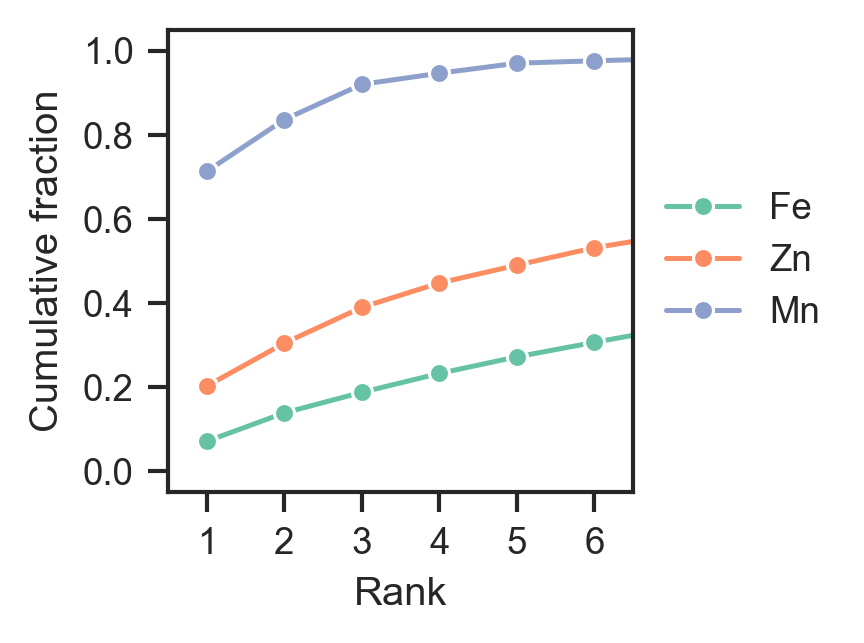

In [53]:

ep_display_df = ep_df

# replace element name from dict
ep_display_df = ep_display_df.with_columns(pl.col("Element").replace(element_display_dict))

# plot fraction of metal against rank
plt.figure(figsize=(2, 2))
g = sns.lineplot(data=ep_display_df.to_pandas(), x="Rank", y="Cumulative fraction of metal", hue="Element", marker="o", hue_order=["Fe", "Zn", "Mn"])

# move legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.xlim(0.5, 6.5)
plt.ylim(-0.05, 1.05)
plt.ylabel("Cumulative fraction")
plt.xticks(np.arange(1, 7, 1))
g.xaxis.grid(False)

plt.savefig("figures/fe_zn_mn_generalist_specialist.svg", transparent=True)

## Cell iron is mostly in iron-sulfur clusters

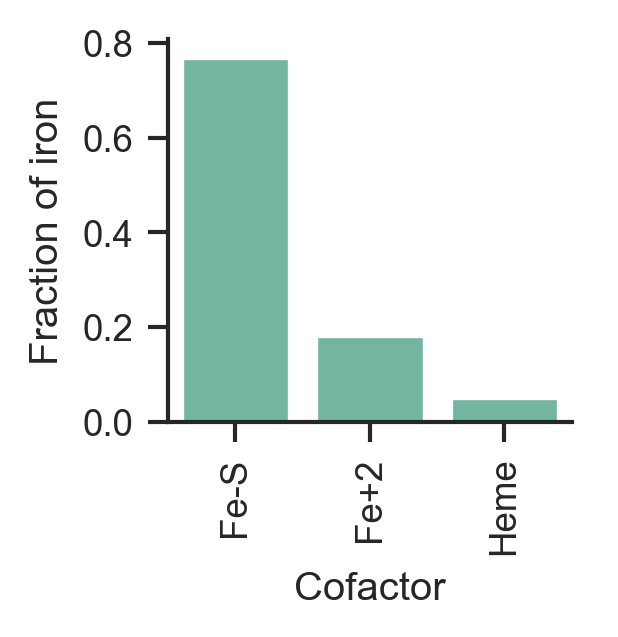

In [54]:
plot_names = {'3FE-4S': '3Fe-4S', 'FE+2': 'Fe+2', 'Heme-b': 'Heme', 'CPD-7': '4Fe-4S', 'CPD-6':'2Fe-2S'}

elements = ["FE"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# find cofactors that use iron
cofactor_iron_stoich = E[:, element_indices].toarray().flatten()

# cofactor names
cofactor_names = np.array(cofactor_ids)[cofactor_iron_stoich > 0]
cofactor_names = [plot_names.get(name, name) for name in cofactor_names]

# compute the distribution across forms of iron
median_count = csr_matrix(np.median(total_counts_min, axis=0))
ep_counts = np.multiply((median_count @ C @ P)[:, cofactor_iron_stoich>0].toarray(), cofactor_iron_stoich[cofactor_iron_stoich>0])

# divide by sum
ep_counts = ep_counts / ep_counts.sum(axis=1)

# create dataframe
ep_df = pl.DataFrame(ep_counts, schema=cofactor_names)

# melt to long form
ep_df = ep_df.melt(value_name="Fraction of iron", variable_name="Cofactor")

# create new column that specifies if cofactor is a Fe-S
ep_df = ep_df.with_columns( (ep_df["Cofactor"].is_in(["3Fe-4S", "4Fe-4S", "2Fe-2S"])).alias("Fe-S"))

# use polars when, when Fe-S is true, Cofactor becomes Fe-S, otherwise don't change it.
ep_df = ep_df.with_columns( pl.when(ep_df["Fe-S"]).then(pl.lit("Fe-S")).otherwise(pl.col("Cofactor")).alias("Cofactor"))

# groupby cofactor and get the sum of fraction of iron
ep_df = ep_df.group_by("Cofactor").agg(pl.sum("Fraction of iron").alias("Fraction of iron"))

# create list of sorting order for plot
order = pl.Series(ep_df.sort("Fraction of iron", descending=True).select("Cofactor")).to_list()

# make plot
sns.catplot(data=ep_df.to_pandas(), y="Fraction of iron",  kind="bar", x="Cofactor", aspect=1., height=2, order=order)

# rotate labels
plt.xticks(rotation=90, ha="center")

plt.savefig("figures/iron_distribution.svg", transparent=True)

# Timeseries stability of aggregate molecules

In [55]:
elements = ["ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_vec = C @ P @ E[:, element_indices]

# multiply rows of total_counts by element_vec
total_counts_zn = total_counts.copy()

for i in range(total_counts_zn.shape[0]):
    total_counts_zn[i, :] = np.multiply(total_counts_zn[i, :], element_vec.toarray().flatten())
    
# eliminate columns with all zeros
filter_cols = np.any(total_counts_zn, axis=0)
total_counts_zn_filter = total_counts_zn[:, filter_cols]

# index protein ids by filter_cols
protein_ids_filter = protein_ids[filter_cols]

In [56]:
# create a dataframe with the timeseries
total_counts_zn_df = pl.DataFrame(total_counts_zn_filter, schema=protein_ids_filter.tolist())

# add timestep column
total_counts_zn_df = total_counts_zn_df.with_columns(pl.DataFrame(np.arange(0, total_counts_zn_df.shape[0]), schema=["Time (s)"]))

# melt to long form
total_counts_zn_df_m = total_counts_zn_df.melt(value_name="Atoms/cell", variable_name="Protein ID", id_vars="Time (s)")

# for each protein, find value with timestep 0
initial_values = total_counts_zn_df_m.filter(pl.col("Time (s)") == 0)

# alias the column to avoid confusion
initial_values = initial_values.with_columns(pl.col("Atoms/cell").alias("Initial Atoms/cell"))

# join with the original dataframe
total_counts_zn_df_m = total_counts_zn_df_m.join(initial_values, on="Protein ID", how="left")

# filter out proteins with initial atoms/cell less than 100
total_counts_zn_df_m = total_counts_zn_df_m.filter(pl.col("Initial Atoms/cell") > 500)

# calculate the fold change
total_counts_zn_df_m = total_counts_zn_df_m.with_columns( ((total_counts_zn_df_m["Atoms/cell"] +0)/ (total_counts_zn_df_m["Initial Atoms/cell"] +0)).alias("Fold change since t=0"))

# create a sum_df from total_counts_zn_df
sum_df = total_counts_zn_df_m.group_by("Time (s)").agg(pl.sum("Atoms/cell").alias("Total atoms"))

# divide sum_df Total atoms by the initial value
sum_df = sum_df.with_columns( (sum_df["Total atoms"] / sum_df.filter(pl.col("Time (s)") == 0)["Total atoms"][0]).alias("Fold change since t=0"))

In [57]:
total_counts_zn_df_m

shape: (96_675, 7)
┌──────────┬───────────────┬────────────┬───────────┬───────────────┬───────────────┬──────────────┐
│ Time (s) ┆ Protein ID    ┆ Atoms/cell ┆ Time      ┆ Atoms/cell_ri ┆ Initial       ┆ Fold change  │
│ ---      ┆ ---           ┆ ---        ┆ (s)_right ┆ ght           ┆ Atoms/cell    ┆ since t=0    │
│ i64      ┆ str           ┆ i64        ┆ ---       ┆ ---           ┆ ---           ┆ ---          │
│          ┆               ┆            ┆ i64       ┆ i64           ┆ i64           ┆ f64          │
╞══════════╪═══════════════╪════════════╪═══════════╪═══════════════╪═══════════════╪══════════════╡
│ 0        ┆ ACETYL-COA-CA ┆ 2210       ┆ 0         ┆ 2210          ┆ 2210          ┆ 1.0          │
│          ┆ RBOXYLTRANSFE ┆            ┆           ┆               ┆               ┆              │
│          ┆ R-CP…         ┆            ┆           ┆               ┆               ┆              │
│ 1        ┆ ACETYL-COA-CA ┆ 2210       ┆ 0         ┆ 2210          ┆ 2210          ┆ 1.0          │
│          ┆ RBOXYLTRANSFE ┆            ┆           ┆               ┆               ┆              │
│          ┆ R-CP…         ┆            ┆           ┆               ┆               ┆              │
│ 2        ┆ ACETYL-COA-CA ┆ 2210       ┆ 0         ┆ 2210          ┆ 2210          ┆ 1.0          │
│          ┆ RBOXYLTRANSFE ┆            ┆           ┆               ┆               ┆              │
│          ┆ R-CP…         ┆            ┆           ┆               ┆               ┆              │
│ 3        ┆ ACETYL-COA-CA ┆ 2210       ┆ 0         ┆ 2210          ┆ 2210          ┆ 1.0          │
│          ┆ RBOXYLTRANSFE ┆            ┆           ┆               ┆               ┆              │
│          ┆ R-CP…         ┆            ┆           ┆               ┆               ┆              │
│ 4        ┆ ACETYL-COA-CA ┆ 2210       ┆ 0         ┆ 2210          ┆ 2210          ┆ 1.0          │
│          ┆ RBOXYLTRANSFE ┆            ┆           ┆               ┆               ┆              │
│          ┆ R-CP…         ┆            ┆           ┆               ┆               ┆              │
│ …        ┆ …             ┆ …          ┆ …         ┆ …             ┆ …             ┆ …            │
│ 1284     ┆ ZNUA-MONOMER  ┆ 2046       ┆ 0         ┆ 1054          ┆ 1054          ┆ 1.941176     │
│ 1285     ┆ ZNUA-MONOMER  ┆ 2046       ┆ 0         ┆ 1054          ┆ 1054          ┆ 1.941176     │
│ 1286     ┆ ZNUA-MONOMER  ┆ 2046       ┆ 0         ┆ 1054          ┆ 1054          ┆ 1.941176     │
│ 1287     ┆ ZNUA-MONOMER  ┆ 2047       ┆ 0         ┆ 1054          ┆ 1054          ┆ 1.942125     │
│ 1288     ┆ ZNUA-MONOMER  ┆ 2047       ┆ 0         ┆ 1054          ┆ 1054          ┆ 1.942125     │
└──────────┴───────────────┴────────────┴───────────┴───────────────┴───────────────┴──────────────┘

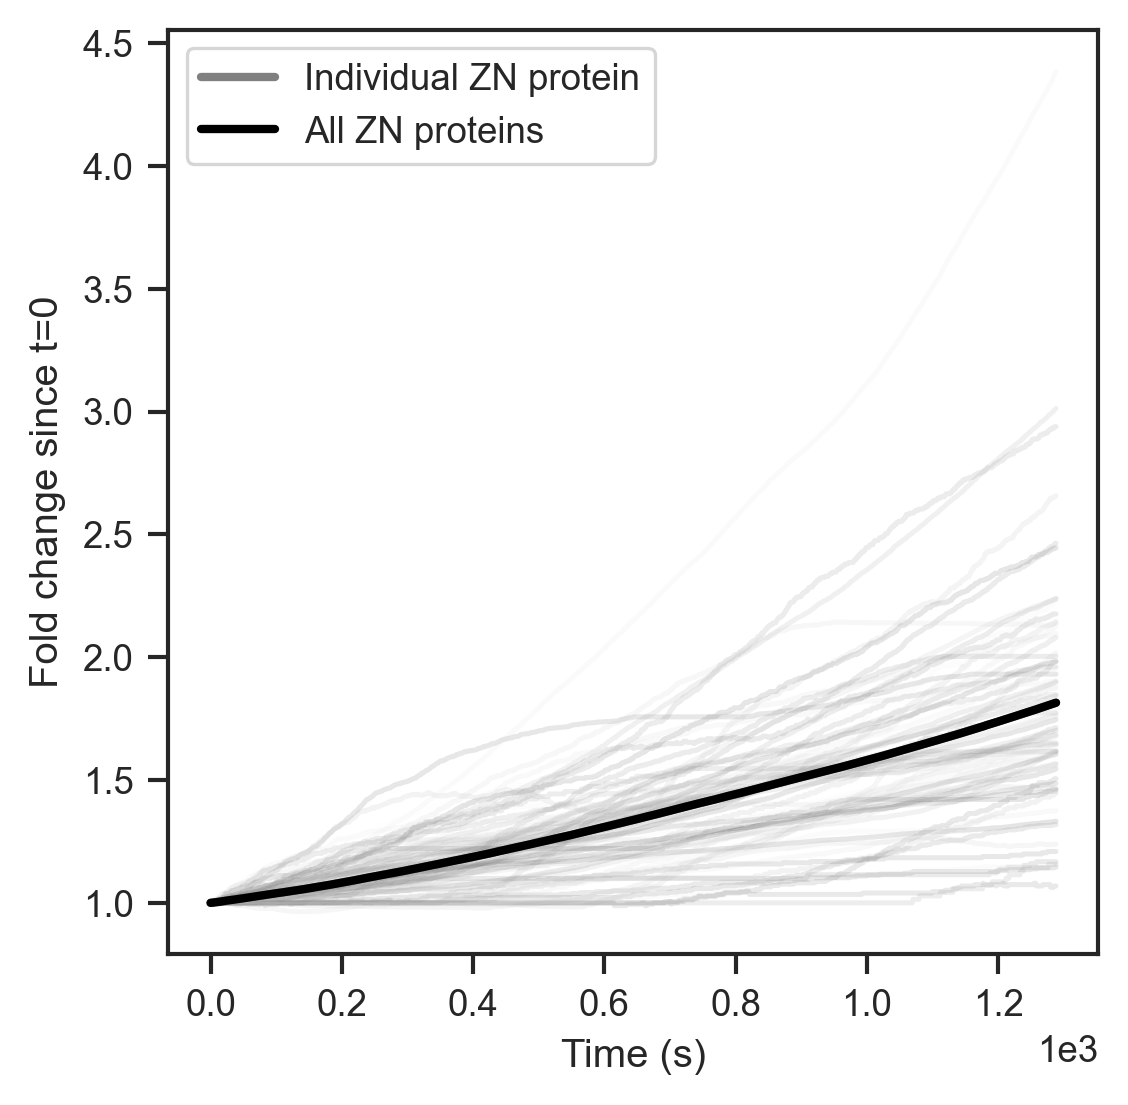

In [58]:
plt.figure(figsize=(4,4))

# plot timeseries for all proteins in a single big chart
sns.lineplot(data=total_counts_zn_df_m.to_pandas(), x="Time (s)", y="Fold change since t=0", hue="Protein ID", legend=False, alpha=0.1, palette="gray")

# plot the sum as a thicker line
sns.lineplot(data=sum_df.to_pandas(), x="Time (s)", y="Fold change since t=0", color="grey", linewidth=2, label="Individual ZN protein")
sns.lineplot(data=sum_df.to_pandas(), x="Time (s)", y="Fold change since t=0", color="black", linewidth=2, label="All ZN proteins")

# save as svg
plt.savefig("figures/aggregate_zn_proteins.svg", transparent=True)

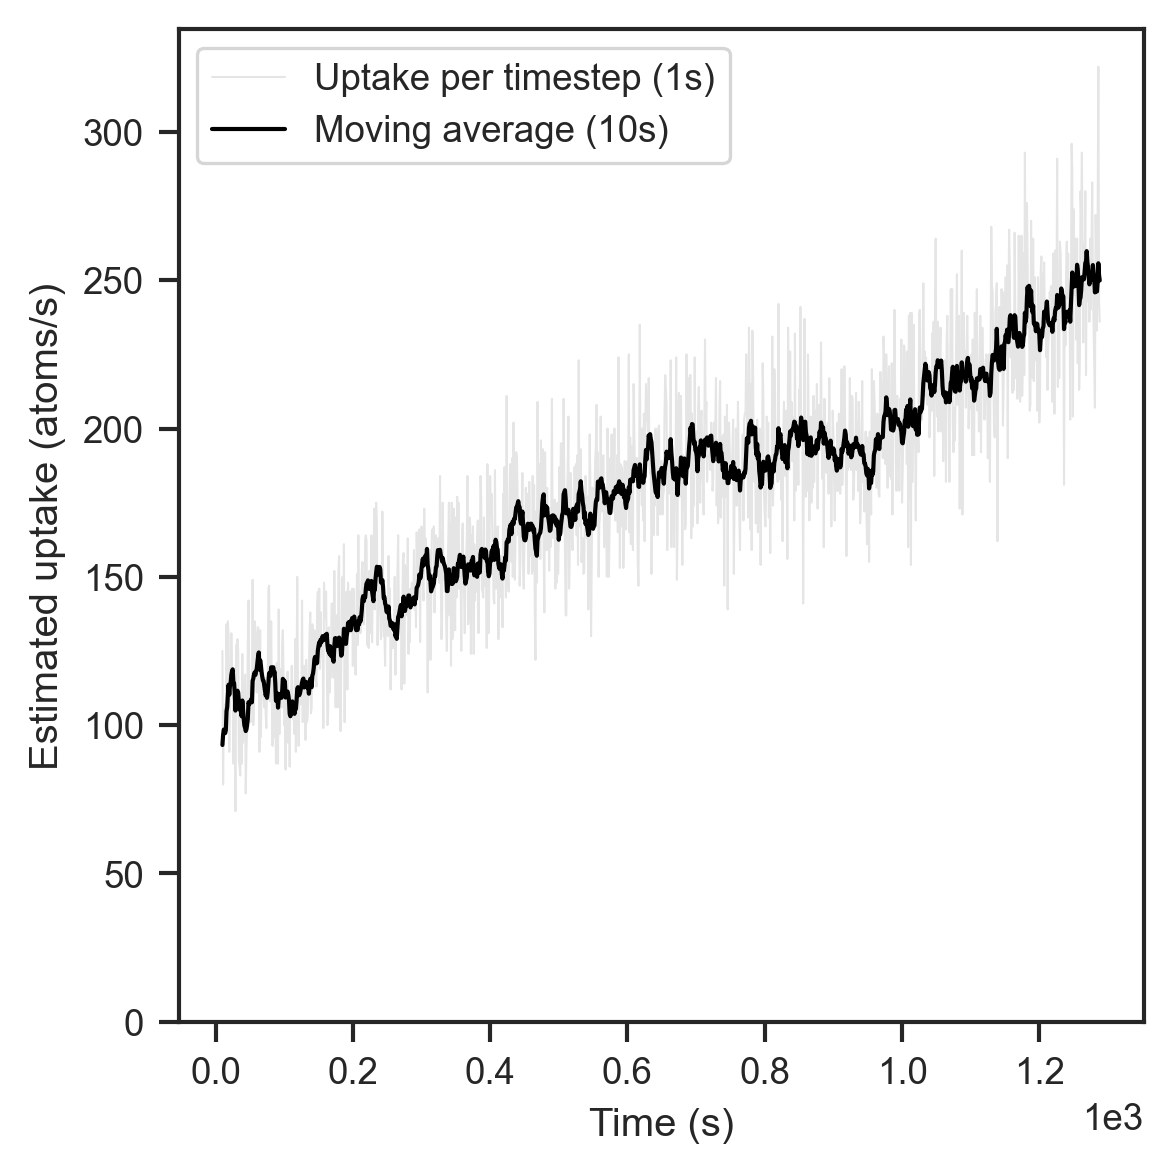

In [59]:
plt.figure(figsize=(4,4))

uptake_df = sum_df.sort(by="Time (s)")

# per timestep, calculate the difference from the previous timestep in atoms/cell
uptake_df = uptake_df.with_columns( (uptake_df["Total atoms"] - uptake_df["Total atoms"].shift(1)).alias("Estimated uptake (atoms/s)"))

# do a 5 row moving average of the current uptake
uptake_df = uptake_df.with_columns( (uptake_df["Estimated uptake (atoms/s)"].rolling_mean(window_size=10)).alias("Moving average (atoms/s)"))

# drop rows with null values in current uptake
uptake_df = uptake_df.filter(pl.col("Moving average (atoms/s)").is_not_null())


# plot current uptake
sns.lineplot(data=uptake_df.to_pandas(), x="Time (s)", y="Estimated uptake (atoms/s)", color="black", linewidth=0.5, alpha=0.1, label="Uptake per timestep (1s)")
sns.lineplot(data=uptake_df.to_pandas(), x="Time (s)", y="Moving average (atoms/s)", color="black", linewidth=1, label="Moving average (10s)")

plt.ylim(0, None)

# change xlabel 
plt.xlabel("Time (s)")

plt.tight_layout()


# save as png and svg
plt.savefig("figures/total_zn_atoms.png")
plt.savefig("figures/total_zn_atoms.svg")

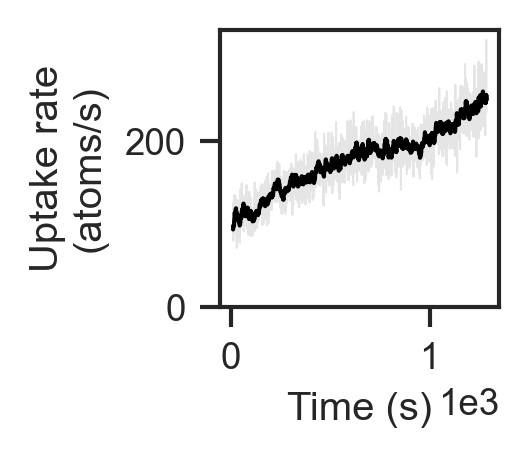

In [60]:
plt.figure(figsize=(1.2, 1.2))

uptake_df = sum_df.sort(by="Time (s)")

# per timestep, calculate the difference from the previous timestep in atoms/cell
uptake_df = uptake_df.with_columns( (uptake_df["Total atoms"] - uptake_df["Total atoms"].shift(1)).alias("Estimated uptake (atoms/s)"))

# do a 5 row moving average of the current uptake
uptake_df = uptake_df.with_columns( (uptake_df["Estimated uptake (atoms/s)"].rolling_mean(window_size=10)).alias("Moving average (atoms/s)"))

# drop rows with null values in current uptake
uptake_df = uptake_df.filter(pl.col("Moving average (atoms/s)").is_not_null())


# plot current uptake
sns.lineplot(data=uptake_df.to_pandas(), x="Time (s)", y="Estimated uptake (atoms/s)", color="black", linewidth=0.5, alpha=0.1, 
             #label="Uptake per timestep (1s)"
             )
sns.lineplot(data=uptake_df.to_pandas(), x="Time (s)", y="Moving average (atoms/s)", color="black", linewidth=1, 
             #label="Moving average (10s)"
             )

plt.ylim(0, None)

# change xlabel 
plt.xlabel("Time (s)")

# plt.tight_layout()

# change ylabel
plt.ylabel("Uptake rate\n(atoms/s)")


# save as png and svg
plt.savefig("figures/total_zn_atoms_small.svg")

In [61]:
# melt zn df
melted_zn_df = total_counts_zn_df.melt(id_vars=["Time (s)"],
                                       value_name="Atoms/cell",
                                       variable_name="Protein ID").group_by("Time (s)").agg(pl.sum("Atoms/cell").alias("Atoms/cell"))

melted_zn_df

shape: (1_289, 2)
┌──────────┬────────────┐
│ Time (s) ┆ Atoms/cell │
│ ---      ┆ ---        │
│ i64      ┆ i64        │
╞══════════╪════════════╡
│ 39       ┆ 296896     │
│ 399      ┆ 347863     │
│ 673      ┆ 397483     │
│ 164      ┆ 312127     │
│ 170      ┆ 312926     │
│ …        ┆ …          │
│ 488      ┆ 363258     │
│ 256      ┆ 325404     │
│ 1048     ┆ 473035     │
│ 1155     ┆ 497265     │
│ 521      ┆ 369048     │
└──────────┴────────────┘

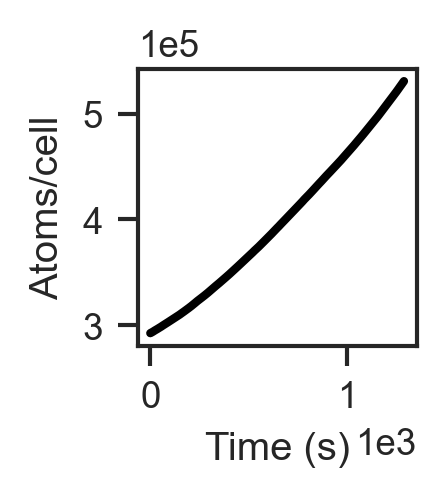

In [62]:
plt.figure(figsize=(1.2, 1.2))

# plot timeseries for all proteins in a single big chart
# sns.lineplot(data=total_counts_zn_df_m.to_pandas(), x="Time (s)", y="Fold change since t=0", hue="Protein ID", legend=False, alpha=0.1, palette="gray")

# plot the sum as a thicker line
# sns.lineplot(data=sum_df.to_pandas(), x="Time (s)", y="Fold change since t=0", color="grey", linewidth=2, label="Individual ZN protein")
sns.lineplot(data=melted_zn_df.to_pandas(), x="Time (s)", y="Atoms/cell", color="black", linewidth=2,)

# change y axis tick marks to scientific notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5))

# save as svg
plt.savefig("figures/aggregate_zn_proteins_small.svg", transparent=False)

In [63]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 100)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}

# just pick HOMOCYSMET-MONOMER and CPLX-3964
include = ["HOMOCYSMET-MONOMER", "CPLX0-3962"]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))

                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Time (s)"]))

moving_average_n = 60
avg_col_name = f"Moving average ({moving_average_n}s)"
diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Time (s)")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=moving_average_n)).alias(avg_col_name))

# drop rows where moving average is null
diff_df = diff_df.filter(pl.col(avg_col_name).is_not_null())

diff_df

shape: (2_458, 4)
┌──────────┬────────────────────┬────────────────────┬──────────────────────┐
│ Time (s) ┆ Protein ID         ┆ Uptake per protein ┆ Moving average (60s) │
│ ---      ┆ ---                ┆ ---                ┆ ---                  │
│ i64      ┆ str                ┆ i64                ┆ f64                  │
╞══════════╪════════════════════╪════════════════════╪══════════════════════╡
│ 60       ┆ HOMOCYSMET-MONOMER ┆ 7                  ┆ 1.983333             │
│ 61       ┆ HOMOCYSMET-MONOMER ┆ 9                  ┆ 2.133333             │
│ 62       ┆ HOMOCYSMET-MONOMER ┆ 5                  ┆ 2.233333             │
│ 63       ┆ HOMOCYSMET-MONOMER ┆ 6                  ┆ 2.333333             │
│ 64       ┆ HOMOCYSMET-MONOMER ┆ 1                  ┆ 2.35                 │
│ …        ┆ …                  ┆ …                  ┆ …                    │
│ 1284     ┆ CPLX0-3962         ┆ 37                 ┆ 47.933333            │
│ 1285     ┆ CPLX0-3962         ┆ 44                 ┆ 47.816667            │
│ 1286     ┆ CPLX0-3962         ┆ 35                 ┆ 47.583333            │
│ 1287     ┆ CPLX0-3962         ┆ 47                 ┆ 47.533333            │
│ 1288     ┆ CPLX0-3962         ┆ 52                 ┆ 47.666667            │
└──────────┴────────────────────┴────────────────────┴──────────────────────┘

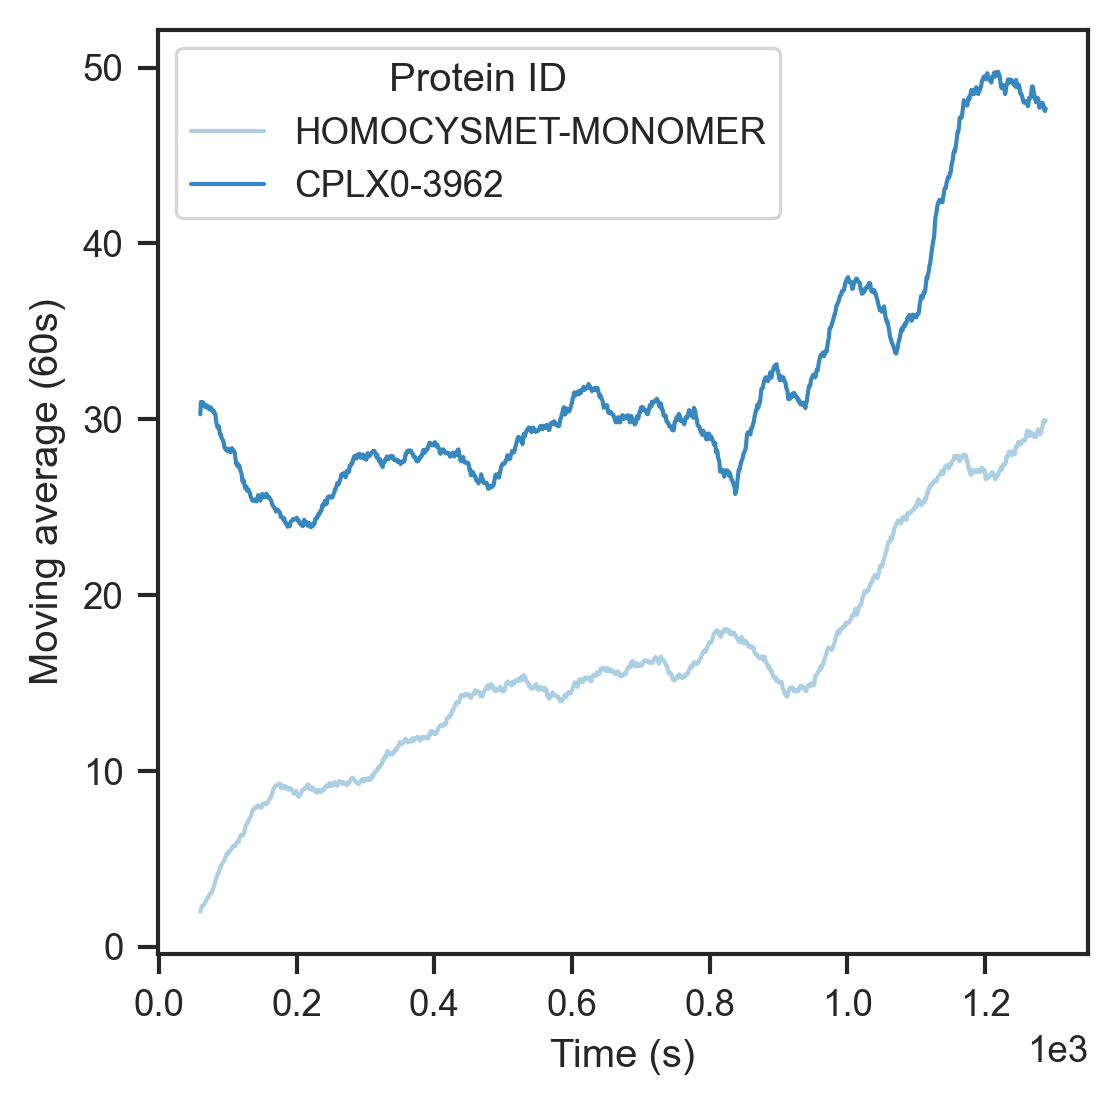

In [64]:
plt.figure(figsize=(4, 4))

# filter timestep to be between 0 and 200
# diff_df = diff_df.filter(pl.col("Time (s)") < 500)

sns.lineplot(data=diff_df.to_pandas(), x="Time (s)", y=avg_col_name, 
             hue="Protein ID",  legend=True, alpha=1, linewidth=1, palette="Blues")

# save as svg
plt.savefig("figures/uptake_per_protein.svg", transparent=True)

# Repeat uptake with multiple sims

In [65]:
elements = ["ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

proteins = ["HOMOCYSMET-MONOMER", "CPLX0-3962",]
protein_indices = np.array([list(protein_ids).index(protein) for protein in proteins])

# compute the timeseries for the elements
conversion_M = C @ P @ E[:, element_indices]

In [66]:
rich_mete_rib_counts = total_counts_big[:, protein_indices + 1]
rich_total_zn_counts = (conversion_M.T @ total_counts_big[:, 1:-1].T).T
rich_cell_index = total_counts_big[:, -1]
rich_cell_time = total_counts_big[:, 0]

minimal_mete_rib_counts = total_counts_big_min[:, protein_indices + 1]
minimal_total_zn_counts = (conversion_M.T @ total_counts_big_min[:, 1:-1].T).T
minimal_cell_index = total_counts_big_min[:, -1]
minimal_cell_time = total_counts_big_min[:, 0]

# create dataframe
temp_rich_df = pl.DataFrame(rich_mete_rib_counts, schema=proteins)
temp_rich_df = temp_rich_df.with_columns(pl.DataFrame(rich_total_zn_counts, schema=["Total atoms/cell"]))
temp_rich_df = temp_rich_df.with_columns(pl.DataFrame(rich_cell_index, schema=["Cell index"]))
temp_rich_df = temp_rich_df.with_columns(pl.DataFrame(rich_cell_time, schema=["Time (s)"]))
temp_rich_df = temp_rich_df.with_columns(pl.lit("Rich\nmedia").alias("Condition"))

temp_min_df = pl.DataFrame(minimal_mete_rib_counts, schema=proteins)
temp_min_df = temp_min_df.with_columns(pl.DataFrame(minimal_total_zn_counts, schema=["Total atoms/cell"]))
temp_min_df = temp_min_df.with_columns(pl.DataFrame(minimal_cell_index, schema=["Cell index"]))
temp_min_df = temp_min_df.with_columns(pl.DataFrame(minimal_cell_time, schema=["Time (s)"]))
temp_min_df = temp_min_df.with_columns(pl.lit("Minimal\nmedia").alias("Condition"))


# concat
mete_rib_df = pl.concat([temp_rich_df, temp_min_df], how="vertical")

# rename HOMOCYSMET-MONOMER to MetE and CPLX0-3962 to Ribosome
mete_rib_df = mete_rib_df.rename({"HOMOCYSMET-MONOMER": "MetE", "CPLX0-3962": "Ribosome"})

# melt to long form 
mete_rib_df = mete_rib_df.melt(value_name="Atoms/cell", variable_name="Protein ID", id_vars=["Cell index", "Time (s)", "Condition", "Total atoms/cell"])

# group_by cell index and condition, then get max time
max_time_df = mete_rib_df.group_by(["Cell index", "Condition"]).agg(pl.max("Time (s)").alias("Max time"))

# join with mete_rib_df to get the max time
mete_rib_df = mete_rib_df.join(max_time_df, on=["Cell index", "Condition"])

# normalize by max time
mete_rib_df = mete_rib_df.with_columns( (mete_rib_df["Time (s)"] / mete_rib_df["Max time"]).alias("Time (1 cell cycle)"))

# normalize by total atoms/cell
mete_rib_df = mete_rib_df.with_columns( (mete_rib_df["Atoms/cell"] / mete_rib_df["Total atoms/cell"]).alias("Zn fraction"))

mete_rib_df

shape: (100_218, 9)
┌───────┬──────────┬───────────┬─────────────┬───┬────────────┬──────────┬────────────┬────────────┐
│ Cell  ┆ Time (s) ┆ Condition ┆ Total       ┆ … ┆ Atoms/cell ┆ Max time ┆ Time (1    ┆ Zn         │
│ index ┆ ---      ┆ ---       ┆ atoms/cell  ┆   ┆ ---        ┆ ---      ┆ cell       ┆ fraction   │
│ ---   ┆ i64      ┆ str       ┆ ---         ┆   ┆ i64        ┆ i64      ┆ cycle)     ┆ ---        │
│ i64   ┆          ┆           ┆ i64         ┆   ┆            ┆          ┆ ---        ┆ f64        │
│       ┆          ┆           ┆             ┆   ┆            ┆          ┆ f64        ┆            │
╞═══════╪══════════╪═══════════╪═════════════╪═══╪════════════╪══════════╪════════════╪════════════╡
│ 0     ┆ 0        ┆ Rich      ┆ 292633      ┆ … ┆ 6075       ┆ 1288     ┆ 0.0        ┆ 0.02076    │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 0     ┆ 1        ┆ Rich      ┆ 292723      ┆ … ┆ 6075       ┆ 1288     ┆ 0.000776   ┆ 0.020753   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 0     ┆ 2        ┆ Rich      ┆ 292813      ┆ … ┆ 6074       ┆ 1288     ┆ 0.001553   ┆ 0.020744   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 0     ┆ 3        ┆ Rich      ┆ 292929      ┆ … ┆ 6074       ┆ 1288     ┆ 0.002329   ┆ 0.020735   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 0     ┆ 4        ┆ Rich      ┆ 293044      ┆ … ┆ 6074       ┆ 1288     ┆ 0.003106   ┆ 0.020727   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ …     ┆ …        ┆ …         ┆ …           ┆ … ┆ …          ┆ …        ┆ …          ┆ …          │
│ 8     ┆ 2696     ┆ Minimal   ┆ 296502      ┆ … ┆ 30712      ┆ 2700     ┆ 0.998519   ┆ 0.103581   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 8     ┆ 2697     ┆ Minimal   ┆ 296589      ┆ … ┆ 30718      ┆ 2700     ┆ 0.998889   ┆ 0.103571   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 8     ┆ 2698     ┆ Minimal   ┆ 296665      ┆ … ┆ 30728      ┆ 2700     ┆ 0.999259   ┆ 0.103578   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 8     ┆ 2699     ┆ Minimal   ┆ 296743      ┆ … ┆ 30736      ┆ 2700     ┆ 0.99963    ┆ 0.103578   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
│ 8     ┆ 2700     ┆ Minimal   ┆ 296825      ┆ … ┆ 30746      ┆ 2700     ┆ 1.0        ┆ 0.103583   │
│       ┆          ┆ media     ┆             ┆   ┆            ┆          ┆            ┆            │
└───────┴──────────┴───────────┴─────────────┴───┴────────────┴──────────┴────────────┴────────────┘

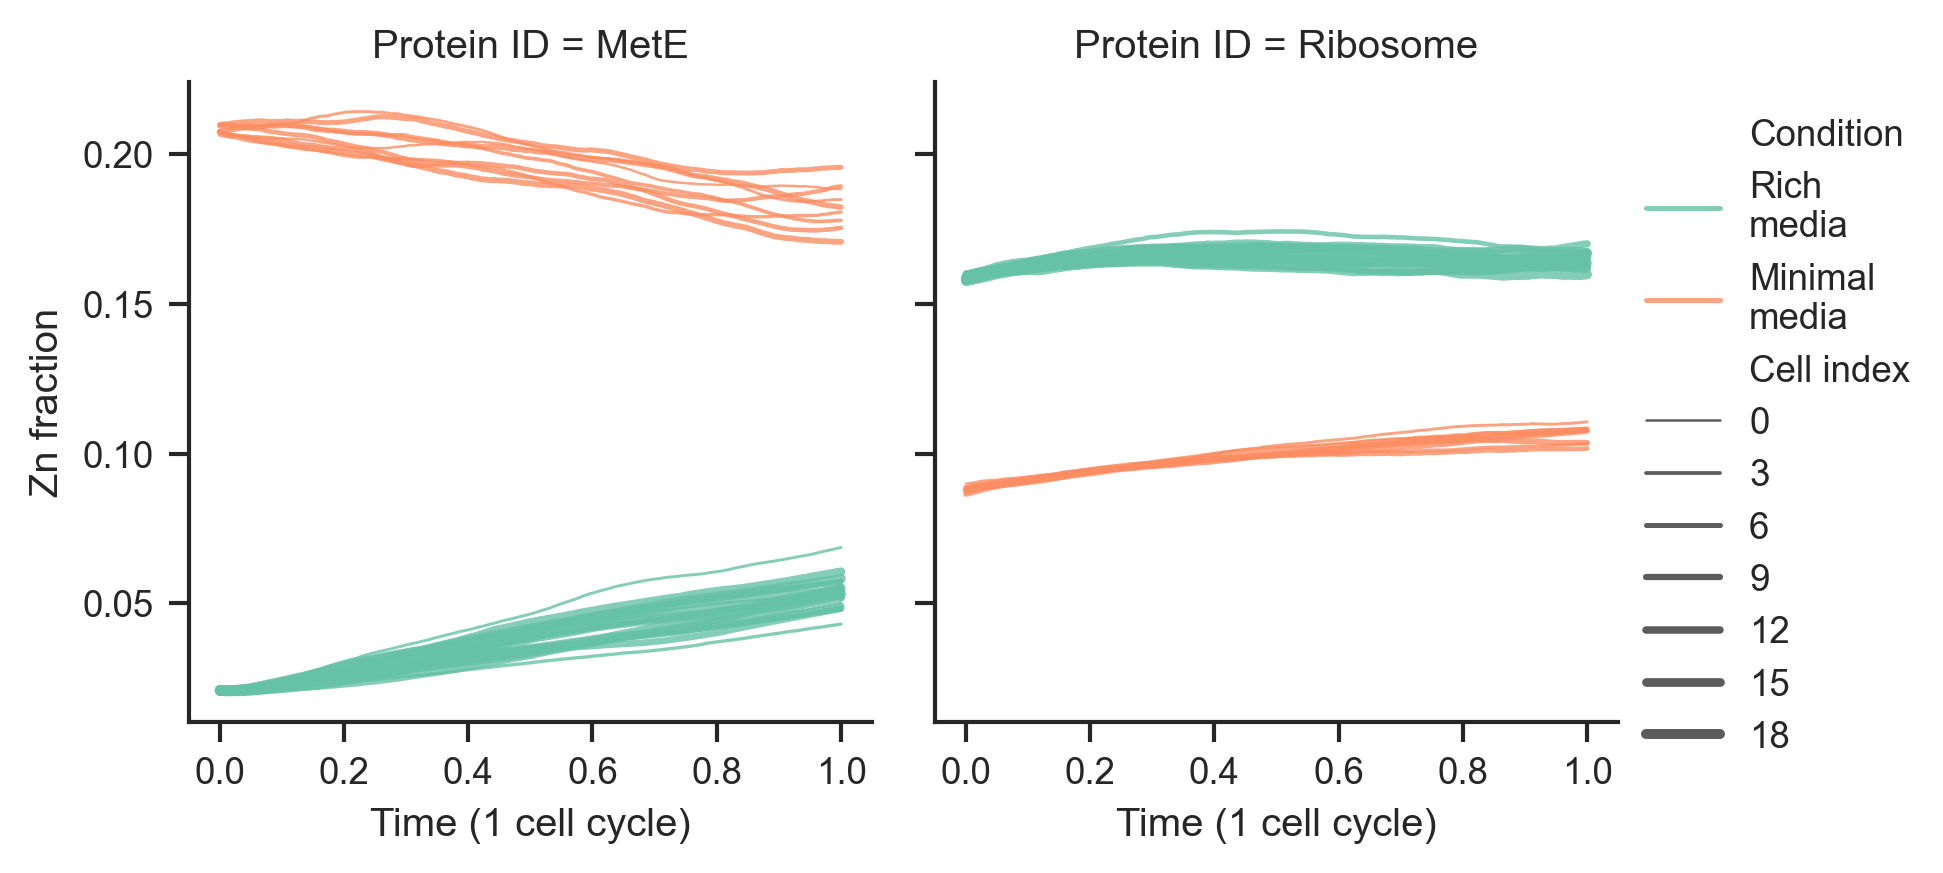

In [67]:
# plot series for different cells 
sns.relplot(data=mete_rib_df.to_pandas(), x="Time (1 cell cycle)", 
            y="Zn fraction", 
            hue="Condition",
            size="Cell index",
            col="Protein ID",
            kind="line", aspect=0.95, height=3, alpha=0.8, legend='brief',
            # facet_kws={'sharex': False}
            )


# save as svg
plt.savefig("figures/uptake_per_protein_multiple_cells.svg", transparent=False)

In [68]:
# average zn fraction over time
mete_rib_df_grp = mete_rib_df.group_by(["Cell index", "Condition", "Protein ID"]).agg(pl.mean("Zn fraction").alias("Zn fraction"))

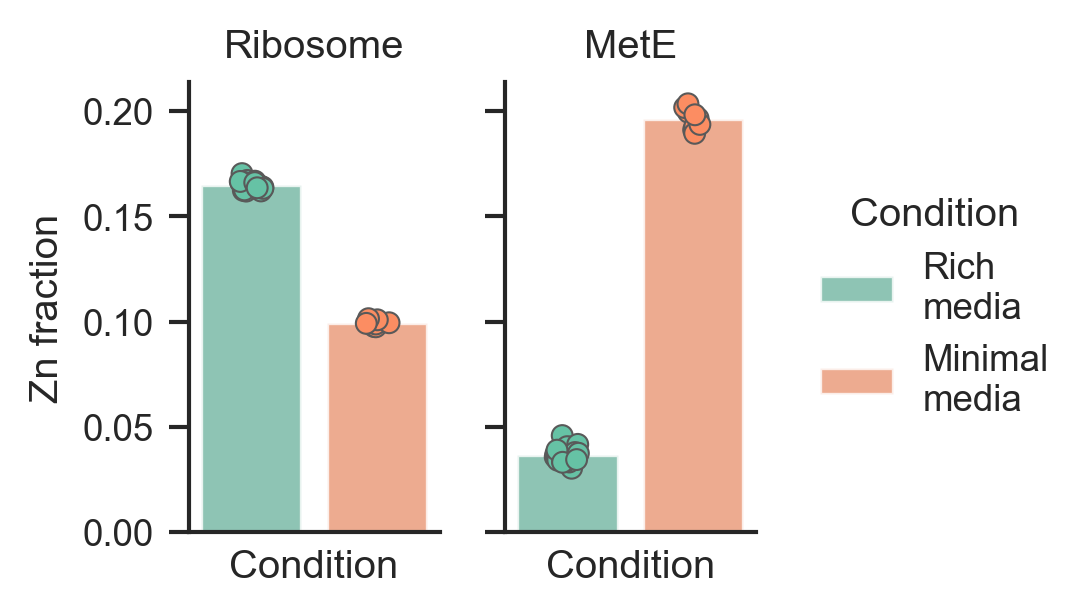

In [69]:
# make a barplot instead
order = ["Rich\nmedia", "Minimal\nmedia"]

g = sns.catplot(data=mete_rib_df_grp.to_pandas(), x="Condition", y="Zn fraction", hue="Condition", 
                order=order, hue_order=order, col="Protein ID", kind="bar", aspect=0.55, height=2.5, alpha=0.8, legend='brief',)



# add a strip plot on top
g.map_dataframe(sns.stripplot, x="Condition", y="Zn fraction", hue="Condition", dodge=False, alpha=1, palette="Set2",
                order = order, hue_order=order, linewidth=0.5)

# change col header to only include protein ID
g.set_titles(col_template="{col_name}")

# remove xticks
plt.xticks(ticks=[])

# save as svg
plt.savefig("figures/zn_story_zn_frac.svg", transparent=True)

# Show that cell keeps constant metal quotas

In [70]:
elements = ["FE", "ZN", "MN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
conversion_M = C @ P @ E[:, element_indices]

rich_vol = total_vol_rich
rich_total_zn_counts = (conversion_M.T @ total_counts_big[:, 1:-1].T).T

minimal_vol = total_vol_min
minimal_total_zn_counts = (conversion_M.T @ total_counts_big_min[:, 1:-1].T).T

# create dataframe
temp_rich_df = pl.DataFrame(rich_vol, schema=["Time (s)", "Volume (fL)", "Cell index"])
temp_rich_df = temp_rich_df.with_columns(pl.DataFrame(rich_total_zn_counts, schema=elements))
temp_rich_df = temp_rich_df.with_columns(pl.lit("Rich\nmedia").alias("Condition"))

temp_min_df = pl.DataFrame(minimal_vol, schema=["Time (s)", "Volume (fL)", "Cell index"])
temp_min_df = temp_min_df.with_columns(pl.DataFrame(minimal_total_zn_counts, schema=elements))
temp_min_df = temp_min_df.with_columns(pl.lit("Minimal\nmedia").alias("Condition"))

# concat
zn_quota_df = pl.concat([temp_rich_df, temp_min_df], how="vertical")

# melt to long form
zn_quota_df = zn_quota_df.melt(value_name="Atoms/cell", variable_name="Element", id_vars=["Cell index", "Time (s)", "Condition", "Volume (fL)"])

# group_by cell index and condition, then get max time
max_time_df = zn_quota_df.group_by(["Cell index", "Condition"]).agg(pl.max("Time (s)").alias("Max time"))

# join with mete_rib_df to get the max time
zn_quota_df = zn_quota_df.join(max_time_df, on=["Cell index", "Condition"])
zn_quota_df = zn_quota_df.with_columns( (zn_quota_df["Time (s)"] / zn_quota_df["Max time"]).alias("Time (1 cell cycle)"))

# divide Total atoms/cell by volume
zn_quota_df = zn_quota_df.with_columns( (zn_quota_df["Atoms/cell"] / zn_quota_df["Volume (fL)"]).alias("Quota (atoms/fL)"))

# add table rows that emulate methionine dropout simulation, since simulating it would be excessive. 
# Cell index = 0, time = null, Condition = "Methionine dropout (Rich), Volume = null, "Element" = "ZN", "Atoms/cell" = null, Max time = null, Time (1 cell cycle) = enumerate from 0 to 1, Quota (atoms/fL) = 250000
# just Condition, Time and Quota then concat with diag
met_dropout_list = []
for i in range(0, 100):
    met_dropout_list.append([20., None, "Methionine dropout (Rich)", None, "ZN", None, None, i/100, 245000.])
    
met_dropout_df = pl.DataFrame(met_dropout_list, schema=["Cell index", "Time (s)", "Condition", "Volume (fL)", "Element", "Atoms/cell", "Max time", "Time (1 cell cycle)", "Quota (atoms/fL)"])

# concat with zn_quota_df
zn_quota_df = pl.concat([zn_quota_df, met_dropout_df], how="vertical")

zn_quota_df

shape: (150_427, 9)
┌───────┬──────────┬────────────┬────────────┬───┬────────────┬──────────┬────────────┬────────────┐
│ Cell  ┆ Time (s) ┆ Condition  ┆ Volume     ┆ … ┆ Atoms/cell ┆ Max time ┆ Time (1    ┆ Quota      │
│ index ┆ ---      ┆ ---        ┆ (fL)       ┆   ┆ ---        ┆ ---      ┆ cell       ┆ (atoms/fL) │
│ ---   ┆ f64      ┆ str        ┆ ---        ┆   ┆ i64        ┆ f64      ┆ cycle)     ┆ ---        │
│ f64   ┆          ┆            ┆ f64        ┆   ┆            ┆          ┆ ---        ┆ f64        │
│       ┆          ┆            ┆            ┆   ┆            ┆          ┆ f64        ┆            │
╞═══════╪══════════╪════════════╪════════════╪═══╪════════════╪══════════╪════════════╪════════════╡
│ 0.0   ┆ 0.0      ┆ Rich       ┆ 2.513225   ┆ … ┆ 412713     ┆ 1288.0   ┆ 0.0        ┆ 164216.508 │
│       ┆          ┆ media      ┆            ┆   ┆            ┆          ┆            ┆ 425        │
│ 0.0   ┆ 1.0      ┆ Rich       ┆ 2.513476   ┆ … ┆ 412888     ┆ 1288.0   ┆ 0.000776   ┆ 164269.726 │
│       ┆          ┆ media      ┆            ┆   ┆            ┆          ┆            ┆ 387        │
│ 0.0   ┆ 2.0      ┆ Rich       ┆ 2.513909   ┆ … ┆ 413032     ┆ 1288.0   ┆ 0.001553   ┆ 164298.710 │
│       ┆          ┆ media      ┆            ┆   ┆            ┆          ┆            ┆ 014        │
│ 0.0   ┆ 3.0      ┆ Rich       ┆ 2.514487   ┆ … ┆ 413217     ┆ 1288.0   ┆ 0.002329   ┆ 164334.503 │
│       ┆          ┆ media      ┆            ┆   ┆            ┆          ┆            ┆ 36         │
│ 0.0   ┆ 4.0      ┆ Rich       ┆ 2.515183   ┆ … ┆ 413337     ┆ 1288.0   ┆ 0.003106   ┆ 164336.727 │
│       ┆          ┆ media      ┆            ┆   ┆            ┆          ┆            ┆ 885        │
│ …     ┆ …        ┆ …          ┆ …          ┆ … ┆ …          ┆ …        ┆ …          ┆ …          │
│ 20.0  ┆ null     ┆ Methionine ┆ null       ┆ … ┆ null       ┆ null     ┆ 0.95       ┆ 245000.0   │
│       ┆          ┆ dropout    ┆            ┆   ┆            ┆          ┆            ┆            │
│       ┆          ┆ (Rich)     ┆            ┆   ┆            ┆          ┆            ┆            │
│ 20.0  ┆ null     ┆ Methionine ┆ null       ┆ … ┆ null       ┆ null     ┆ 0.96       ┆ 245000.0   │
│       ┆          ┆ dropout    ┆            ┆   ┆            ┆          ┆            ┆            │
│       ┆          ┆ (Rich)     ┆            ┆   ┆            ┆          ┆            ┆            │
│ 20.0  ┆ null     ┆ Methionine ┆ null       ┆ … ┆ null       ┆ null     ┆ 0.97       ┆ 245000.0   │
│       ┆          ┆ dropout    ┆            ┆   ┆            ┆          ┆            ┆            │
│       ┆          ┆ (Rich)     ┆            ┆   ┆            ┆          ┆            ┆            │
│ 20.0  ┆ null     ┆ Methionine ┆ null       ┆ … ┆ null       ┆ null     ┆ 0.98       ┆ 245000.0   │
│       ┆          ┆ dropout    ┆            ┆   ┆            ┆          ┆            ┆            │
│       ┆          ┆ (Rich)     ┆            ┆   ┆            ┆          ┆            ┆            │
│ 20.0  ┆ null     ┆ Methionine ┆ null       ┆ … ┆ null       ┆ null     ┆ 0.99       ┆ 245000.0   │
│       ┆          ┆ dropout    ┆            ┆   ┆            ┆          ┆            ┆            │
│       ┆          ┆ (Rich)     ┆            ┆   ┆            ┆          ┆            ┆            │
└───────┴──────────┴────────────┴────────────┴───┴────────────┴──────────┴────────────┴────────────┘

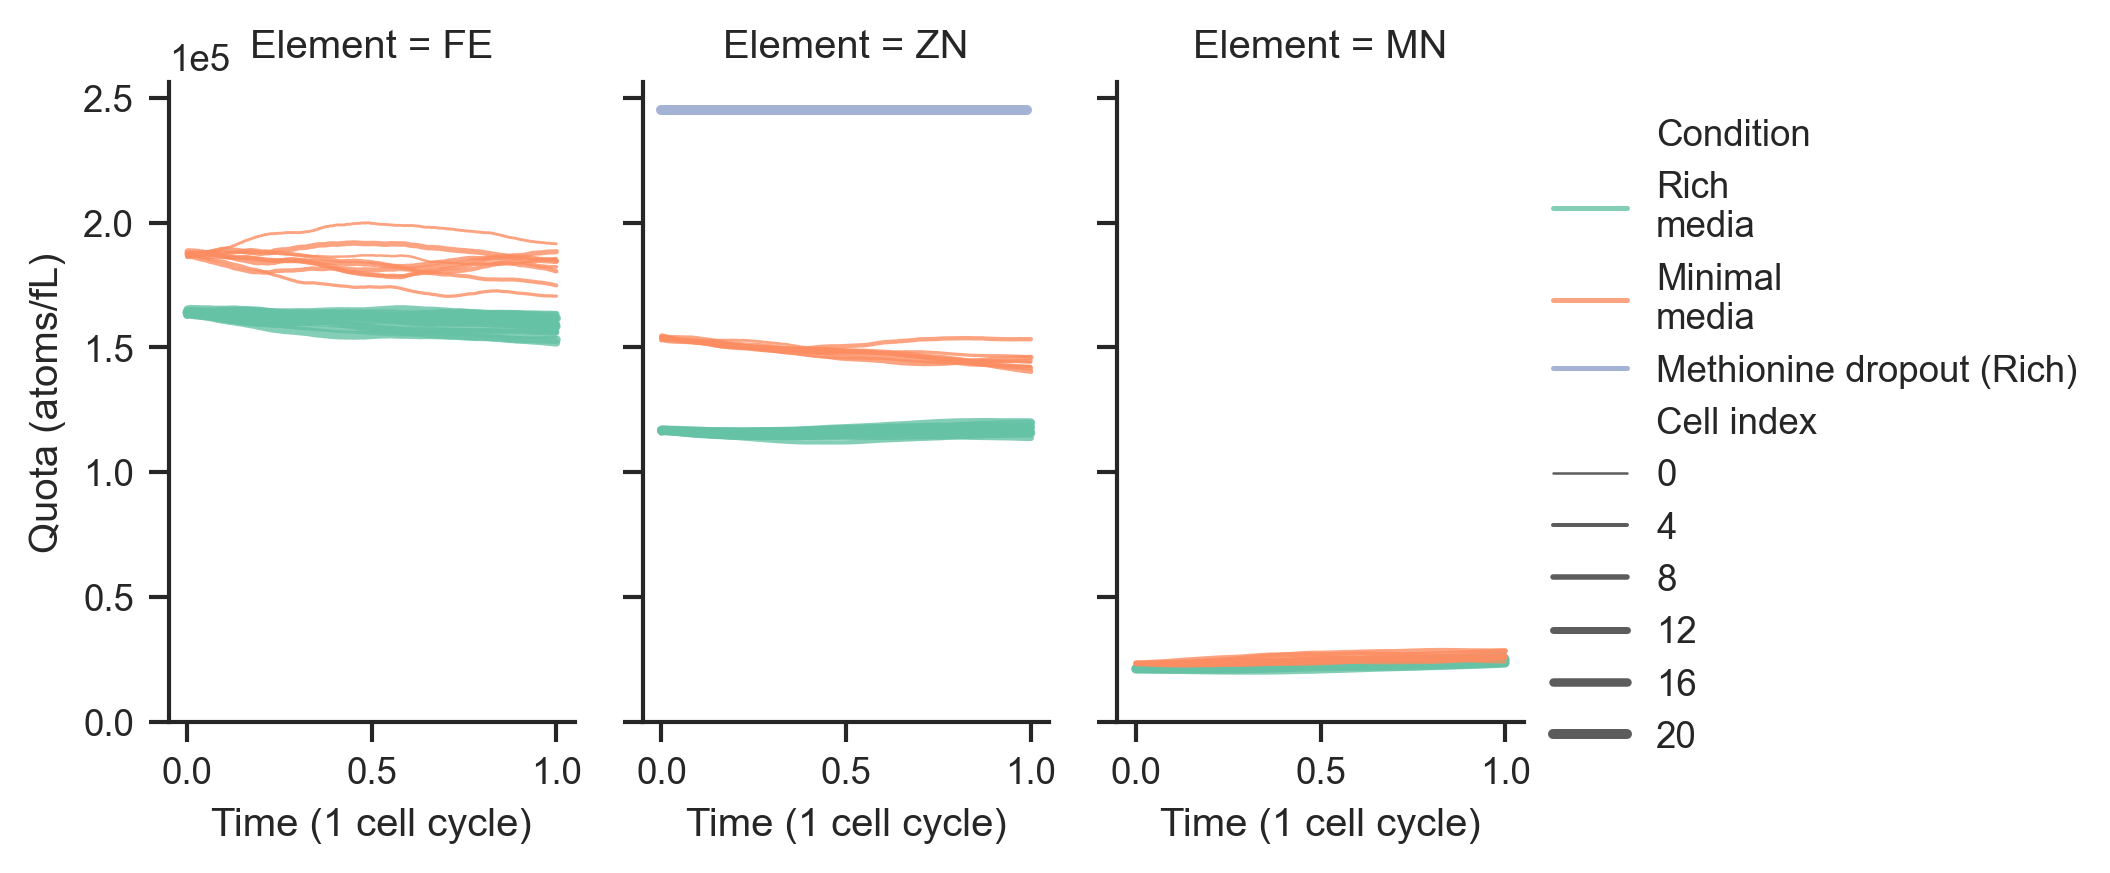

In [71]:
# plot zn quota for different cells
sns.relplot(data=zn_quota_df.to_pandas(), x="Time (1 cell cycle)", 
            y="Quota (atoms/fL)", 
            hue="Condition", 
            size="Cell index",
            col="Element",
            kind="line", aspect=0.6, height=3, alpha=0.8, legend='brief',
            # facet_kws={'sharex': False}
            )

plt.ylim(0, None)

# save as svg
plt.savefig("figures/zn_quota.svg", transparent=True)

In [72]:
# filter zn_quota_df to only include ZN and not methionine dropout
zn_quota_df_grp = zn_quota_df.filter((pl.col("Element") == "ZN") & (pl.col("Condition") != "Methionine dropout (Rich)"))

# average across time again
zn_quota_df_grp = zn_quota_df_grp.group_by(["Cell index", "Condition", "Element"]).agg(pl.mean("Quota (atoms/fL)").alias("Zn quota (atoms/fL)"))

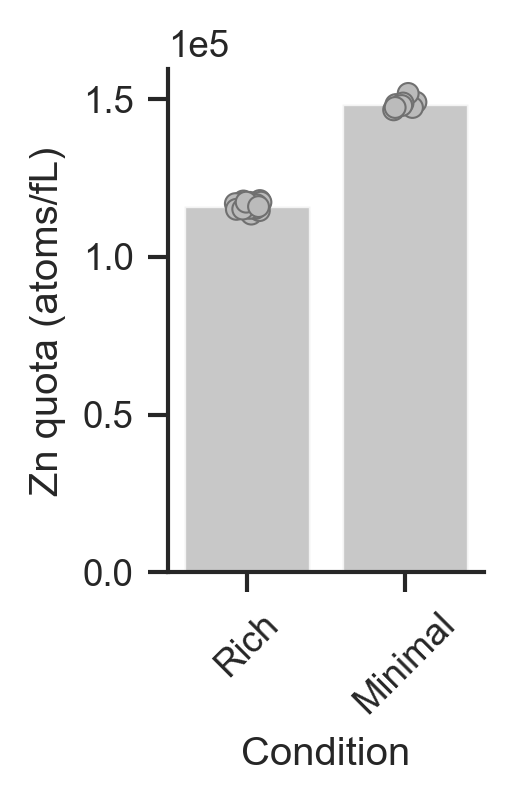

In [73]:
# change palette to gray, gray
palette = ['#BBBBBB', '#BBBBBB']

zn_quota_display_df = zn_quota_df_grp

# replace replace Condition name from dict
condition_replacement_dict = {"Rich\nmedia": "Rich", "Minimal\nmedia": "Minimal"}
order = ["Rich", "Minimal"]

zn_quota_display_df = zn_quota_display_df.with_columns(pl.col("Condition").replace(condition_replacement_dict))

# make a barplot instead
g = sns.catplot(data=zn_quota_display_df.to_pandas(), x="Condition", y="Zn quota (atoms/fL)", hue="Condition",  kind="bar",
                order=order, hue_order=order, aspect=0.72, height=2.5, alpha=0.8, legend=False,palette=palette)

# add a strip plot on top
g.map_dataframe(sns.stripplot, x="Condition", y="Zn quota (atoms/fL)", hue="Condition", dodge=False, alpha=1, 
                palette=palette,
                order=order, hue_order=order, linewidth=0.5)


# plt.xticks(ticks=[])

# rotate xticks and change offset
plt.xticks(rotation=45,)

# save as svg
plt.savefig("figures/zn_quota_barplot.svg", transparent=True)

## # Compare different real bulk data sets

# Story 1: 

## Barplot of the top 50 zinc proteins instead of sankey

In [74]:
elements = ["ZN"]

element_indices = [np.where(element_ids == element)[0][0] for element in elements]

count_vec = total_counts_min[int(total_counts_min.shape[0]/2), :]

zn_protein = np.diag(count_vec) @ C @ P @ E[:, element_indices]

# argsort the vector
top_50_proteins = np.argsort(zn_protein.flatten())[-100:]

# get protein names
protein_names = [protein_ids[i] for i in top_50_proteins]

# get the counts
protein_counts = [zn_protein[i][0] for i in top_50_proteins]

# Li et al data

In [75]:
li = pl.read_csv("external_data/Li_2014_profiling.csv")
li


shape: (4_095, 4)
┌──────┬───────────────┬──────────────┬─────────────────────────────────┐
│ Gene ┆ MOPS complete ┆ MOPS minimal ┆ MOPS complete without methioni… │
│ ---  ┆ ---           ┆ ---          ┆ ---                             │
│ str  ┆ i64           ┆ i64          ┆ i64                             │
╞══════╪═══════════════╪══════════════╪═════════════════════════════════╡
│ aaeA ┆ 62            ┆ 5            ┆ 21                              │
│ aaeB ┆ 16            ┆ 2            ┆ 0                               │
│ aaeR ┆ 203           ┆ 79           ┆ 141                             │
│ aaeX ┆ 28            ┆ 5            ┆ 11                              │
│ aas  ┆ 188           ┆ 80           ┆ 162                             │
│ …    ┆ …             ┆ …            ┆ …                               │
│ zraR ┆ 98            ┆ 30           ┆ 50                              │
│ zraS ┆ 8             ┆ 4            ┆ 0                               │
│ zupT ┆ 407           ┆ 217          ┆ 295                             │
│ zur  ┆ 333           ┆ 167          ┆ 582                             │
│ zwf  ┆ 5185          ┆ 1928         ┆ 3262                            │
└──────┴───────────────┴──────────────┴─────────────────────────────────┘

In [76]:

name_df = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")
# drop non unique rows for Common-Name
name_df = name_df.unique(subset=["Common-Name"])

name_df

shape: (4_313, 4)
┌─────────────────┬──────────┬─────────────────────┬─────────────┐
│ Proteins        ┆ Genes    ┆ Accession-1 of Gene ┆ Common-Name │
│ ---             ┆ ---      ┆ ---                 ┆ ---         │
│ str             ┆ str      ┆ str                 ┆ str         │
╞═════════════════╪══════════╪═════════════════════╪═════════════╡
│ G7423-MONOMER   ┆ G7423    ┆ b2747               ┆ ispD        │
│ EG10845-MONOMER ┆ EG10845  ┆ b3783               ┆ rho         │
│ B0260-MONOMER   ┆ G6135    ┆ b0260               ┆ mmuP        │
│ YNEA-MONOMER    ┆ G6803    ┆ b1516               ┆ lsrB        │
│ MONOMER0-1      ┆ EG11140  ┆ b1914               ┆ uvrY        │
│ …               ┆ …        ┆ …                   ┆ …           │
│ EG11726-MONOMER ┆ EG11726  ┆ b3716               ┆ cbrB        │
│ MONOMER0-4426   ┆ G0-16743 ┆ b4749               ┆ ynfR        │
│ G7514-MONOMER   ┆ G7514    ┆ b2902               ┆ ygfF        │
│ XYLE-MONOMER    ┆ EG11076  ┆ b4031               ┆ xylE        │
│ G7452-MONOMER   ┆ G7452    ┆ b2794               ┆ queF        │
└─────────────────┴──────────┴─────────────────────┴─────────────┘

In [77]:
li_df = li.join(name_df, left_on="Gene", right_on="Common-Name")
li_df

shape: (3_747, 7)
┌──────┬───────────────┬──────────────┬────────────────┬────────────────┬─────────┬────────────────┐
│ Gene ┆ MOPS complete ┆ MOPS minimal ┆ MOPS complete  ┆ Proteins       ┆ Genes   ┆ Accession-1 of │
│ ---  ┆ ---           ┆ ---          ┆ without        ┆ ---            ┆ ---     ┆ Gene           │
│ str  ┆ i64           ┆ i64          ┆ methioni…      ┆ str            ┆ str     ┆ ---            │
│      ┆               ┆              ┆ ---            ┆                ┆         ┆ str            │
│      ┆               ┆              ┆ i64            ┆                ┆         ┆                │
╞══════╪═══════════════╪══════════════╪════════════════╪════════════════╪═════════╪════════════════╡
│ ispD ┆ 485           ┆ 123          ┆ 314            ┆ G7423-MONOMER  ┆ G7423   ┆ b2747          │
│ rho  ┆ 17921         ┆ 3478         ┆ 9251           ┆ EG10845-MONOME ┆ EG10845 ┆ b3783          │
│      ┆               ┆              ┆                ┆ R              ┆         ┆                │
│ mmuP ┆ 39            ┆ 64           ┆ 2791           ┆ B0260-MONOMER  ┆ G6135   ┆ b0260          │
│ lsrB ┆ 8             ┆ 28           ┆ 3              ┆ YNEA-MONOMER   ┆ G6803   ┆ b1516          │
│ uvrY ┆ 880           ┆ 412          ┆ 722            ┆ MONOMER0-1     ┆ EG11140 ┆ b1914          │
│ …    ┆ …             ┆ …            ┆ …              ┆ …              ┆ …       ┆ …              │
│ dppC ┆ 391           ┆ 231          ┆ 214            ┆ DPPC-MONOMER   ┆ EG12626 ┆ b3542          │
│ cbrB ┆ 32            ┆ 7            ┆ 9              ┆ EG11726-MONOME ┆ EG11726 ┆ b3716          │
│      ┆               ┆              ┆                ┆ R              ┆         ┆                │
│ ygfF ┆ 28            ┆ 37           ┆ 18             ┆ G7514-MONOMER  ┆ G7514   ┆ b2902          │
│ xylE ┆ 0             ┆ 0            ┆ 0              ┆ XYLE-MONOMER   ┆ EG11076 ┆ b4031          │
│ queF ┆ 1522          ┆ 318          ┆ 889            ┆ G7452-MONOMER  ┆ G7452   ┆ b2794          │
└──────┴───────────────┴──────────────┴────────────────┴────────────────┴─────────┴────────────────┘

In [78]:
# make a list where for each name in monomer_ids,  the corresponding counts in MOPS minimal from li is inserted
# if not found, insert 0
li_counts = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_min = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS minimal"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]
li_counts_met = [li_df.filter(pl.col("Proteins") == protein)[0, "MOPS complete without methionine"] if len(li_df.filter(pl.col("Proteins") == protein)) > 0 else 0 for protein in monomer_ids]


li_counts = np.array(li_counts).flatten().astype(int)
li_counts_min = np.array(li_counts_min).flatten().astype(int)
li_counts_met = np.array(li_counts_met).flatten().astype(int)

# save to csv 
np.savetxt('data/li_counts.csv', np.array(li_counts, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_min.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')
np.savetxt('data/li_counts_met.csv', np.array(li_counts_min, dtype=np.int64), delimiter=',', fmt='%i')

In [79]:
elements = ["FE", "ZN"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

M = (P @ E[:, element_indices]).toarray()

# make a new array. For each column of M, multiply it elementwise by the li_counts vector
for i in range(M.shape[1]):
    M[:, i] = np.multiply(M[:, i], li_counts_met)

# create polars dataframe. cols are elements, rows are protein_ids
M_df = pl.DataFrame(M, schema=elements)

# add protein_ids as a column
M_df = M_df.with_columns(pl.DataFrame(monomer_ids, schema=["Protein ID"]))

# melt to long form
M_df = M_df.melt(id_vars="Protein ID", value_name="Atoms/cell", variable_name="Element")

In [80]:
M_df.filter((pl.col("Element") == "ZN") & (pl.col("Atoms/cell") > 0))

shape: (124, 3)
┌───────────────────────────────┬─────────┬────────────┐
│ Protein ID                    ┆ Element ┆ Atoms/cell │
│ ---                           ┆ ---     ┆ ---        │
│ str                           ┆ str     ┆ i64        │
╞═══════════════════════════════╪═════════╪════════════╡
│ ACETYLORNDEACET-MONOMER       ┆ ZN      ┆ 628        │
│ ADENODEAMIN-MONOMER           ┆ ZN      ┆ 548        │
│ ADHC-MONOMER                  ┆ ZN      ┆ 3116       │
│ ADHP-MONOMER                  ┆ ZN      ┆ 42         │
│ ALAS-MONOMER                  ┆ ZN      ┆ 5773       │
│ …                             ┆ …       ┆ …          │
│ UDPACYLGLCNACDEACETYL-MONOMER ┆ ZN      ┆ 3773       │
│ USHA-MONOMER                  ┆ ZN      ┆ 926        │
│ YHHO-MONOMER                  ┆ ZN      ┆ 36         │
│ YPHC-MONOMER                  ┆ ZN      ┆ 56         │
│ ZNUA-MONOMER                  ┆ ZN      ┆ 57733      │
└───────────────────────────────┴─────────┴────────────┘

# Show that fraction of Zn proteome changes across conditions

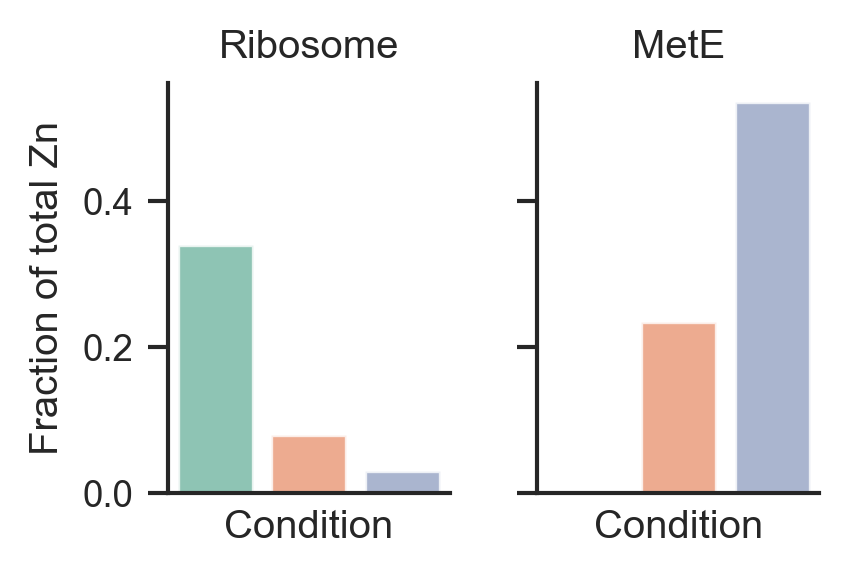

In [81]:
cofactors = ["ZN+2"]
cofactor_indices = [np.where(cofactor_ids == cofactor)[0][0] for cofactor in cofactors]

# get indices of Zn-containing proteins
zn_protein_vec = P[:, cofactor_indices].toarray().flatten()

# create df and join with li_df
zn_df = pl.DataFrame([monomer_ids, zn_protein_vec], schema=["Protein ID", "Zn stoichiometry"])

# join with name df to get common names
li_df_m = li_df.melt(id_vars=["Proteins", "Gene", "Genes", "Accession-1 of Gene"], value_name="Protein count", variable_name="Condition")
li_df_join = li_df_m.join(zn_df, left_on="Proteins", right_on="Protein ID")

# filter out periplasmic zinc proteins
li_df_join = li_df_join.filter((pl.col("Gene") != "zinT") & (pl.col("Gene") != "znuA"))

# multiply protein count by Zn stoichiometry
li_df_join = li_df_join.with_columns( (li_df_join["Protein count"] * li_df_join["Zn stoichiometry"]).alias("Zn atoms/cell"))

# Add column that's sum per Condition
sum_df = li_df_join.group_by("Condition").agg(pl.sum("Zn atoms/cell").alias("Total Zn atoms/cell"))
li_df_join = li_df_join.join(sum_df, on="Condition")

# calculate fraciton of total
li_df_join = li_df_join.with_columns( (li_df_join["Zn atoms/cell"] / li_df_join["Total Zn atoms/cell"]).alias("Fraction of total Zn"))

# filter gene to be either rpmE or metE
li_df_f = li_df_join.filter((pl.col("Gene") == "rpmE") | (pl.col("Gene") == "metE"))

# for li_df_f, when "MOPS complete without methionine" appears, insert a newline after complete
li_df_f = li_df_f.with_columns(pl.col("Condition").str.replace(r"MOPS complete without methionine", "MOPS complete\nwithout methionine"))

# rename condition values using the dict below
li_renaming_dict = {"MOPS complete": "Rich\n medium", "MOPS minimal": "Minimal\n medium", "MOPS complete\nwithout methionine": "Rich\n medium,\n-met"}

# rename values in the Gene column
li_renaming_dict_gene = {"rpmE": "Ribosome", "metE": "MetE"}

# create new column with renamed values
li_df_rn = li_df_f.with_columns(pl.col("Condition").replace(li_renaming_dict).alias("Condition"))
li_df_rn = li_df_rn.with_columns(pl.col("Gene").replace(li_renaming_dict_gene).alias("Gene"))
li_df_rn

# plot as barplot
g = sns.catplot(data=li_df_rn.to_pandas(), x="Condition", y="Fraction of total Zn", col="Gene",
            hue="Condition", kind="bar", aspect=0.6, height=2.5, alpha=0.8)

# change col formatting
g.set_titles(col_template="{col_name}")

# remove xticklabels
plt.xticks(ticks=[])

plt.savefig("figures/mete_rib_frac_of_total_zn.svg", transparent=True)

In [82]:
li_df_join.filter((pl.col("Gene") != "zinT") & (pl.col("Gene") != "znuA")).group_by("Condition").agg(pl.sum("Zn atoms/cell").alias("Total Zn atoms/cell"))

shape: (3, 2)
┌─────────────────────────────────┬─────────────────────┐
│ Condition                       ┆ Total Zn atoms/cell │
│ ---                             ┆ ---                 │
│ str                             ┆ i64                 │
╞═════════════════════════════════╪═════════════════════╡
│ MOPS complete without methioni… ┆ 528894              │
│ MOPS complete                   ┆ 533160              │
│ MOPS minimal                    ┆ 271970              │
└─────────────────────────────────┴─────────────────────┘

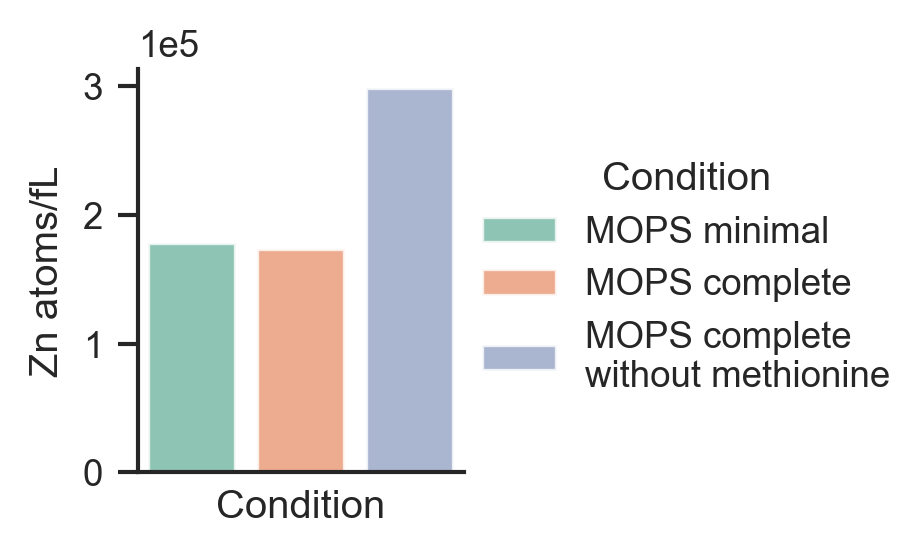

In [83]:
volumes = [["MOPS complete", 3.08, 533160],[ "MOPS minimal", 1.53, 271970], ["MOPS complete\nwithout methionine", 9.5/16.5 * 3.08, 528894]]

# create df 
homeo_df = pl.DataFrame(volumes, schema=["Condition", "Volume (fL)", "Zn atoms/cell"])

# create new column with Zn atoms/fL
homeo_df = homeo_df.with_columns( (homeo_df["Zn atoms/cell"] / homeo_df["Volume (fL)"]).alias("Zn atoms/fL"))

# plot as barplot
order = ["MOPS minimal", "MOPS complete", "MOPS complete\nwithout methionine"]
sns.catplot(data=homeo_df.to_pandas(), x="Condition", y="Zn atoms/fL", kind="bar",hue="Condition" ,
            aspect=0.93, height=2.3, order=order, hue_order=order, legend=True, alpha=0.8)

# remove xticklabels
plt.xticks(ticks=[])

# save as svg
plt.savefig("figures/zn_fraction_of_total_zn_homeostasis.svg", transparent=True)

## Create comparison plot between methionine and dropout

In [84]:
cofactors = ["ZN+2"]
cofactor_indices = [np.where(cofactor_ids == cofactor)[0][0] for cofactor in cofactors]

# get indices of Zn-containing proteins
zn_protein_mask = P[:, cofactor_indices].toarray().flatten() > 0 

# get all ribosome proteins
ribosome_id = ['CPLX0-3964']
ribosome_indices = [np.where(protein_ids == protein)[0][0] for protein in ribosome_id]
ribosome_protein_mask = C[ribosome_indices, :].toarray().flatten() > 0

# nonstandard ribosomal protein
nonstandard_ribosome_id = ['G6167-MONOMER','MONOMER0-2656', ]
nonstandard_ribosome_indices = [np.where(monomer_ids == protein)[0][0] for protein in nonstandard_ribosome_id]
nonstandard_ribosome_protein_mask = np.zeros(len(monomer_ids), dtype=bool)
nonstandard_ribosome_protein_mask[nonstandard_ribosome_indices] = True

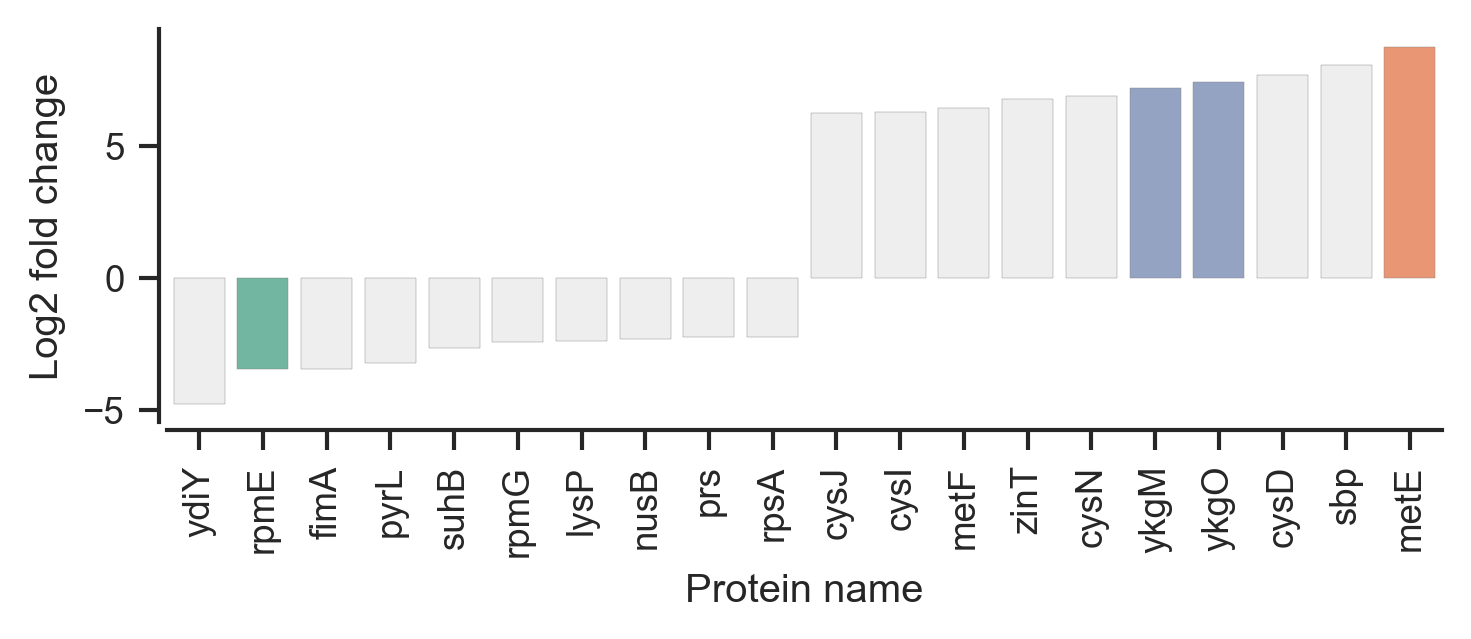

In [85]:
# create dataframe with the counts
li_df = pl.DataFrame([li_counts, li_counts_met, monomer_ids, zn_protein_mask, ribosome_protein_mask, nonstandard_ribosome_protein_mask], 
                     schema=["Complete", "Methionine", "Protein ID", "Uses Zn", "Ribosomal protein", "Nonstandard ribosomal protein"])

# create new conditional column. If both Uses Zn and Ribosomal protein are true, then "Ribosomal protein with Zn"
li_df = li_df.with_columns(pl.lit("N/A").alias("Protein type"))

# iterate over rows
for i in range(li_df.shape[0]):
    if li_df[i, "Uses Zn"] and li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Zn-using standard\nribosomal protein"
    elif li_df[i, "Ribosomal protein"]:
        li_df[i, "Protein type"] = "Other protein"\
        # li_df[i, "Protein type"] =                "Standard ribosomal protein"
    elif li_df[i, "Nonstandard ribosomal protein"]:
        li_df[i, "Protein type"] = "Zn-free nonstandard\nribosomal protein"
    elif li_df[i, "Protein ID"] == "HOMOCYSMET-MONOMER":
        li_df[i, "Protein type"] = "MetE"
    # elif li_df[i, "Uses Zn"]:
    #     li_df[i, "Protein type"] = "Zn-protein"
    else:
        li_df[i, "Protein type"] = "Other protein"


# join with name df to get common names
li_df = li_df.join(name_df, left_on="Protein ID", right_on="Proteins")

# drop rows where both complete and methionine are <1000
li_df = li_df.filter((pl.col("Complete") > 10) | (pl.col("Methionine") > 10))
# li_df = li_df.filter((pl.col("Complete") > 200) & (pl.col("Methionine") > 200))


reg = 100
# calculate fold change from complete to methionine
li_df = li_df.with_columns( ((li_df["Methionine"] + reg) / (li_df["Complete"] + reg)).alias("Fold change"))

# take log2 of fold change
li_df = li_df.with_columns( (np.log2(li_df["Fold change"])).alias("Log2 fold change"))

# sort by fold change
li_df = li_df.sort("Log2 fold change", descending=False)

# make new df with just head and tail
n = 10
li_df_head = li_df.head(n).with_columns(pl.lit("Decrease").alias("Type"))
li_df_tail = li_df.tail(n).with_columns(pl.lit("Increase").alias("Type"))
# concat
li_df_short = pl.concat([li_df_head, li_df_tail, ])
                         # li_df_head])

# Rename Common-Name to Protein ID
li_df_short = li_df_short.rename({"Common-Name": "Protein name"})

# create a palette with 5 colors. 1 Gray, then 4 Set2 colors
palette = ["#EEEEEE"] + sns.color_palette("Set2", n_colors=4)

# make hue order


# plt.figure(figsize=[4,4])

# plot log fold change against protein id
hue_order = ["Other protein", "Zn-using standard\nribosomal protein", "MetE", "Zn-free nonstandard\nribosomal protein"]

# make a catplot
g = sns.catplot(data=li_df_short.to_pandas(), x="Protein name", y="Log2 fold change",
                 kind="bar", aspect=2.5, height=2,
                hue="Protein type",hue_order=hue_order, palette=palette, legend=False,
                linewidth=0.1, edgecolor="grey"
                )

# g = sns.barplot(data=li_df_short.to_pandas(), x="Protein name", hue="Protein type",
#                 # dodge=False,
#                 hue_order = hue_order,
#                 y="Log2 fold change", palette=palette,)

#
# g = sns.barplot(data=li_df_short.to_pandas(), x="Protein name", # hue="Protein type",
#                 # dodge=False,
#                 y="Log2 fold change", palette=palette, hue_order=hue_order, bottom=1, log=True)

# convert to log scale
# g.set(yscale="log")

sns.despine(offset=2, trim=False)

# rotate labels
plt.xticks(rotation=90)

# remove xticks
# plt.xticks(ticks=[], labels=[])

# save as png and svg
plt.savefig("figures/li_fold_change.svg")

In [86]:
li_df_short

shape: (20, 13)
┌──────────┬────────────┬────────────┬─────────┬───┬────────────┬───────────┬───────────┬──────────┐
│ Complete ┆ Methionine ┆ Protein ID ┆ Uses Zn ┆ … ┆ Protein    ┆ Fold      ┆ Log2 fold ┆ Type     │
│ ---      ┆ ---        ┆ ---        ┆ ---     ┆   ┆ name       ┆ change    ┆ change    ┆ ---      │
│ i64      ┆ i64        ┆ str        ┆ bool    ┆   ┆ ---        ┆ ---       ┆ ---       ┆ str      │
│          ┆            ┆            ┆         ┆   ┆ str        ┆ f64       ┆ f64       ┆          │
╞══════════╪════════════╪════════════╪═════════╪═══╪════════════╪═══════════╪═══════════╪══════════╡
│ 5888     ┆ 117        ┆ G6928-MONO ┆ false   ┆ … ┆ ydiY       ┆ 0.036239  ┆ -4.786307 ┆ Decrease │
│          ┆            ┆ MER        ┆         ┆   ┆            ┆           ┆           ┆          │
│ 181267   ┆ 16272      ┆ EG10889-MO ┆ true    ┆ … ┆ rpmE       ┆ 0.09027   ┆ -3.46961  ┆ Decrease │
│          ┆            ┆ NOMER      ┆         ┆   ┆            ┆           ┆           ┆          │
│ 14269    ┆ 1218       ┆ EG10308-MO ┆ false   ┆ … ┆ fimA       ┆ 0.091725  ┆ -3.446537 ┆ Decrease │
│          ┆            ┆ NOMER      ┆         ┆   ┆            ┆           ┆           ┆          │
│ 1097     ┆ 28         ┆ EG11279-MO ┆ false   ┆ … ┆ pyrL       ┆ 0.106934  ┆ -3.225207 ┆ Decrease │
│          ┆            ┆ NOMER      ┆         ┆   ┆            ┆           ┆           ┆          │
│ 11711    ┆ 1767       ┆ EG10983-MO ┆ false   ┆ … ┆ suhB       ┆ 0.158073  ┆ -2.661337 ┆ Decrease │
│          ┆            ┆ NOMER      ┆         ┆   ┆            ┆           ┆           ┆          │
│ …        ┆ …          ┆ …          ┆ …       ┆ … ┆ …          ┆ …         ┆ …         ┆ …        │
│ 487      ┆ 85458      ┆ G6167-MONO ┆ false   ┆ … ┆ ykgM       ┆ 145.75468 ┆ 7.187398  ┆ Increase │
│          ┆            ┆ MER        ┆         ┆   ┆            ┆ 5         ┆           ┆          │
│ 493      ┆ 101366     ┆ MONOMER0-2 ┆ false   ┆ … ┆ ykgO       ┆ 171.10623 ┆ 7.418749  ┆ Increase │
│          ┆            ┆ 656        ┆         ┆   ┆            ┆ 9         ┆           ┆          │
│ 10       ┆ 22588      ┆ CYSD-MONOM ┆ false   ┆ … ┆ cysD       ┆ 206.25454 ┆ 7.688282  ┆ Increase │
│          ┆            ┆ ER         ┆         ┆   ┆            ┆ 5         ┆           ┆          │
│ 7        ┆ 28069      ┆ SBP-MONOME ┆ false   ┆ … ┆ sbp        ┆ 263.26168 ┆ 8.040354  ┆ Increase │
│          ┆            ┆ R          ┆         ┆   ┆            ┆ 2         ┆           ┆          │
│ 571      ┆ 282818     ┆ HOMOCYSMET ┆ true    ┆ … ┆ metE       ┆ 421.63636 ┆ 8.719855  ┆ Increase │
│          ┆            ┆ -MONOMER   ┆         ┆   ┆            ┆ 4         ┆           ┆          │
└──────────┴────────────┴────────────┴─────────┴───┴────────────┴───────────┴───────────┴──────────┘

## Growth rate data

In [87]:
gr = pl.read_csv("data/growth_rate_processed.csv")

# rename slope to Growth rate
gr = gr.rename({"slope": "Growth rate (1/hr)", "doubling_time": "Doubling time (h)", "doubling_time_min": "Doubling time (min)"})

# Only keep columns Additive, Replicate, Growth rate
gr = gr.select("Additive", "Growth rate (1/hr)")

gr


shape: (12, 2)
┌──────────┬────────────────────┐
│ Additive ┆ Growth rate (1/hr) │
│ ---      ┆ ---                │
│ str      ┆ f64                │
╞══════════╪════════════════════╡
│ B12      ┆ 1.118869           │
│ B12      ┆ 1.060833           │
│ B12      ┆ 1.102755           │
│ Zn       ┆ 1.068039           │
│ Zn       ┆ 1.102385           │
│ …        ┆ …                  │
│ met      ┆ 1.180368           │
│ met      ┆ 1.172544           │
│ none     ┆ 1.010952           │
│ none     ┆ 1.010328           │
│ none     ┆ 1.015693           │
└──────────┴────────────────────┘

In [88]:
# get mean of growth rate for met
met_mean = gr.filter(pl.col("Additive") == "met").mean().select("Growth rate (1/hr)")

# add a column with met_mean as the value
gr = gr.with_columns(pl.lit(met_mean).alias("Mean growth rate (1/hr)"))

# calculate growth rate decrease from mean
gr = gr.with_columns( ((gr["Growth rate (1/hr)"] / gr["Mean growth rate (1/hr)"])).alias("Growth rate defect"))

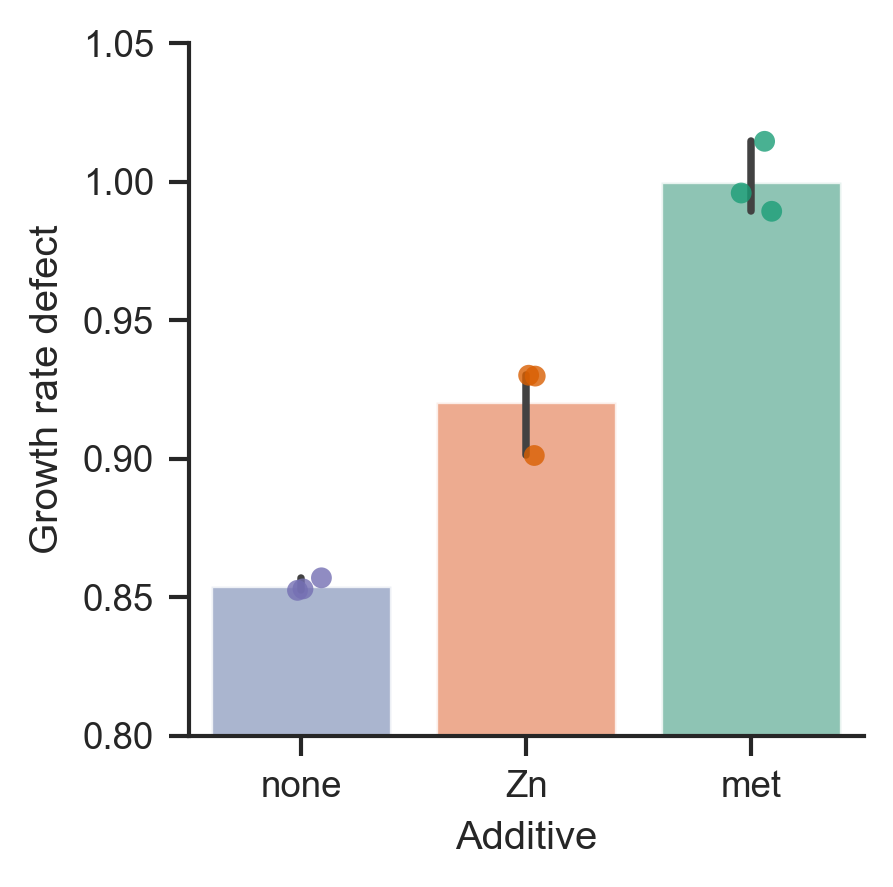

In [89]:
hue_order = ["met", "Zn", "none"]

# remove B12
gr_filter = gr.filter((pl.col("Additive") != "B12"))

order = ["none", "Zn", "met"]
g = sns.catplot(data=gr_filter.to_pandas(), x="Additive", y="Growth rate defect", hue="Additive",
                kind="bar", aspect=1, height=3, alpha=0.8, hue_order=hue_order, order=order, errorbar="ci")

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate defect", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', 
                linewidth=0, hue_order=hue_order, order=order,)

plt.ylim(0.8, 1.05)

# save as png and svg
plt.savefig("figures/growth_rate_defect.svg")

# save dataframe as csv
gr_filter.write_csv("data/met_zn_growth_rate_data.csv", include_header=True)

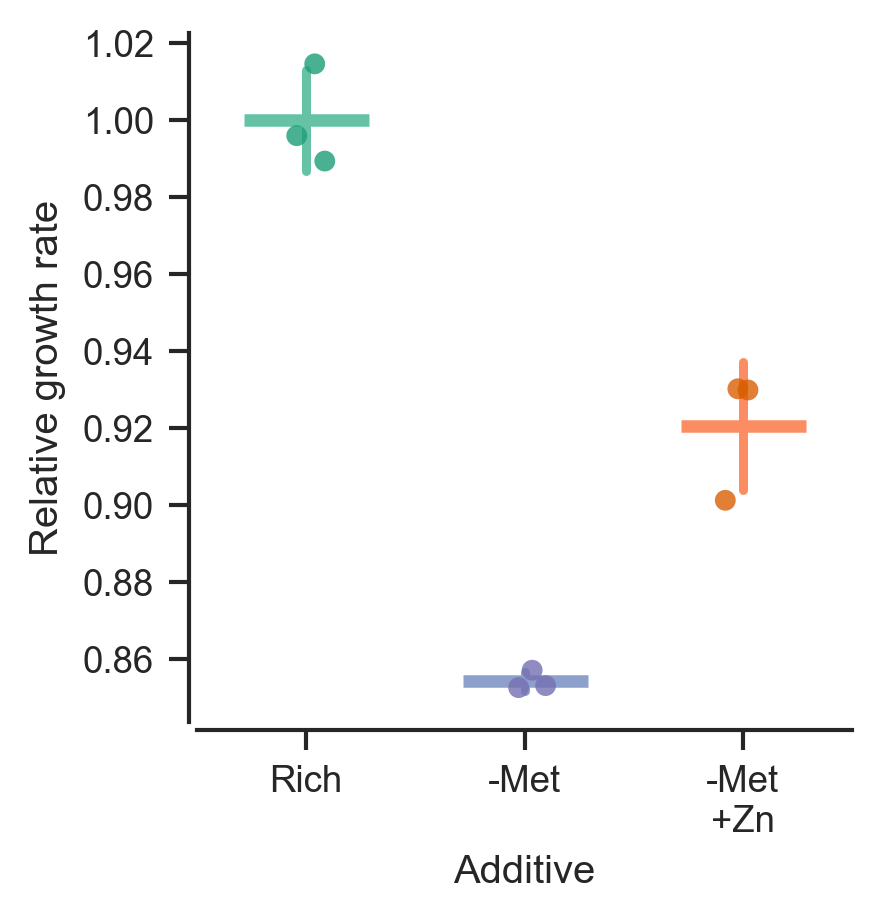

In [90]:
# create modified plot where met is first, then none, then Zn
hue_order = ["met", "Zn", "none"]
order = ["met", "none", "Zn"]

# remove B12
gr_filter = gr.filter((pl.col("Additive") != "B12"))

g = sns.catplot(data=gr_filter.to_pandas(), x="Additive", y="Growth rate defect", hue="Additive",
                kind="point", aspect=1, height=3, alpha=1, hue_order=hue_order, order=order, errorbar="sd",marker="_", markersize=30, markeredgewidth=3,)

g.map_dataframe(sns.stripplot, x="Additive", y="Growth rate defect", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', 
                linewidth=0., hue_order=hue_order, order=order,)

# add fat horizontal line at y=1, arrange to back
# #plt.axhline(1, color='black', linewidth=3, zorder=-1)

# change x tick labels
plt.xticks(ticks=[0, 1, 2], labels=["Rich", "-Met", "-Met\n+Zn"])

# change y axis label
plt.ylabel("Relative growth rate")

sns.despine(offset=2, trim=False)

# plt.ylim(0.8, 1.05)

# save as png and svg
plt.savefig("figures/growth_rate_defect.svg")

In [114]:
# calculate p values
from scipy.stats import ttest_ind
# get the data for met and zn
met_data = gr_filter.filter(pl.col("Additive") == "met")["Growth rate defect"].to_numpy()
none_data = gr_filter.filter(pl.col("Additive") == "none")["Growth rate defect"].to_numpy()
zn_data = gr_filter.filter(pl.col("Additive") == "Zn")["Growth rate defect"].to_numpy()


# perform t-test
t_stat, p_value = ttest_ind(met_data, zn_data)
print(f"T-test between met and Zn: t-statistic = {t_stat}, p-value = {p_value}")

t_stat, p_value = ttest_ind(met_data, none_data)
print(f"T-test between met and none: t-statistic = {t_stat}, p-value = {p_value}")

T-test between met and Zn: t-statistic = 6.506947008043972, p-value = 0.0028785738486647315
T-test between met and none: t-statistic = 18.935935765984834, p-value = 4.581128146153579e-05


In [115]:
# get the raw data and raw linear data
r_gr = pl.read_csv("data/growth_rate_raw.csv")
l_gr = pl.read_csv("data/growth_rate_raw_linear.csv")


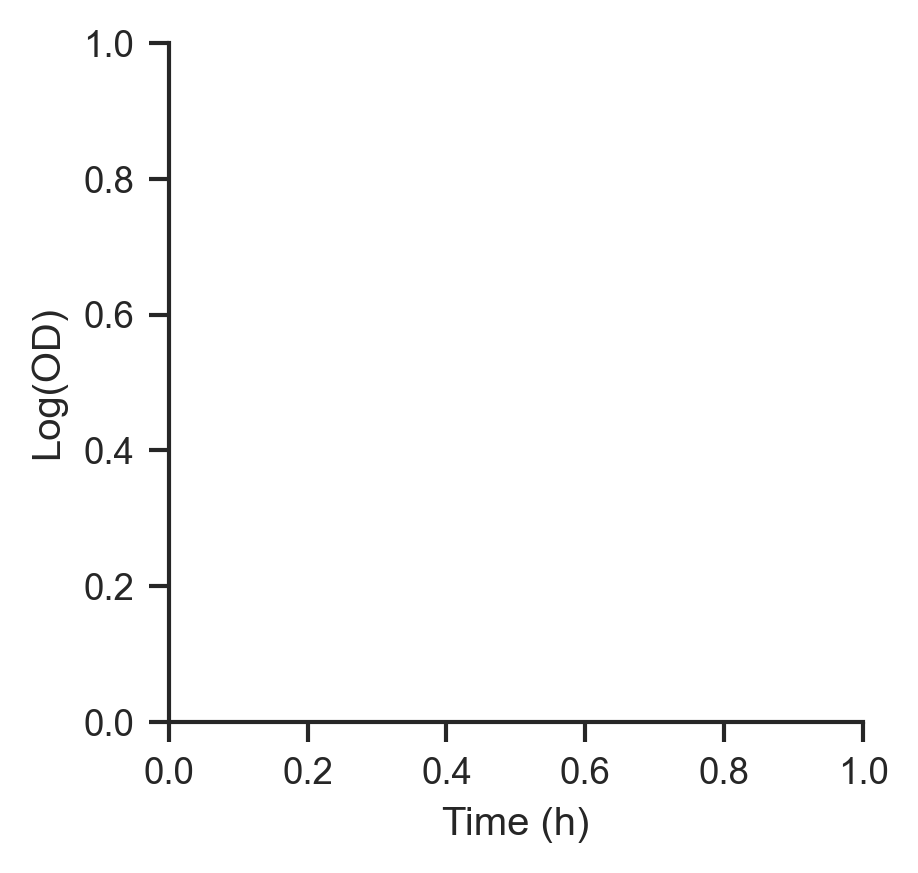

In [116]:
l_gr_filter = l_gr.filter((pl.col("Additive") != "B12"))

sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
           # col_wrap=4,  \
           # hue_order=["none", "Zn", "B12", "met"],
           height=3,aspect=1.05, legend=False,
           data=l_gr_filter.to_pandas(), scatter_kws = {"alpha": 0.1}, hue_order=hue_order)

# change ylabel to Log(OD600)
plt.ylabel("Log(OD)")
plt.xlabel("Time (h)")

# save as png and svg
plt.savefig("figures/growth_rate_raw_linear.png")
plt.savefig("figures/growth_rate_raw_linear.svg")

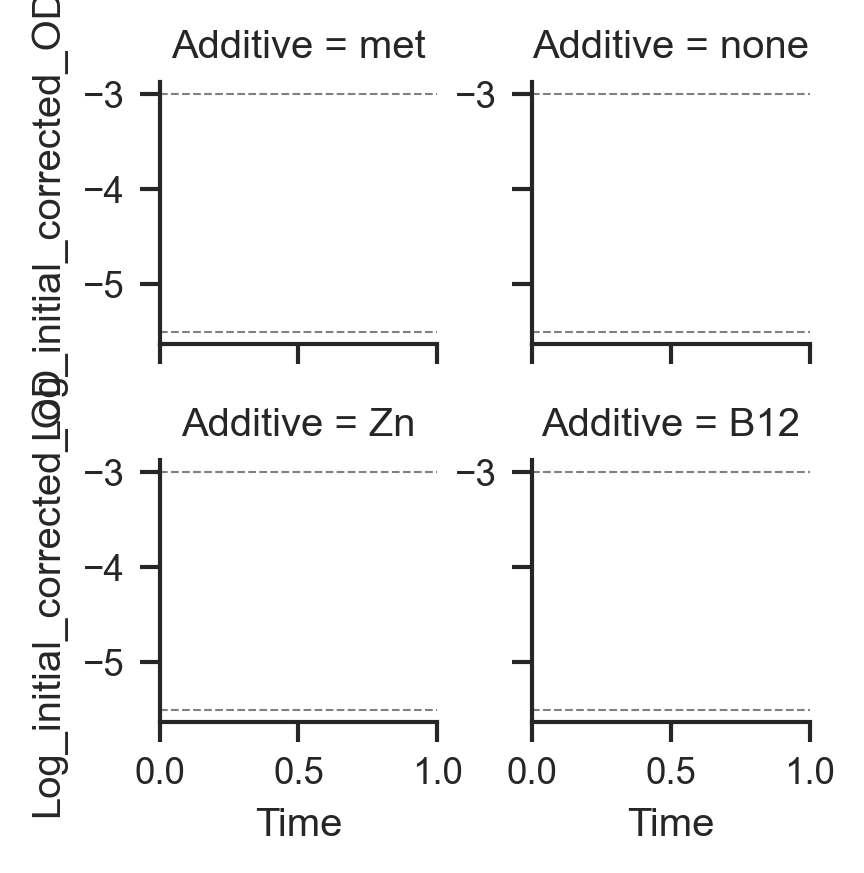

In [117]:

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Additive", kind="line", col="Additive", style="Replicate", 
                height=1.5, \
                col_wrap=2, 
                data=r_gr.to_pandas(), legend=False, hue_order=hue_order)
    
# plot horizontal lines at y=-2
for ax in plt.gcf().axes:
    ax.axhline(-3, color='grey', linewidth=0.5, linestyle='--')
    ax.axhline(-5.5, color='grey', linewidth=0.5, linestyle='--')

## Transporter mean and noise

In [118]:
total_counts_zn_df

# select columns with a minimum larger than 100
total_counts_zn_df_s = total_counts_zn_df.select(pl.all().min() > 500)
include = {k: v[0] for k,v in total_counts_zn_df_s.to_dict(as_series=False).items()}
include = [k for k,v in include.items() if v][0:10]

# select columns where total_counts_zn_df_pruned is true
total_counts_zn_df_pruned = total_counts_zn_df.select(include)

# calculate the difference from previous step
diff_df = total_counts_zn_df_pruned.with_columns( (total_counts_zn_df_pruned - total_counts_zn_df_pruned.shift(1)))
                                     
# melt
diff_df = diff_df.with_columns(pl.DataFrame(np.arange(0, diff_df.shape[0]), schema=["Timestep"]))

diff_df = diff_df.melt(value_name="Uptake per protein", variable_name="Protein ID", id_vars="Timestep")
diff_df = diff_df.with_columns( (diff_df["Uptake per protein"].rolling_mean(window_size=20)).alias("Moving average (10s)"))

diff_df                                                                         

shape: (12_890, 4)
┌──────────┬─────────────────────────────────┬────────────────────┬──────────────────────┐
│ Timestep ┆ Protein ID                      ┆ Uptake per protein ┆ Moving average (10s) │
│ ---      ┆ ---                             ┆ ---                ┆ ---                  │
│ i64      ┆ str                             ┆ i64                ┆ f64                  │
╞══════════╪═════════════════════════════════╪════════════════════╪══════════════════════╡
│ 0        ┆ ACETYL-COA-CARBOXYLTRANSFER-CP… ┆ null               ┆ null                 │
│ 1        ┆ ACETYL-COA-CARBOXYLTRANSFER-CP… ┆ 0                  ┆ null                 │
│ 2        ┆ ACETYL-COA-CARBOXYLTRANSFER-CP… ┆ 0                  ┆ null                 │
│ 3        ┆ ACETYL-COA-CARBOXYLTRANSFER-CP… ┆ 0                  ┆ null                 │
│ 4        ┆ ACETYL-COA-CARBOXYLTRANSFER-CP… ┆ 0                  ┆ null                 │
│ …        ┆ …                               ┆ …                  ┆ …                    │
│ 1284     ┆ CPLX0-2982                      ┆ 0                  ┆ 0.6                  │
│ 1285     ┆ CPLX0-2982                      ┆ 0                  ┆ 0.6                  │
│ 1286     ┆ CPLX0-2982                      ┆ 0                  ┆ 0.6                  │
│ 1287     ┆ CPLX0-2982                      ┆ 0                  ┆ 0.3                  │
│ 1288     ┆ CPLX0-2982                      ┆ 0                  ┆ 0.3                  │
└──────────┴─────────────────────────────────┴────────────────────┴──────────────────────┘

# Figure 5, improvement of growth media 

In [119]:
# open nitrate_rnaseq.csv 
nitrate_rna_df = pl.read_csv("external_data/nitrate_rnaseq.csv")

# select relevant cols
wt_cols = ['ica__wt_glc__1', 'ica__wt_glc__2', 'ica__wt_glc__3',]
nitrate_cols = [ 'ica__no3_anaero__1', 'ica__no3_anaero__2']
nitrate_rna_df = nitrate_rna_df.select(['gene'] + wt_cols + nitrate_cols)

# renaming dicts
wt_dict = {wt_cols[i]: "Aerobic" for i in range(len(wt_cols))}
nitrate_dict = {nitrate_cols[i]: "Nitrate"  for i in range(len(nitrate_cols))}
cond_replace_dict = {**wt_dict, **nitrate_dict}

# select relevant genes b1224, b1225, b1227
nar_genes = ['b1224', 'b1225', 'b1227']
fdn_genes = ['b1474', 'b1475', 'b1476']
gene_replace_dict = {nar_genes[i]: "NarGHI" for i in range(len(nar_genes))}
gene_replace_dict.update({fdn_genes[i]: "FdoGHI" for i in range(len(fdn_genes))})
nitrate_rna_df = nitrate_rna_df.filter(pl.col("gene").is_in(nar_genes + fdn_genes))

# melt df
nitrate_rna_df = nitrate_rna_df.melt(id_vars="gene", value_name="Expression", variable_name="Condition")

# replace Condition values with dict
nitrate_rna_df = nitrate_rna_df.with_columns(pl.col("Condition").replace(cond_replace_dict))

# replace gene values with dict
nitrate_rna_df = nitrate_rna_df.with_columns(pl.col("gene").replace(gene_replace_dict).alias("Protein"))

# log transform Expression
nitrate_rna_df = nitrate_rna_df.with_columns( (pl.col("Expression").log()).alias("Log TPM"))

# group_by condition and get avg and std
nitrate_rna_df = nitrate_rna_df.group_by(["Condition", "Protein"]).agg(pl.mean("Log TPM").alias("Log TPM"), pl.std("Log TPM").alias("Error"))





nitrate_rna_df

shape: (4, 4)
┌───────────┬─────────┬──────────┬──────────┐
│ Condition ┆ Protein ┆ Log TPM  ┆ Error    │
│ ---       ┆ ---     ┆ ---      ┆ ---      │
│ str       ┆ str     ┆ f64      ┆ f64      │
╞═══════════╪═════════╪══════════╪══════════╡
│ Nitrate   ┆ FdoGHI  ┆ 6.207469 ┆ 0.366672 │
│ Nitrate   ┆ NarGHI  ┆ 7.232971 ┆ 0.25875  │
│ Aerobic   ┆ FdoGHI  ┆ 1.641116 ┆ 0.757884 │
│ Aerobic   ┆ NarGHI  ┆ 1.555762 ┆ 0.340066 │
└───────────┴─────────┴──────────┴──────────┘

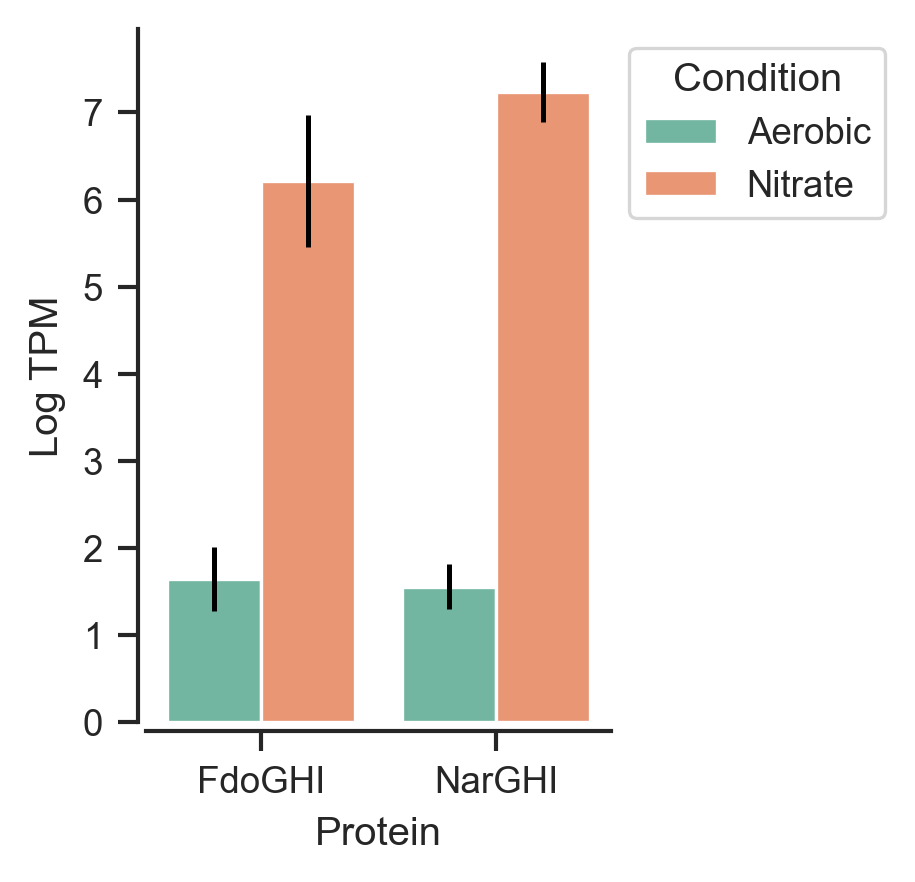

In [120]:
# plot as barplot with manually provided std
plt.figure(figsize=(2,3))

g = sns.barplot(data=nitrate_rna_df.to_pandas(), x="Protein", y="Log TPM", hue="Condition",  legend=True, ci=None, hue_order=["Aerobic", "Nitrate"])

# add error bars by iterating on g
for i in range(len(nitrate_rna_df.to_pandas())):
    # get the x and y values
    x = g.patches[i].get_x() + g.patches[i].get_width() / 2
    y = g.patches[i].get_height()

    # get the error value
    error = nitrate_rna_df.to_pandas()["Error"].iloc[i]

    # add the error bar
    plt.errorbar(x, y, yerr=error, fmt='none', color='black', capsize=0)

sns.despine(offset=2, trim=False)

# move out legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Condition")

# save as svg
plt.savefig("figures/nitrate_rna.svg", transparent=True)

# Increase in MO

In [121]:
# find NARG-MONOMER, NARH-MONOMER, NARI-MONOMER and NITRATREDUCTA-CPLX
nitrate_proteins = ['NARG-MONOMER', 'NARH-MONOMER', 'NARI-MONOMER', 'NITRATREDUCTA-CPLX']

# repeat for FDNG-MONOMER, FDNH-MONOMER, FDNI-MONOMER and FORMATEDEHYDROGN-CPLX
formate_proteins = ['FDNG-MONOMER', 'FDNH-MONOMER', 'FDNI-MONOMER', 'FORMATEDEHYDROGN-CPLX']

In [122]:
# create total counts modified



# find the indices of the proteins
nitrate_idx = [np.where(protein_ids == protein)[0][0]+1 for protein in nitrate_proteins]
formate_idx = [np.where(protein_ids == protein)[0][0]+1 for protein in formate_proteins]

# create modified counts where the nitrate proteins are multiplied by 100
total_counts_mod = total_counts_big.copy()
total_counts_mod[:, nitrate_idx] = total_counts_mod[:, nitrate_idx] * 300
total_counts_mod[:, formate_idx] = (total_counts_mod[:, formate_idx] +3.5) * 300

# repeat bulk calculation
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
big_element_timeseries = total_counts_mod[:, 1:-1] @ C @ P @ E[:, element_indices]

# convert to polars dataframe
big_element_df = pl.DataFrame(big_element_timeseries, schema=elements)

# add Timestep and Cell index from total_counts_big 
big_element_df = big_element_df.with_columns(pl.DataFrame(total_counts_mod[:, [0, -1]], schema=["Timestep", "Cell index"]))
big_element_df

# Groupby cell index, then add the max timestep for each cell
max_timestep = big_element_df.group_by("Cell index").agg(pl.col("Timestep").max().alias("Max timestep"))

# merge with original
big_element_df = big_element_df.join(max_timestep, on="Cell index")

# calculate cell density correction factor with 2 ^((Max timestep - Timestep)/Max timestep)
big_element_df = big_element_df.with_columns( (2 ** ((big_element_df["Max timestep"] - big_element_df["Timestep"]) 
                                                     / big_element_df["Max timestep"])).alias("Density correction"))

# remove all cols except element, cell index and density correction
big_element_df = big_element_df.drop(["Timestep", "Max timestep"])

# multiply the atoms/cell by the density correction
big_element_df = big_element_df.melt(id_vars=["Cell index", "Density correction"], value_name="Atoms/cell", variable_name="Element")

# Get the weighted average per element
big_element_df = big_element_df.with_columns( (big_element_df["Atoms/cell"] * big_element_df["Density correction"]).alias("Weighted atoms/cell"))

# divide sum of weighted atoms/cell by sum of density correction
bulk_element_sum = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Weighted atoms/cell").alias("Sum weighted atoms/cell"))
bulk_element_count = big_element_df.group_by(["Element", "Cell index"]).agg(pl.sum("Density correction").alias("Sum density correction"))

# join the two dataframes and divide
bulk_element_df = bulk_element_sum.join(bulk_element_count, on=["Element", "Cell index"])
bulk_element_df = bulk_element_df.with_columns( (bulk_element_df["Sum weighted atoms/cell"] / bulk_element_df["Sum density correction"]).alias("Bulk atoms/cell"))

# remove other cols
bulk_element_df = bulk_element_df.drop(["Sum weighted atoms/cell", "Sum density correction"])

# save to csv
bulk_element_df.write_csv("data/sim_rich_bulk_element_df.csv", include_header=True)

# calculate avg and std dev over all cells
bulk_element_mod_avg = bulk_element_df.group_by("Element").agg(pl.mean("Bulk atoms/cell").alias("Avg atoms/cell"), pl.std("Bulk atoms/cell").alias("Std atoms/cell"))

# add two rows: V and CR with 0 atoms/cell. Concat them to bulk_element_avg
bulk_element_mod_avg = pl.concat([bulk_element_mod_avg, pl.DataFrame([["V", 0., 0.], ["CR", 0., 0.]], schema=["Element", "Avg atoms/cell", "Std atoms/cell"])])

# set "CO" to 0
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Avg atoms/cell")).alias("Avg atoms/cell"))
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.when(pl.col("Element") == "CO").then(0).otherwise(pl.col("Std atoms/cell")).alias("Std atoms/cell"))

# rename cols to match other df
bulk_element_mod_avg = bulk_element_mod_avg.rename({"Element": "Element", "Avg atoms/cell": "Atoms/cell (simulation)", "Std atoms/cell": "Atoms/cell (simulation), stddev"})

bulk_element_mod_avg

shape: (9, 3)
┌─────────┬─────────────────────────┬─────────────────────────────────┐
│ Element ┆ Atoms/cell (simulation) ┆ Atoms/cell (simulation), stdde… │
│ ---     ┆ ---                     ┆ ---                             │
│ str     ┆ f64                     ┆ f64                             │
╞═════════╪═════════════════════════╪═════════════════════════════════╡
│ CU      ┆ 15211.081627            ┆ 1051.768662                     │
│ NI      ┆ 1284.841822             ┆ 176.78077                       │
│ MO      ┆ 14099.444305            ┆ 4644.30008                      │
│ CO      ┆ 0.0                     ┆ 0.0                             │
│ ZN      ┆ 357249.636639           ┆ 22782.838522                    │
│ MN      ┆ 69398.444095            ┆ 3754.98889                      │
│ FE      ┆ 761281.296942           ┆ 100426.399987                   │
│ V       ┆ 0.0                     ┆ 0.0                             │
│ CR      ┆ 0.0                     ┆ 0.0                             │
└─────────┴─────────────────────────┴─────────────────────────────────┘

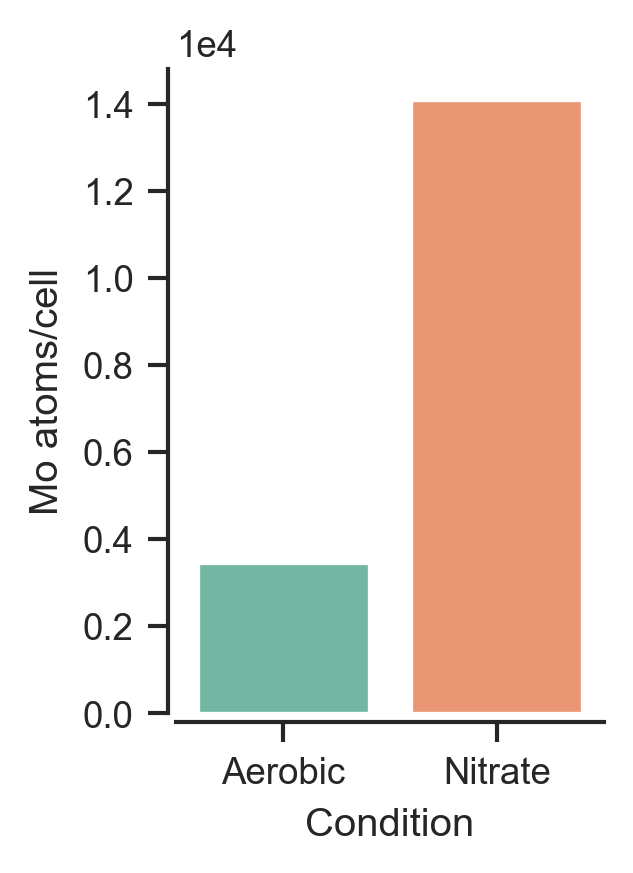

In [123]:
# concat bulk_element_avg and bulk_element_mod_avg, add new column "Condition"
bulk_element_avg = bulk_element_avg.with_columns(pl.lit("Aerobic").alias("Condition"))
bulk_element_mod_avg = bulk_element_mod_avg.with_columns(pl.lit("Nitrate").alias("Condition"))

bulk_element_concat = pl.concat([bulk_element_avg, bulk_element_mod_avg])

# filter only mo
bulk_element_concat = bulk_element_concat.filter(pl.col("Element") == "MO")

# plot 
plt.figure(figsize=(2.2, 3))
sns.barplot(data=bulk_element_concat.to_pandas(), x="Condition", y="Atoms/cell (simulation)", hue="Condition", legend=False)

# change ylabel
plt.ylabel("Mo atoms/cell")

# show y axis in exponent notation
plt.ticklabel_format(style='sci', axis='y')

sns.despine(offset=2, trim=False)

plt.tight_layout()

# save as png and svg
plt.savefig("figures/mo_bulk_element_comparison.svg")

In [124]:
# copy ez_df
mops_df = ez_df.clone()
lb_df = media_lim_df.clone()

# for ez_df, in the condition column, replace Minimal with "MOPS Minimal" and Rich with "EZ Rich". use the replace method in polars.
# first select the condition column, then use the replace method
new_col = mops_df.get_column("Condition").map_dict({"Minimal": "MOPS Minimal", "Rich": "EZ"})
mops_df = mops_df.with_columns(new_col)

new_col = lb_df.get_column("Condition").map_dict({"Minimal": "Minimal media (A)", "Rich": "LB"})
lb_df = lb_df.with_columns(new_col)

# filter out minimal media
mops_df = mops_df.filter((pl.col("Condition") != "MOPS Minimal") )
lb_df = lb_df.filter((pl.col("Condition") != "Minimal media (A)"))

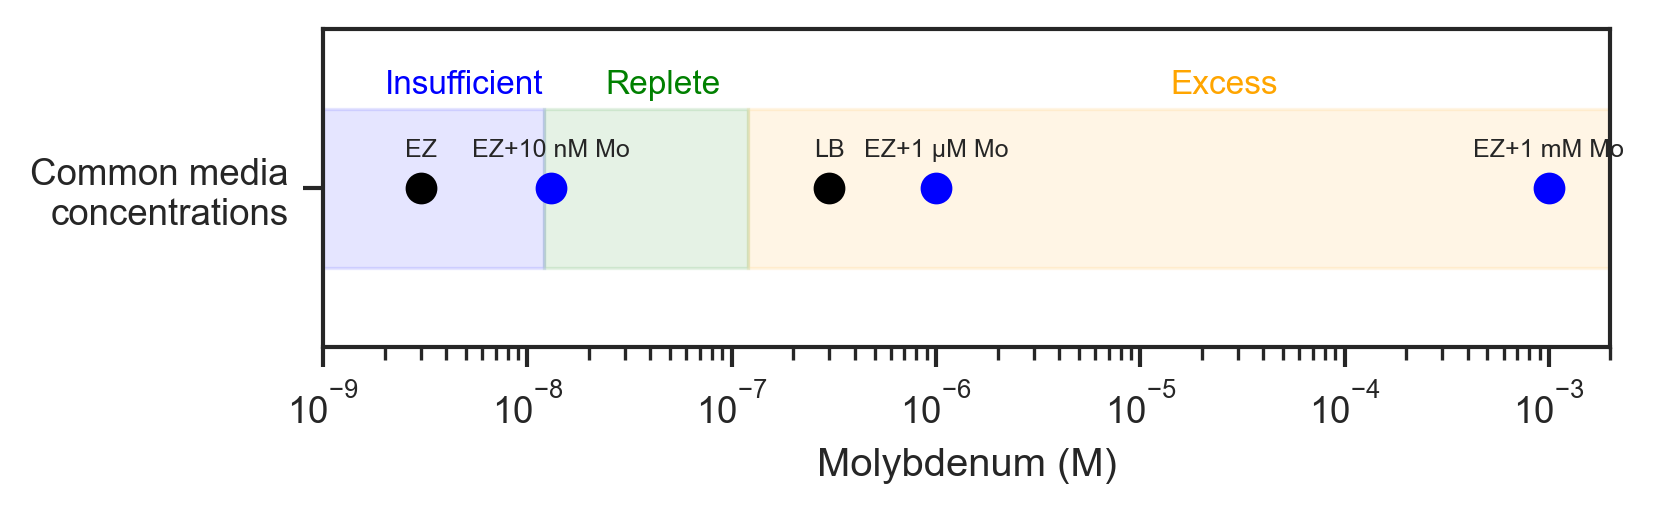

In [125]:

order_pts = ["EZ+10 nM Mo", "EZ+1 µM Mo", "EZ+1 mM Mo", "EZ", "LB"]

mo_lb_df = lb_df.filter(pl.col("Element") == "MO").select("Condition", "Element", "Concentration (M)")
mo_ez_df = mops_df.filter(pl.col("Element") == "MO").select("Condition", "Element", "Concentration (M)")

# rename col to Molybdenum (M)
mo_lb_df = mo_lb_df.rename({"Concentration (M)": "Molybdenum (M)"})
mo_ez_df = mo_ez_df.rename({"Concentration (M)": "Molybdenum (M)"})

# concatenate the two dataframes
mo_df = pl.concat([mo_lb_df, mo_ez_df])


# concat a new df with the following concentrations: 10 nm, 1 µm, 1 mM
mo_df = pl.concat([mo_df, pl.DataFrame({"Condition": ["EZ+10 nM Mo", "EZ+1 µM Mo", "EZ+1 mM Mo"], 
                                        "Element": ["MO", "MO", "MO"], 
                                        "Molybdenum (M)": [1e-8 + 3e-9, 1e-6, 1e-3],})])

# multiply concentration by N_A and divide by 1 trillion cells/ml at OD 1
mo_df = mo_df.with_columns( (mo_df["Molybdenum (M)"] * 6.022e23 / 1e12).alias("Molybdenum (atoms/cell)"))


# 1d line plot with concentrations
f, axs = plt.subplots(1,1,  figsize=(5.6,1.8))

sns.pointplot(data=mo_df.to_pandas(), hue="Condition", x="Molybdenum (M)", 
              marker="o", legend=False, ax=axs, hue_order=order_pts, 
              markersize=6, palette=["blue", "blue", "blue",  "black", "black", ], )

# change x minimum 
axs.set_xlim(1e-9, 2e-3)

axs.set_xscale("log")
# remove xticklabels
axs.set_xticklabels([])
axs.set_yticklabels(["Common media\nconcentrations"])
# write the name of the condition above each point
for i, txt in enumerate(mo_df["Condition"]):
    axs.annotate(txt, (mo_df["Molybdenum (M)"][i] , mo_df["Molybdenum (M)"][i] - 1e-1), fontsize=6, ha="center")
    


# add a transparent rectangle that stretches from 300 nM to 1 µM
axs.axvspan(xmin=1.e-9, xmax=1.2e-8, ymin=0.25, ymax=0.75, color='blue', alpha=0.1)
axs.axvspan(xmin=1.2e-8, xmax=1.2e-7, ymin=0.25, ymax=0.75, color='green', alpha=0.1)
axs.axvspan(xmin=1.2e-7, xmax=2e-3, ymin=0.25, ymax=0.75, color='orange', alpha=0.1)

# add small text above each box that says (insufficient, replete, excess)
axs.text(2e-9, -0.3, "Insufficient", fontsize=8, color="blue")
axs.text(2.4e-8, -0.3, "Replete", fontsize=8, color="green")
axs.text(1.4e-5, -0.3, "Excess", fontsize=8, color="orange")
#axs.text(1.5e-8, 1.5, "Replete", fontsize=6, color="green")
#axs.text(1.5e-7, 1.5, "Excess", fontsize=6, color="orange")


axs.set_xscale("log")
axs.set_xticklabels([])

# set yticklabel to be "aerobic conditions"
# ax[1].set_yticklabels(["Cell requirement:\nAerobic respiration"])


# second plot
# axs.axvspan(xmin=5e-8, xmax=2e-6, ymin=0.25, ymax=0.75, color='red', alpha=0.1)

# make a triangle, with the following vertices. (1e-7, 0.5), (1e-6, 0.75), (1e-6, 0.25)
# axs.fill([1.3e-8, 1.3e-8, 2e-4], [-0.25, 0.25, 0.], color='red', alpha=0.1)


#sns.pointplot(data=mo_df.to_pandas(), hue="Condition", x="Concentration (M)", marker="o", legend=False, palette="viridis", ax=ax[2], alpha=0)
axs.set_xscale("log")
# ax[2].set_yticklabels(["Cell requirement:\nAnaerobic nitrate\nrespiration"])

plt.tight_layout()

# save as png and svg
plt.savefig("figures/mo_concentration.svg", transparent=True)


Text(0, 0.5, 'Fraction required \nfor replete growth')

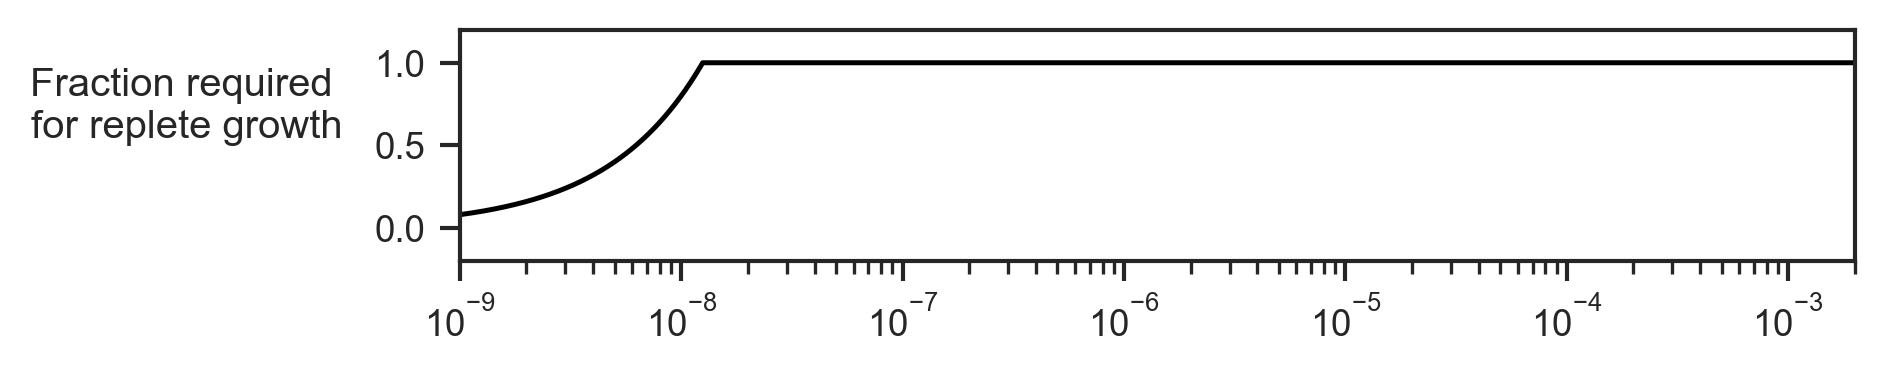

In [126]:
# 25000 * 0.3 * 10*10^11 / (6.023*10^23) 

# make a linspace from 1e-11 to 1.25e-8 that is 1000 points long
x = np.linspace(1e-11, 1.25e-8, 1000)

# make a linspace from 0 to 1 that is 1000 points long
y = np.linspace(0, 1, 1000)

# append from 1.25e-8 to 2e-3 to x
x = np.append(x, np.linspace(1.25e-8, 2e-3, 1000))

# append 1 to y
y = np.append(y, np.ones(1000))

# plot on log scale from 1e-9 to 2e-3
plt.figure(figsize=(6, 1))
plt.plot(x, y, color="black")
plt.xscale("log")
plt.xlim(1e-9, 2e-3)
plt.ylim(-0.2, 1.2)

# set ylabel to "Fraction required for replete growth", rotated 90 degrees
plt.ylabel("Fraction required \nfor replete growth", rotation=0, labelpad=45)

## Updated data

In [127]:
# order = ["-/-", "+/-", "+/1", "+/2", "+/3"]

mapping = {"-/-": "No nitrate", "+/-": "Base media", "+/1": "10 nM Mo", 
           "+/2": "1 µM Mo", "+/3": "1 mM Mo"}

values = list(mapping.values())

# import the data
mo_gr_df = pl.read_csv("data/no3_df_v2.csv")

# drop -/2 rows
mo_gr_df = mo_gr_df.filter(pl.col("Additive") != "-/2")


order = list(mapping.values())

# replace the Additive column with the mapping
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Additive").map_dict(mapping))

# Map Molybdenum to these values in a new column: -: 3 nm, 1: 10 nm, 2: 1 µM, 3: 1 mM
mo_gr_df = mo_gr_df.with_columns(mo_gr_df.get_column("Molybdenum").map_dict({"-": 3e-9, "1": 1.3e-8, "2": 1e-6, "3": 1e-3}).alias("Molybdenum (M)"))

# drop null values
mo_gr_df = mo_gr_df.filter(pl.col("Additive").is_not_null())

# Create a growth rate change column. Subtract mean of base, then divide by mean of base
mo_gr_df = mo_gr_df.with_columns( ((mo_gr_df["Growth rate"] - mo_gr_df.filter(pl.col("Additive") == "Base media")["Growth rate"].mean()) / mo_gr_df.filter(pl.col("Additive") == "Base media")["Growth rate"].mean()).alias("Growth rate change"))

# multiply by 100
mo_gr_df = mo_gr_df.with_columns( (mo_gr_df["Growth rate change"] * 100).alias("Growth rate change (%)"))

# create a doubling time column
mo_gr_df = mo_gr_df.with_columns( (np.log(2) / mo_gr_df["Growth rate"] * 60).alias("Doubling time (min)"))

mo_gr_df

shape: (30, 8)
┌────────────┬────────────┬─────────┬────────────┬────────────┬────────────┬───────────┬───────────┐
│ Additive   ┆ Growth     ┆ Nitrate ┆ Molybdenum ┆ Molybdenum ┆ Growth     ┆ Growth    ┆ Doubling  │
│ ---        ┆ rate       ┆ ---     ┆ ---        ┆ (M)        ┆ rate       ┆ rate      ┆ time      │
│ str        ┆ ---        ┆ str     ┆ str        ┆ ---        ┆ change     ┆ change    ┆ (min)     │
│            ┆ f64        ┆         ┆            ┆ f64        ┆ ---        ┆ (%)       ┆ ---       │
│            ┆            ┆         ┆            ┆            ┆ f64        ┆ ---       ┆ f64       │
│            ┆            ┆         ┆            ┆            ┆            ┆ f64       ┆           │
╞════════════╪════════════╪═════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╡
│ Base media ┆ 1.582207   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.018575   ┆ 1.857508  ┆ 26.285327 │
│ Base media ┆ 1.552509   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ -0.000543  ┆ -0.054334 ┆ 26.788134 │
│ Base media ┆ 1.564273   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.00703    ┆ 0.702988  ┆ 26.586678 │
│ Base media ┆ 1.51512    ┆ +       ┆ -          ┆ 3.0000e-9  ┆ -0.024614  ┆ -2.461381 ┆ 27.449208 │
│ Base media ┆ 1.579022   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.016525   ┆ 1.652473  ┆ 26.338345 │
│ …          ┆ …          ┆ …       ┆ …          ┆ …          ┆ …          ┆ …         ┆ …         │
│ No nitrate ┆ 1.138065   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.26735   ┆ -26.73496 ┆ 36.543459 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 4         ┆           │
│ No nitrate ┆ 1.185643   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.23672   ┆ -23.67203 ┆ 35.077022 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 1         ┆           │
│ No nitrate ┆ 1.213204   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.218978  ┆ -21.89775 ┆ 34.280166 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 7         ┆           │
│ No nitrate ┆ 1.215814   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.217297  ┆ -21.7297  ┆ 34.206562 │
│ No nitrate ┆ 1.184421   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.237507  ┆ -23.75067 ┆ 35.113202 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 8         ┆           │
└────────────┴────────────┴─────────┴────────────┴────────────┴────────────┴───────────┴───────────┘

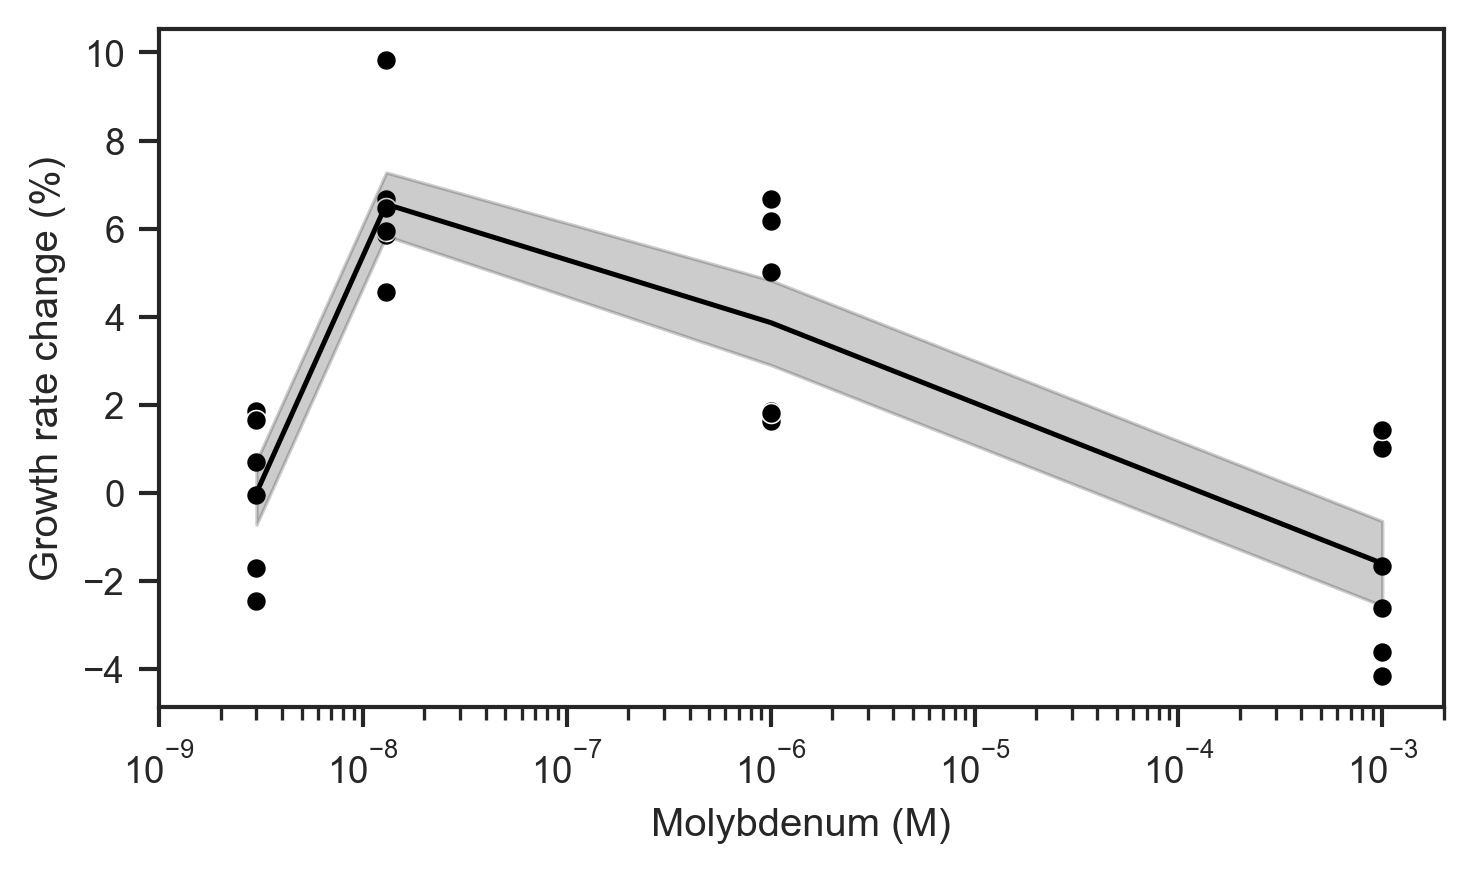

In [128]:
order = ["Base media", "10 nM Mo", "1 µM Mo", "1 mM Mo"]

# scatter mo_gr_df 
f = plt.figure(figsize=(5, 3))
sns.scatterplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(), 
                x="Molybdenum (M)", y="Growth rate change (%)",  legend=False, color="black")

# scatter means of the different conditions
sns.lineplot(data=mo_gr_df.filter(pl.col("Additive") != "No nitrate").to_pandas(),
                x="Molybdenum (M)", y="Growth rate change (%)",  palette="viridis",   legend=False, color="black", errorbar="se")

plt.xscale("log")

plt.xlim(1e-9, 2e-3)

plt.tight_layout()

# save as png and svg
plt.savefig("figures/mo_growth_rate.svg", transparent=True)

(20.0, 37.0)

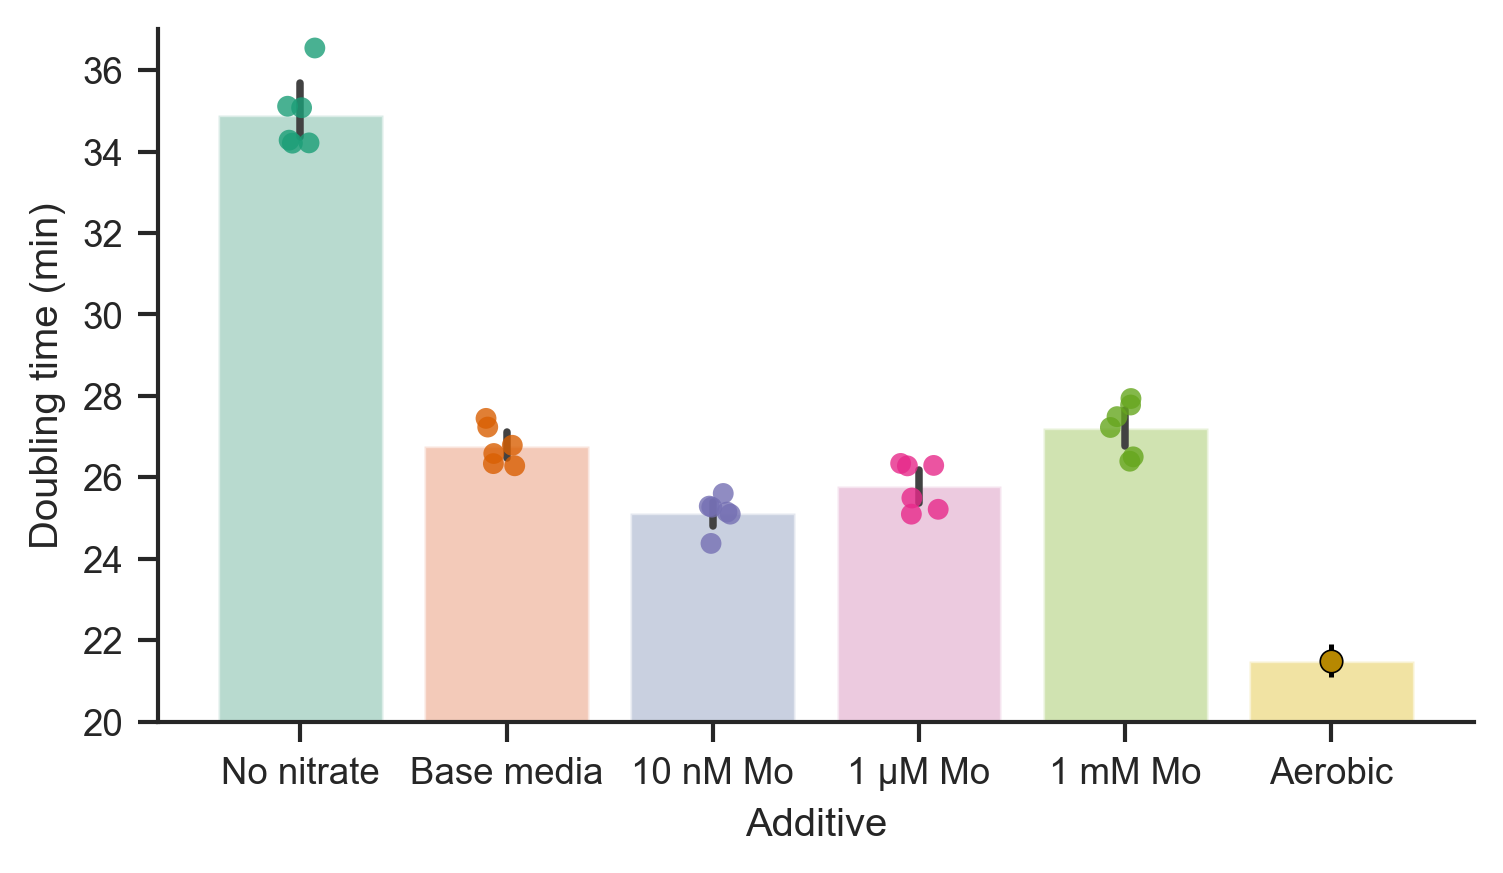

In [129]:
f_df = mo_gr_df.to_pandas()

# add a value for "Aerobic" at 21.5 min
f_df = pd.concat([f_df, pd.DataFrame({"Additive": ["Aerobic"], "Growth rate change (%)": [0], "Molybdenum (M)": [0.], "Doubling time (min)": [21.5]})])

order = ["No nitrate", "Base media", "10 nM Mo", "1 µM Mo", "1 mM Mo", "Aerobic"]

g = sns.catplot(data=f_df, x="Additive", y="Doubling time (min)", hue="Additive",
                kind="bar", aspect=1.7, height=3, alpha=0.5, hue_order=order, order=order)

g.map_dataframe(sns.stripplot, x="Additive", y="Doubling time (min)", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', 
                linewidth=0, hue_order=order, order=order,)

# add errorbar to Aerobic with 0.5 min
for ax in plt.gcf().axes:
    ax.errorbar(5, 21.5, yerr=0.4, fmt='o', color='black')
    ax.set_ylim(0, 30)

plt.ylim(20, 37)

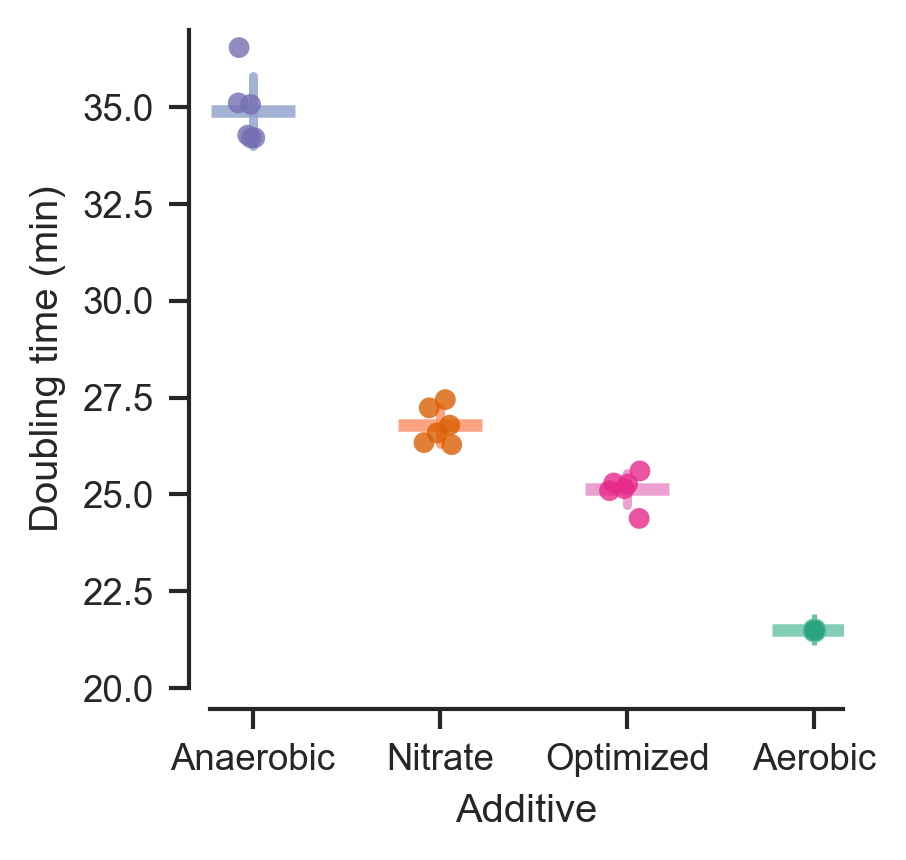

In [155]:
# remove 1 µM Mo and 1 mM Mo
f_df = mo_gr_df.filter((pl.col("Additive") != "1 µM Mo") & (pl.col("Additive") != "1 mM Mo")).to_pandas()

# translate additive into following dict
plot_names = {"No nitrate": "Anaerobic", "Base media": "Nitrate", 
              "10 nM Mo": "Optimized"}

# convert values in df
f_df["Additive"] = f_df["Additive"].map(plot_names)



# add a value for "Aerobic" at 21.5 min
f_df = pd.concat([f_df, pd.DataFrame({"Additive": ["Aerobic"], "Growth rate change (%)": [0], "Molybdenum (M)": [0.], "Doubling time (min)": [21.5]})])

order = ["Anaerobic", "Nitrate", "Optimized", "Aerobic"]
hue_order = ["Aerobic", "Nitrate", "Anaerobic", "Optimized", ]

g = sns.catplot(data=f_df, x="Additive", y="Doubling time (min)", hue="Additive",
                kind="point", aspect=1, height=3, alpha=0.8, hue_order=hue_order, order=order,
                errorbar="sd",marker="_", markersize=20, markeredgewidth=3,
                
                )

g.map_dataframe(sns.stripplot, x="Additive", y="Doubling time (min)", alpha=0.8, 
                dodge=False, jitter=0.1, size=5, hue="Additive", palette="Dark2",edgecolor='black', 
                linewidth=0, hue_order=hue_order, order=order,)

# kind="point", aspect=1, height=3, alpha=1, hue_order=hue_order, order=order, errorbar="sd",marker="_", markersize=30, markeredgewidth=3,

# add errorbar to Aerobic with 0.5 min
for ax in plt.gcf().axes:
    ax.errorbar(3, 21.5, yerr=0.4, fmt='o', color=sns.color_palette("Set2")[0])
    ax.set_ylim(0, 30)

sns.despine(offset=5, trim=False)

plt.tight_layout()

plt.ylim(20, 37)

# save as png and svg
plt.savefig("figures/mo_doubling_time.svg", transparent=True)

# save df as csv 
pl.DataFrame(f_df).write_csv("data/mo_growth_rate_df.csv", include_header=True)

In [133]:
mo_gr_df

shape: (30, 8)
┌────────────┬────────────┬─────────┬────────────┬────────────┬────────────┬───────────┬───────────┐
│ Additive   ┆ Growth     ┆ Nitrate ┆ Molybdenum ┆ Molybdenum ┆ Growth     ┆ Growth    ┆ Doubling  │
│ ---        ┆ rate       ┆ ---     ┆ ---        ┆ (M)        ┆ rate       ┆ rate      ┆ time      │
│ str        ┆ ---        ┆ str     ┆ str        ┆ ---        ┆ change     ┆ change    ┆ (min)     │
│            ┆ f64        ┆         ┆            ┆ f64        ┆ ---        ┆ (%)       ┆ ---       │
│            ┆            ┆         ┆            ┆            ┆ f64        ┆ ---       ┆ f64       │
│            ┆            ┆         ┆            ┆            ┆            ┆ f64       ┆           │
╞════════════╪════════════╪═════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╡
│ Base media ┆ 1.582207   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.018575   ┆ 1.857508  ┆ 26.285327 │
│ Base media ┆ 1.552509   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ -0.000543  ┆ -0.054334 ┆ 26.788134 │
│ Base media ┆ 1.564273   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.00703    ┆ 0.702988  ┆ 26.586678 │
│ Base media ┆ 1.51512    ┆ +       ┆ -          ┆ 3.0000e-9  ┆ -0.024614  ┆ -2.461381 ┆ 27.449208 │
│ Base media ┆ 1.579022   ┆ +       ┆ -          ┆ 3.0000e-9  ┆ 0.016525   ┆ 1.652473  ┆ 26.338345 │
│ …          ┆ …          ┆ …       ┆ …          ┆ …          ┆ …          ┆ …         ┆ …         │
│ No nitrate ┆ 1.138065   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.26735   ┆ -26.73496 ┆ 36.543459 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 4         ┆           │
│ No nitrate ┆ 1.185643   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.23672   ┆ -23.67203 ┆ 35.077022 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 1         ┆           │
│ No nitrate ┆ 1.213204   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.218978  ┆ -21.89775 ┆ 34.280166 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 7         ┆           │
│ No nitrate ┆ 1.215814   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.217297  ┆ -21.7297  ┆ 34.206562 │
│ No nitrate ┆ 1.184421   ┆ -       ┆ -          ┆ 3.0000e-9  ┆ -0.237507  ┆ -23.75067 ┆ 35.113202 │
│            ┆            ┆         ┆            ┆            ┆            ┆ 8         ┆           │
└────────────┴────────────┴─────────┴────────────┴────────────┴────────────┴───────────┴───────────┘

In [137]:
# do t tests
# calculate p values
from scipy.stats import ttest_ind
# get the data for met and zn
nitrate_data = mo_gr_df.filter(pl.col("Additive") == "Base media")["Doubling time (min)"].to_numpy()
optimized_data = mo_gr_df.filter(pl.col("Additive") == "10 nM Mo")["Doubling time (min)"].to_numpy()


# perform t-test
t_stat, p_value = ttest_ind(nitrate_data, optimized_data)
print(f"T-test between basic and optimized: t-statistic = {t_stat}, p-value = {p_value}")

T-test between basic and optimized: t-statistic = 6.4306382350698525, p-value = 7.53157280057805e-05
